In [108]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import cmocean
import cartopy.crs as ccrs

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn import linear_model
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

# Summary 

This notebook opens up the NOBM-OASIM dataset with the added PC scores, standardizes all the environmental variables, and creates new datasets for each phyto group > 0.01 with added logged phyto concentrations. Then, data is split into training and testing and for each phyto group, a backward stepwise regression is used to select most important variables (PC scores and env variables). Selected variables, coefficients, and the int are saved as a .csv for each. 


# Read in dataset w/ scores

In [146]:
rrs_xds = xr.open_dataset('/glusteruser/awindled/ALL_NOBM_OASIM_data_2020_w_EOF.nc', decode_times=False)
rrs_xds

<xarray.Dataset>
Dimensions:         (months: 12, lat: 234, lon: 288, wavelength: 401)
Coordinates:
  * months          (months) float32 0.0 1.0 2.0 3.0 4.0 ... 8.0 9.0 10.0 11.0
  * lat             (lat) float32 -84.0 -83.33 -82.67 -82.0 ... 70.0 70.67 71.33
  * lon             (lon) float32 -180.0 -178.8 -177.5 ... 176.2 177.5 178.8
  * wavelength      (wavelength) int64 350 351 352 353 354 ... 747 748 749 750
    wv              (wavelength) int64 ...
Data variables: (12/57)
    tot             (months, lat, lon) float32 ...
    chl             (months, lat, lon) float32 ...
    dia             (months, lat, lon) float32 ...
    coc             (months, lat, lon) float32 ...
    cya             (months, lat, lon) float32 ...
    din             (months, lat, lon) float32 ...
    ...              ...
    EOF_3           (months, lat, lon) float64 ...
    EOF_4           (months, lat, lon) float64 ...
    EOF_5           (months, lat, lon) float64 ...
    EOF_6           (months, lat, lon) float64 ...
    EOF_7           (months, lat, lon) float64 ...
    EOF_8           (months, lat, lon) float64 ...

### Make 0's -> nans in EOFs

In [147]:
EOFs = ['EOF_1', 'EOF_2', 'EOF_3', 'EOF_4', 'EOF_5', 'EOF_6', 'EOF_7', 'EOF_8'] 

for i in range(len(EOFs)):
    rrs_xds[EOFs[i]] = rrs_xds[EOFs[i]].where(rrs_xds[EOFs[i]] != 0.0)
rrs_xds

<xarray.Dataset>
Dimensions:         (months: 12, lat: 234, lon: 288, wavelength: 401)
Coordinates:
  * months          (months) float32 0.0 1.0 2.0 3.0 4.0 ... 8.0 9.0 10.0 11.0
  * lat             (lat) float32 -84.0 -83.33 -82.67 -82.0 ... 70.0 70.67 71.33
  * lon             (lon) float32 -180.0 -178.8 -177.5 ... 176.2 177.5 178.8
  * wavelength      (wavelength) int64 350 351 352 353 354 ... 747 748 749 750
    wv              (wavelength) int64 ...
Data variables: (12/57)
    tot             (months, lat, lon) float32 ...
    chl             (months, lat, lon) float32 ...
    dia             (months, lat, lon) float32 ...
    coc             (months, lat, lon) float32 ...
    cya             (months, lat, lon) float32 ...
    din             (months, lat, lon) float32 ...
    ...              ...
    EOF_3           (months, lat, lon) float64 nan nan nan nan ... nan nan nan
    EOF_4           (months, lat, lon) float64 nan nan nan nan ... nan nan nan
    EOF_5           (months, lat, lon) float64 nan nan nan nan ... nan nan nan
    EOF_6           (months, lat, lon) float64 nan nan nan nan ... nan nan nan
    EOF_7           (months, lat, lon) float64 nan nan nan nan ... nan nan nan
    EOF_8           (months, lat, lon) float64 nan nan nan nan ... nan nan nan

# Standardize env variables (values range from 0-1)

In [148]:
env_vars = ['pic', 'irn', 'rno', 'h', 'sil', 'dtc', 'cdc', 't', 's', 'par']
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

for i in range(len(env_vars)):
    foo = rrs_xds[env_vars[i]].values.reshape(12*234*288)
    foo = scaler.fit_transform(foo.reshape(-1, 1))
    rrs_xds[env_vars[i]].values = foo.reshape(12,234,288)

# Convert data into pandas dataframe

In [149]:
variables = list(rrs_xds.keys())[0:18]
variables.extend(['aph440_aph676', 'aph440_ap440', 'a_cdoc_443', 'bbp_s_440_555', 
                  'a_bb_555', 'bbp_bp_555'])
variables.extend(list(rrs_xds.keys())[47:68])
variables.remove("ice")

rrs_xds_dat = rrs_xds[variables].to_dataframe()
rrs_xds_dat

tot  chl  dia  coc  cya  din  pha  pic  irn  rno  \
months lat        lon                                                         
0.0    -84.000000 -180.00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                  -178.75  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                  -177.50  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                  -176.25  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                  -175.00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
...                        ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
11.0    71.333336  173.75  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   175.00  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   176.25  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   177.50  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
                   178.75  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

                           ...  a_bb_555  bbp_bp_555  EOF_1  EOF_2  EOF_3  \
months lat        lon      ...                                              
0.0    -84.000000 -180.00  ...       NaN         NaN    NaN    NaN    NaN   
                  -178.75  ...       NaN         NaN    NaN    NaN    NaN   
                  -177.50  ...       NaN         NaN    NaN    NaN    NaN   
                  -176.25  ...       NaN         NaN    NaN    NaN    NaN   
                  -175.00  ...       NaN         NaN    NaN    NaN    NaN   
...                        ...       ...         ...    ...    ...    ...   
11.0    71.333336  173.75  ...       NaN         NaN    NaN    NaN    NaN   
                   175.00  ...       NaN         NaN    NaN    NaN    NaN   
                   176.25  ...       NaN         NaN    NaN    NaN    NaN   
                   177.50  ...       NaN         NaN    NaN    NaN    NaN   
                   178.75  ...       NaN         NaN    NaN    NaN    NaN   

                           EOF_4  EOF_5  EOF_6  EOF_7  EOF_8  
months lat        lon                                         
0.0    -84.000000 -180.00    NaN    NaN    NaN    NaN    NaN  
                  -178.75    NaN    NaN    NaN    NaN    NaN  
                  -177.50    NaN    NaN    NaN    NaN    NaN  
                  -176.25    NaN    NaN    NaN    NaN    NaN  
                  -175.00    NaN    NaN    NaN    NaN    NaN  
...                          ...    ...    ...    ...    ...  
11.0    71.333336  173.75    NaN    NaN    NaN    NaN    NaN  
                   175.00    NaN    NaN    NaN    NaN    NaN  
                   176.25    NaN    NaN    NaN    NaN    NaN  
                   177.50    NaN    NaN    NaN    NaN    NaN  
                   178.75    NaN    NaN    NaN    NaN    NaN  

[808704 rows x 31 columns]

# drop nans for SequentialFeatureSelector function

In [150]:
rrs_xds_dat = rrs_xds_dat.dropna()
rrs_xds_dat

tot           chl           dia           coc  \
months lat        lon                                                           
0.0    -78.000000 -180.00  0.435280  1.302277e-32  5.790093e-08  1.836052e-12   
                  -178.75  0.442183  1.800597e-32  9.011884e-08  3.257872e-12   
                  -177.50  0.481909  2.523838e-32  1.144635e-07  3.826336e-12   
                  -176.25  0.488594  3.730429e-32  1.733026e-07  5.143830e-12   
                  -175.00  0.497206  6.912371e-32  2.431619e-07  7.160853e-12   
...                             ...           ...           ...           ...   
11.0    70.666664  11.25   0.012477  3.297888e-26  9.077619e-03  3.398656e-03   
                   12.50   0.012505  3.692610e-27  9.195263e-03  3.309032e-03   
                   13.75   0.012494  4.220176e-28  9.203578e-03  3.290530e-03   
                   15.00   0.012181  6.779949e-29  9.030103e-03  3.151193e-03   
                   16.25   0.012571  1.280946e-29  9.533199e-03  3.037988e-03   

                                    cya           din           pha       pic  \
months lat        lon                                                           
0.0    -78.000000 -180.00  6.897307e-27  2.209340e-32  4.352803e-01  0.087553   
                  -178.75  1.139934e-26  3.322602e-32  4.421830e-01  0.084408   
                  -177.50  2.645717e-26  3.457083e-32  4.819090e-01  0.082188   
                  -176.25  3.336013e-26  4.394092e-32  4.885941e-01  0.037648   
                  -175.00  6.450341e-26  5.779970e-32  4.972054e-01  0.037325   
...                                 ...           ...           ...       ...   
11.0    70.666664  11.25   2.053559e-32  6.851186e-07  1.198069e-16  0.034525   
                   12.50   2.029524e-32  4.639312e-07  8.584605e-18  0.033835   
                   13.75   2.029467e-32  2.601123e-07  4.475222e-19  0.033764   
                   15.00   2.029227e-32  1.060638e-07  2.997065e-20  0.032094   
                   16.25   2.034517e-32  4.291214e-08  2.179896e-21  0.029447   

                                irn       rno  ...  a_bb_555  bbp_bp_555  \
months lat        lon                          ...                         
0.0    -78.000000 -180.00  0.007332  0.201124  ...  8.187999    0.310835   
                  -178.75  0.006864  0.196557  ...  8.188000    0.321439   
                  -177.50  0.007734  0.213100  ...  8.188001    0.344070   
                  -176.25  0.007556  0.221613  ...  8.188004    0.503596   
                  -175.00  0.007825  0.228030  ...  8.188004    0.510204   
...                             ...       ...  ...       ...         ...   
11.0    70.666664  11.25   0.023712  0.263522  ...  8.553613    0.097476   
                   12.50   0.022787  0.258618  ...  8.723207    0.097836   
                   13.75   0.022105  0.255697  ...  8.751264    0.097698   
                   15.00   0.024089  0.287036  ...  8.856963    0.099075   
                   16.25   0.019779  0.243204  ...  9.263827    0.105859   

                              EOF_1     EOF_2     EOF_3     EOF_4     EOF_5  \
months lat        lon                                                         
0.0    -78.000000 -180.00  1.360266 -0.191872 -0.897007 -0.420749  1.557226   
                  -178.75  1.324405 -0.234275 -0.944701 -0.471543  1.505242   
                  -177.50  1.286334 -0.277437 -0.992318 -0.523330  1.450917   
                  -176.25  1.088890 -0.500141 -1.230536 -0.763205  1.232905   
                  -175.00  1.085033 -0.505047 -1.235329 -0.768063  1.228512   
...                             ...       ...       ...       ...       ...   
11.0    70.666664  11.25   1.237665 -0.349772 -1.066330 -0.573227  1.465386   
                   12.50   1.236489 -0.350209 -1.067340 -0.574370  1.464955   
                   13.75   1.236332 -0.350629 -1.067371 -0.575595  1.464647   
                   15.00   1.235222 -0.352707 -1.069395 -0.576664 

# Filter dataset so each phyto group only has values > 0.01. 
## Prints the percentage of non-nan data


In [151]:
phyto_vars = ['tot', 'chl', 'dia', 'coc', 'cya', 'din', 'pha'] 

for i in range(len(phyto_vars)):
    rrs_xds_dat[phyto_vars[i]][rrs_xds_dat[phyto_vars[i]] < 0.01] = np.nan
    print(phyto_vars[i], (rrs_xds_dat[phyto_vars[i]].count() / 487726)*100)   

tot 96.88349606131311
chl 32.26688755571776
dia 42.15420133435577
coc 36.08316964853216
cya 45.516334991368105
din 0.9849792711481447
pha 18.978893887141552


# Correlation plot of phyto groups and env data/ PC scores

['pic', 'irn', 'rno', 'h', 'sil', 'dtc', 'cdc', 't', 's', 'par', 'aph440_aph676', 'aph440_ap440', 'bbp_s_440_555', 'a_bb_555', 'bbp_bp_555', 'EOF_1', 'EOF_2', 'EOF_3', 'EOF_4', 'EOF_5', 'EOF_6', 'EOF_7', 'EOF_8']


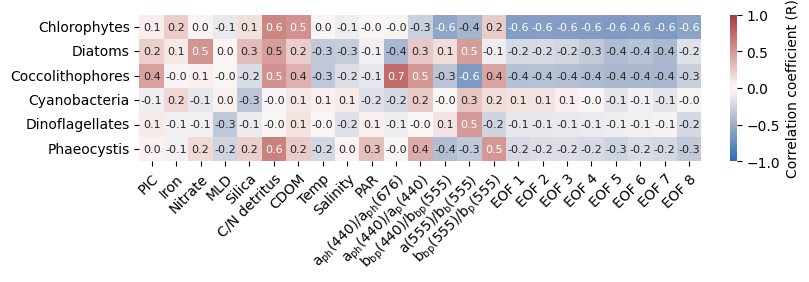

In [152]:
fig, axs = plt.subplots(figsize=(8,5), sharey=True, layout='compressed')

phyto_vars = ['tot', 'chl', 'dia', 'coc', 'cya', 'din', 'pha'] 

env_vars = list(rrs_xds.keys())[7:18]
env_vars.extend(['aph440_aph676', 'aph440_ap440', 'bbp_s_440_555', 
                  'a_bb_555', 'bbp_bp_555'])
env_vars.remove('ice')
env_vars.extend(['EOF_1', 'EOF_2', 'EOF_3', 'EOF_4', 'EOF_5', 'EOF_6', 'EOF_7', 'EOF_8'])
print(env_vars)

sns.heatmap(rrs_xds_dat.corr().loc[phyto_vars[1:], env_vars], vmin=-1, vmax=1,
            cmap='vlag', square=True, annot=True, fmt='.1f', annot_kws={"fontsize":8}, cbar_kws={'label': 'Correlation coefficient (R)'})

axs.set_yticklabels(['Chlorophytes', 'Diatoms', 'Coccolithophores', 'Cyanobacteria', 
                     'Dinoflagellates', 'Phaeocystis'], rotation=0)

axs.set_xticklabels(['PIC', 'Iron', 'Nitrate', 'MLD', 'Silica', 'C/N detritus', 'CDOM', 'Temp', 
                     'Salinity', 'PAR', 'a$_{ph}$(440)/a$_{ph}$(676)', 'a$_{ph}$(440)/a$_{p}$(440)', 
                     'b$_{bp}$(440)/b$_{bp}$(555)', 'a(555)/b$_{b}$(555)', 'b$_{bp}$(555)/b$_{p}$(555)', 
                     'EOF 1', 'EOF 2', 'EOF 3', 'EOF 4', 'EOF 5', 'EOF 6', 'EOF 7', 'EOF 8'], rotation=45, ha='right', rotation_mode='anchor')

#plt.show()
plt.savefig('/glusteruser/awindled/PCC_OASIM_figs/corr_plot.png', dpi=300) 


# Make new datasets for each phyto group that filter phyto conc less than 0.01

In [153]:
tot_dat = rrs_xds_dat[rrs_xds_dat.tot > 0.01]
tot_dat.name = 'tot_dat'
chl_dat = rrs_xds_dat[rrs_xds_dat.chl > 0.01]
chl_dat.name = 'chl_dat'
dia_dat = rrs_xds_dat[rrs_xds_dat.dia > 0.01]
dia_dat.name = 'dia_dat'
coc_dat = rrs_xds_dat[rrs_xds_dat.coc > 0.01]
coc_dat.name = 'coc_dat'
cya_dat = rrs_xds_dat[rrs_xds_dat.cya > 0.01]
cya_dat.name = 'cya_dat'
din_dat = rrs_xds_dat[rrs_xds_dat.din > 0.01]
din_dat.name = 'din_dat'
pha_dat = rrs_xds_dat[rrs_xds_dat.pha > 0.01]
pha_dat.name = 'pha_dat'

# Make new variables of logged phyto groups

In [154]:
tot_dat['log_tot'] = np.log10(tot_dat.tot)
chl_dat['log_chl'] = np.log10(chl_dat.chl)
dia_dat['log_dia'] = np.log10(dia_dat.dia)
coc_dat['log_coc'] = np.log10(coc_dat.coc)
cya_dat['log_cya'] = np.log10(cya_dat.cya)
din_dat['log_din'] = np.log10(din_dat.din)
pha_dat['log_pha'] = np.log10(pha_dat.pha)

## Print the amount of pixels and percentage of total pixels 

In [155]:
print(len(tot_dat), (len(tot_dat)/ 487726)*100)
print(len(chl_dat), (len(chl_dat)/ 487726)*100)
print(len(dia_dat), (len(dia_dat)/ 487726)*100)
print(len(coc_dat), (len(coc_dat)/ 487726)*100)
print(len(cya_dat), (len(cya_dat)/ 487726)*100)
print(len(din_dat), (len(din_dat)/ 487726)*100)
print(len(pha_dat), (len(pha_dat)/ 487726)*100)

472526 96.88349606131311
157374 32.26688755571776
205597 42.15420133435577
175987 36.08316964853216
221995 45.516334991368105
4804 0.9849792711481447
92565 18.978893887141552


# Look at distribution of phyto group conc

<Axes: title={'center': 'log_pha'}, ylabel='Frequency'>

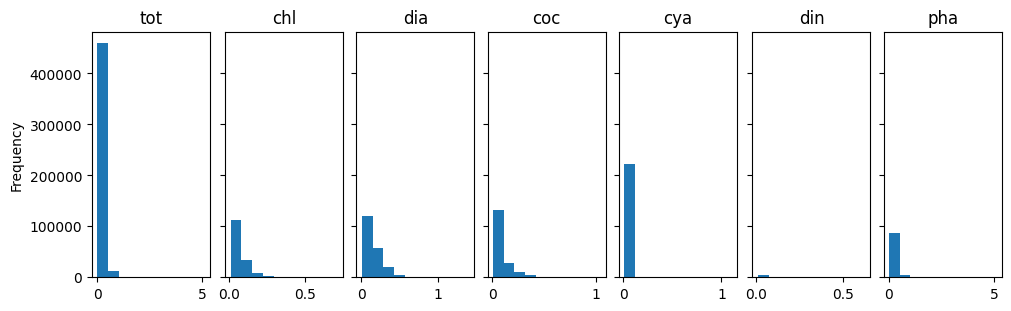

<Figure size 640x480 with 0 Axes>

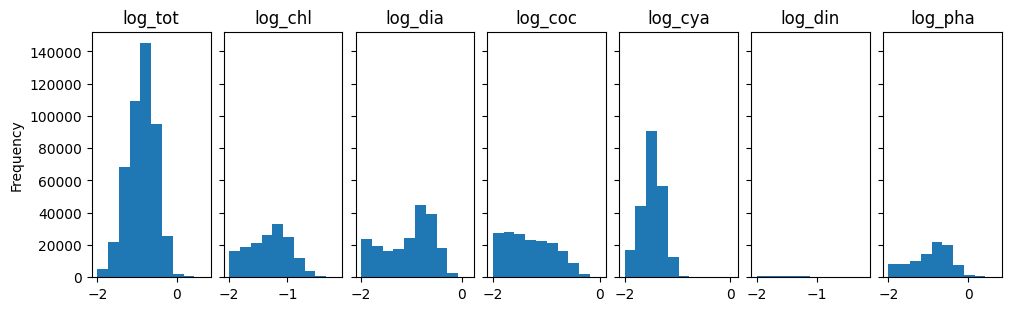

In [156]:
#histograms of phyto groups
fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(10,3), sharey=True, layout='compressed')
axs = axs.ravel()

tot_dat.tot.plot.hist(ax=axs[0], title='tot')
chl_dat.chl.plot.hist(ax=axs[1], title='chl')
dia_dat.dia.plot.hist(ax=axs[2], title='dia')
coc_dat.coc.plot.hist(ax=axs[3], title='coc')
cya_dat.cya.plot.hist(ax=axs[4], title='cya')
din_dat.din.plot.hist(ax=axs[5], title='din')
pha_dat.pha.plot.hist(ax=axs[6], title='pha')

#histograms of logged phyto groups
plt.figure(2)
fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(10,3), sharey=True, layout='compressed')
axs = axs.ravel()

tot_dat.log_tot.plot.hist(ax=axs[0], title='log_tot')
chl_dat.log_chl.plot.hist(ax=axs[1], title='log_chl')
dia_dat.log_dia.plot.hist(ax=axs[2], title='log_dia')
coc_dat.log_coc.plot.hist(ax=axs[3], title='log_coc')
cya_dat.log_cya.plot.hist(ax=axs[4], title='log_cya')
din_dat.log_din.plot.hist(ax=axs[5], title='log_din')
pha_dat.log_pha.plot.hist(ax=axs[6], title='log_pha')

In [157]:
print(tot_dat.tot.min(), tot_dat.tot.max(), tot_dat.log_tot.min(), tot_dat.log_tot.max())
print(chl_dat.chl.min(), chl_dat.chl.max(), chl_dat.log_chl.min(), chl_dat.log_chl.max())
print(dia_dat.dia.min(), dia_dat.dia.max(), dia_dat.log_dia.min(), dia_dat.log_dia.max())
print(coc_dat.coc.min(), coc_dat.coc.max(), coc_dat.log_coc.min(), coc_dat.log_coc.max())
print(cya_dat.cya.min(), cya_dat.cya.max(), cya_dat.log_cya.min(), cya_dat.log_cya.max())
print(din_dat.din.min(), din_dat.din.max(), din_dat.log_din.min(), din_dat.log_din.max())
print(pha_dat.pha.min(), pha_dat.pha.max(), pha_dat.log_pha.min(), pha_dat.log_pha.max())

0.010001582093536854 5.105597019195557 -1.9999313354492188 0.708046555519104
0.010000105015933514 0.7164859175682068 -1.999995470046997 -0.1447923332452774
0.010000044479966164 1.3983944654464722 -1.9999980926513672 0.14562970399856567
0.010000118054449558 1.0386821031570435 -1.9999948740005493 0.016482649371027946
0.010000044479966164 1.1030681133270264 -1.9999980926513672 0.042602330446243286
0.010002417489886284 0.6282933354377747 -1.9998949766159058 -0.20183753967285156
0.010001271031796932 5.105556964874268 -1.999944806098938 0.708043098449707


# The MLR function:
- performs sequential feature selector on all data to find most important variables
- perform 100 k-fold cross validation which splits 75% train, 25% test to obtain predicted results and goodness of fit metrics
- plot actual vs predicted (logged and unlogged)
- save selected_features, mean/std coefs, mean int, and goodness of fit metrics as .csv


In [ ]:
Look at magnitude of coefs over time - show whats most important in time and space 

In [172]:
def MLR(phyto_dat, vars, output_name):

    phyto = phyto_dat.name[0:3]
    print(phyto)

    # select columns that are x variables (all columns except phyto groups)
    phyto_dat_x = phyto_dat[vars]
    
    #apply backward stepwise selection to all data
    sfs = SequentialFeatureSelector(linear_model.LinearRegression(),
                                n_features_to_select='auto', tol=-0.01,
                                direction='backward', scoring = 'r2', 
                                n_jobs=40, cv=5) 
    
    phyto_selected_features = sfs.fit(phyto_dat_x, phyto_dat['log_'+phyto])
    phyto_selected_features = phyto_dat_x.loc[:, phyto_selected_features.support_].columns
    print(phyto_selected_features)
    
    coefs_all = []
    coefs_std_all = []
    intercept_all = []
    r2_scores = []
    bias_scores = []
    mae_scores = []
    
    #100 fold cross validation splitting data into 75% train, 25% test
    kf = RepeatedKFold(n_splits=4, n_repeats=100) #should be 100

    for train_index, test_index in kf.split(phyto_dat_x):
        
        # Split the data into training and test sets
        x_train, x_test = phyto_dat_x.iloc[train_index], phyto_dat_x.iloc[test_index]
        y_train, y_test = phyto_dat['log_'+phyto].iloc[train_index], phyto_dat['log_'+phyto].iloc[test_index]

        
        x_train_selected = x_train.loc[:, phyto_selected_features]
        
        linreg=linear_model.LinearRegression(fit_intercept=False)
        linreg.fit(x_train_selected, y_train)
        y_pred = linreg.predict(x_test.loc[:, phyto_selected_features])
        
        coefs = linreg.coef_
        intercept = linreg.intercept_
        r2score = r2_score(y_test, y_pred)
        bias = 10**(np.nansum((y_pred - y_test))/len(y_test))
        mae = 10**(np.nansum(np.abs((y_pred - y_test)))/len(y_test))
        
        coefs_all.append(coefs)
        intercept_all.append(intercept)
        r2_scores.append(r2score)
        bias_scores.append(bias)
        mae_scores.append(mae)

    print('train:', len(train_index), ', test:', len(test_index))
    print('y_pred:', len(y_pred), ', y_test:', len(y_test))
  
    coefs = np.mean(coefs_all, axis=0).round(4)
    print('coefs_mn:', coefs)
    coefs_std = np.std(coefs_all, axis=0)
    print('coefs_std:', coefs_std)
    int = np.mean(intercept_all)
    print('int:', int)
    r2 = np.mean(r2_scores)            
    print('mean r2:', r2)
    bias = np.mean(bias_scores)
    print('mean bias:', bias)
    mae = np.mean(mae_scores)
    print('mean mae:', mae)
    
    fig, ax = plt.subplots()
    scatter = ax.scatter(y_test, y_pred)
    ax.set_xlabel('Logged Actual')
    ax.set_ylabel('Logged Predicted')
    ax.axline((0, 0), slope=1)
    plt.show()
    
    plt.figure(2)
    fig, ax = plt.subplots()
    scatter = ax.scatter((10**y_test), (10**y_pred))
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.axline((0, 0), slope=1)
    plt.show()
    
    phyto_dat = pd.DataFrame({'selected_features':phyto_selected_features, 'coefs_mn':coefs, 'coefs_std':coefs_std,
                  'int':np.array([int]*len(phyto_selected_features)),
                  'n':len(y_pred),'r2':r2, 'bias':bias, 'mae':mae})
    
    phyto_dat.to_csv('/glusteruser/awindled/PCC_MLR_csvs/' + phyto + '_' + output_name + '.csv')


# Apply MLR function with ALL variables

tot
Index(['aph440_aph676', 'aph440_ap440', 'EOF_1', 'EOF_3', 'EOF_5', 'EOF_6'], dtype='object')
train: 354395 , test: 118131
y_pred: 118131 , y_test: 118131
coefs_mn: [ -0.16554528   2.56115308  15.35616006 -23.92950298 -10.76518419
  17.71705705]
coefs_std: [0.00014258 0.0020141  0.03624671 0.05185245 0.01488647 0.03221589]
int: -12.673557443425667
mean r2: 0.9223503114259262
mean bias: 1.0000005815869197
mean mae: 1.1647000143763264


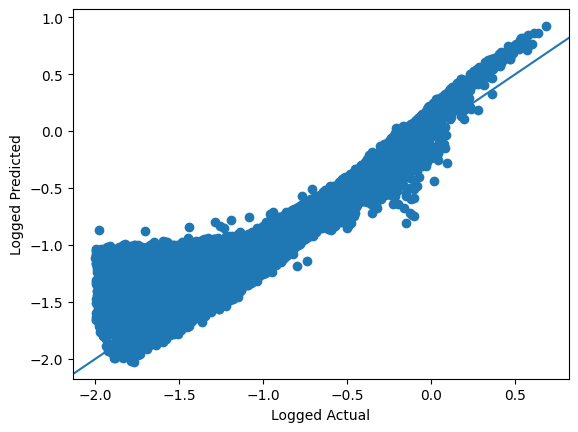

<Figure size 640x480 with 0 Axes>

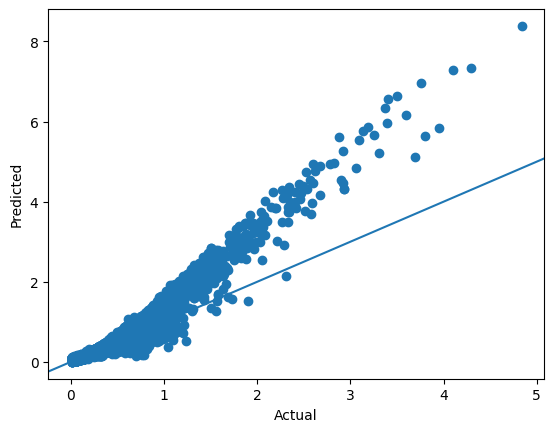

chl
Index(['rno', 'dtc', 't', 'bbp_s_440_555', 'a_bb_555', 'bbp_bp_555', 'EOF_5',
       'EOF_8'],
      dtype='object')
train: 118031 , test: 39343
y_pred: 39343 , y_test: 39343
coefs_mn: [-1.22029864e+00 -1.90273634e+00  6.07587918e-01 -2.95963976e+00
 -1.07671351e-02 -2.61673631e+00 -6.05786711e+00  1.09923133e+01]
coefs_std: [8.07020857e-03 9.92847361e-03 3.51746397e-03 4.23038268e-03
 2.73011192e-05 3.78259845e-03 1.49591883e-02 2.99793393e-02]
int: 15.980556897547809
mean r2: 0.8561827470844389
mean bias: 1.0000006545245883
mean mae: 1.2577857179960623


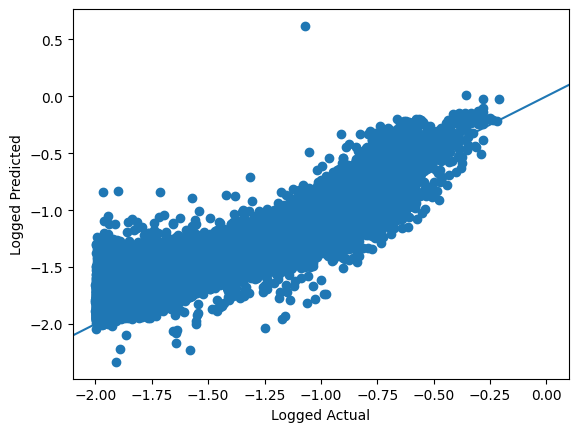

<Figure size 640x480 with 0 Axes>

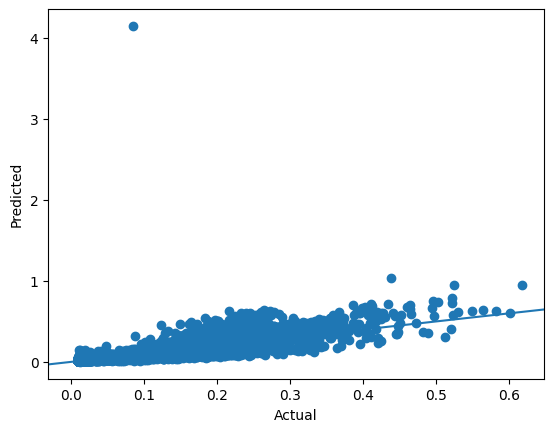

dia
Index(['pic', 'dtc', 'aph440_aph676', 'bbp_s_440_555', 'bbp_bp_555', 'EOF_1',
       'EOF_3', 'EOF_8'],
      dtype='object')
train: 154198 , test: 51399
y_pred: 51399 , y_test: 51399
coefs_mn: [  8.15572453   1.45592545  -0.61560188   2.32604544   1.57213345
   8.18659797 -16.19515856  14.75832404]
coefs_std: [0.02201259 0.00692368 0.00102793 0.00560359 0.0045862  0.03074972
 0.02293943 0.01988173]
int: -26.666097358878243
mean r2: 0.8906678646604965
mean bias: 1.0000064073218031
mean mae: 1.2994531684317991


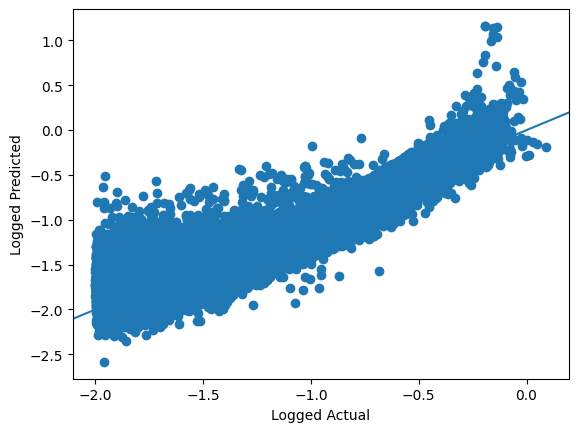

<Figure size 640x480 with 0 Axes>

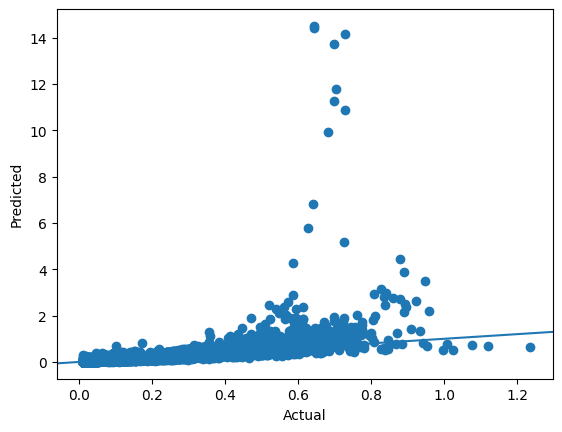

coc
Index(['aph440_aph676', 'aph440_ap440', 'bbp_s_440_555', 'a_bb_555',
       'bbp_bp_555', 'EOF_7'],
      dtype='object')
train: 131991 , test: 43996
y_pred: 43996 , y_test: 43996
coefs_mn: [ 0.21938381  1.11398512  2.85782547 -0.02550849  2.08564299 -0.89110975]
coefs_std: [4.34986286e-04 1.46200813e-03 4.95104915e-03 4.23296237e-05
 3.67786264e-03 1.06094801e-03]
int: -6.339371521408822
mean r2: 0.9667698019750294
mean bias: 1.000000980234848
mean mae: 1.1401230858267886


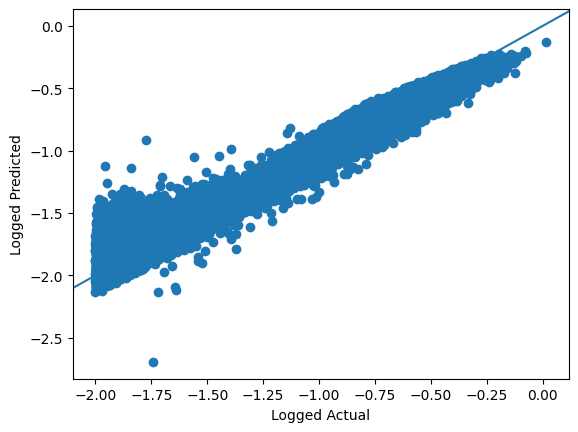

<Figure size 640x480 with 0 Axes>

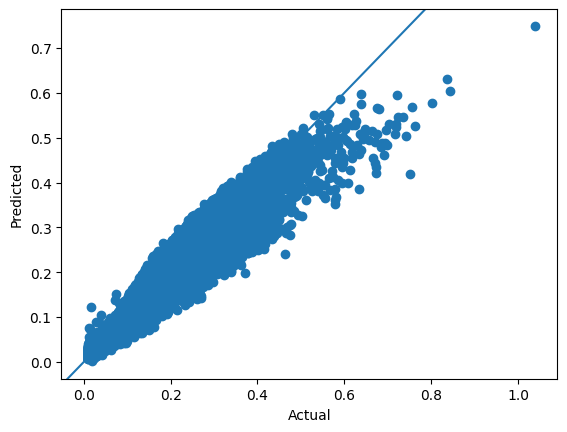

cya
Index(['pic', 'dtc', 'aph440_ap440', 'a_cdoc_443', 'EOF_1', 'EOF_4', 'EOF_5',
       'EOF_7'],
      dtype='object')
train: 166497 , test: 55498
y_pred: 55498 , y_test: 55498
coefs_mn: [ -9.02538239  -2.14976216   1.08929046  26.68105178  15.1285179
 -11.86157887 -30.56530926  28.29381103]
coefs_std: [0.077967   0.0431371  0.01826681 0.73710122 0.34417864 0.49231293
 0.37047199 0.52651221]
int: -4.524865444716952
mean r2: 0.9050458377768318
mean bias: 1.000000495494676
mean mae: 1.0990115305715213


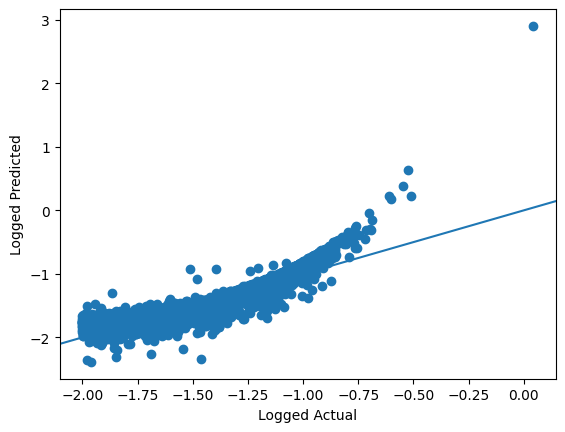

<Figure size 640x480 with 0 Axes>

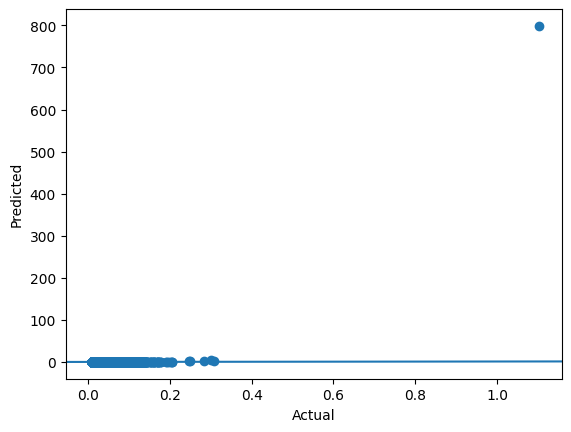

din
Index(['h', 'aph440_aph676', 'aph440_ap440', 'a_cdoc_443', 'bbp_s_440_555',
       'bbp_bp_555', 'EOF_7', 'EOF_8'],
      dtype='object')
train: 3603 , test: 1201
y_pred: 1201 , y_test: 1201
coefs_mn: [ -0.5904331   -0.32292671   5.32895451  15.37474123  -2.37710844
  -1.84610454   6.42483411 -18.55806684]
coefs_std: [0.0211992  0.00827119 0.07668956 0.88271986 0.04263101 0.03627765
 0.12066205 0.3147094 ]
int: -9.374451283896992
mean r2: 0.6239902591478719
mean bias: 1.000342301088741
mean mae: 1.5788865940278582


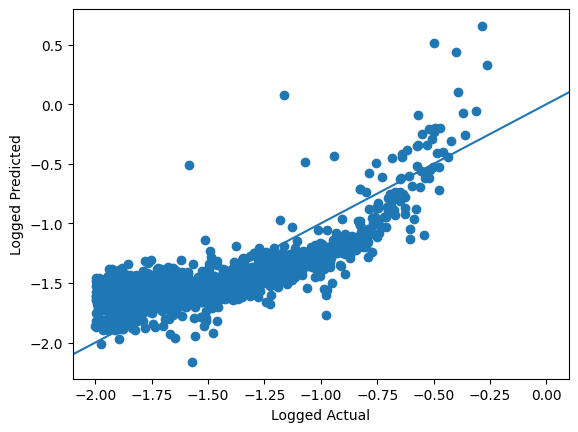

<Figure size 640x480 with 0 Axes>

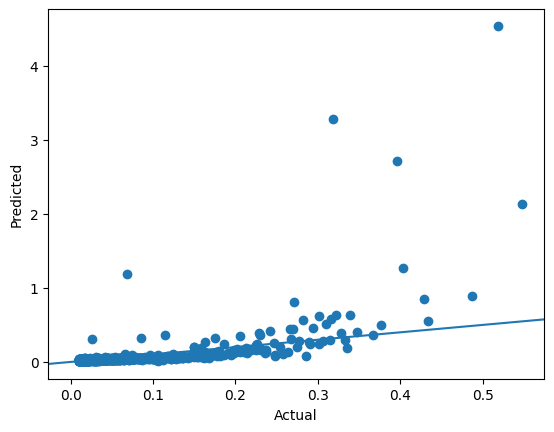

pha
Index(['pic', 'dtc', 'par', 'aph440_aph676', 'aph440_ap440', 'bbp_s_440_555',
       'a_bb_555', 'bbp_bp_555', 'EOF_4', 'EOF_5'],
      dtype='object')
train: 69424 , test: 23141
y_pred: 23141 , y_test: 23141
coefs_mn: [  8.19106178   2.00245903   0.24357439  -1.99172886   1.45373686
   1.10196937  -0.05458667   1.44859623 -11.2994185    9.76789575]
coefs_std: [0.07814753 0.01349197 0.00260258 0.02400367 0.00553422 0.01295205
 0.00031512 0.00879808 0.10765398 0.09938127]
int: -20.40657249223404
mean r2: 0.8963761374621165
mean bias: 0.9999995081454375
mean mae: 1.2828237617935434


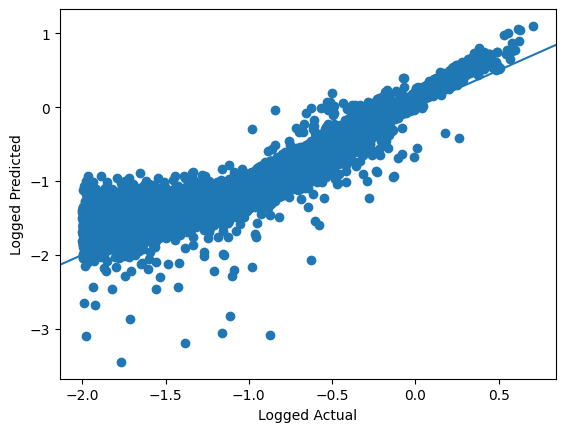

<Figure size 640x480 with 0 Axes>

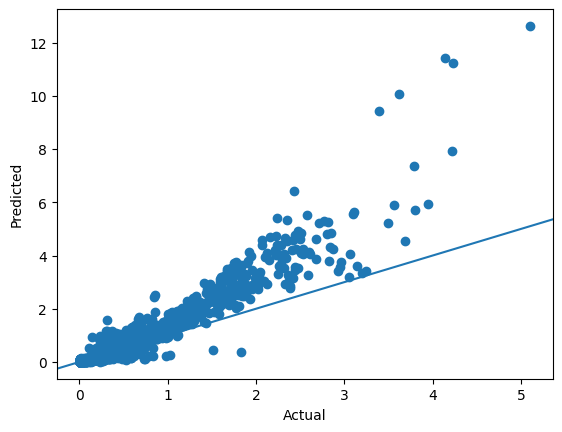

In [124]:
phyto_dats = [tot_dat, chl_dat, dia_dat, coc_dat, cya_dat, din_dat, pha_dat] 

vars_to_run = ['pic', 'irn', 'rno', 'h', 'sil', 'dtc', 'cdc', 't', 's', 'par', 'aph440_aph676',
       'aph440_ap440', 'a_cdoc_443', 'bbp_s_440_555', 'a_bb_555', 'bbp_bp_555',
       'EOF_1', 'EOF_2', 'EOF_3', 'EOF_4', 'EOF_5', 'EOF_6', 'EOF_7', 'EOF_8']

for i in range(len(phyto_dats)):
    MLR(phyto_dat=phyto_dats[i], vars=vars_to_run, output_name='all') 


## Remove env variables

tot
Index(['EOF_1', 'EOF_2', 'EOF_6', 'EOF_7', 'EOF_8'], dtype='object')
train: 354395 , test: 118131
y_pred: 118131 , y_test: 118131
coefs_mn: [ 55.8262 -76.0628  64.1612 -43.8323   1.9611]
coefs_std: [0.22255912 0.31806445 0.26477659 0.16782843 0.00991556]
int: 0.0
mean r2: 0.598241196316245
mean bias: 0.9995725138940168
mean mae: 1.40926416893132


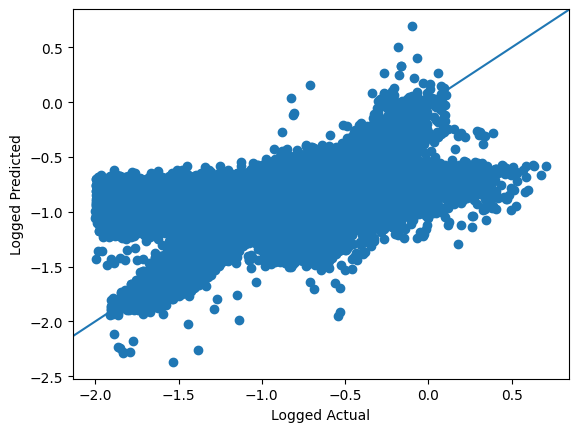

<Figure size 640x480 with 0 Axes>

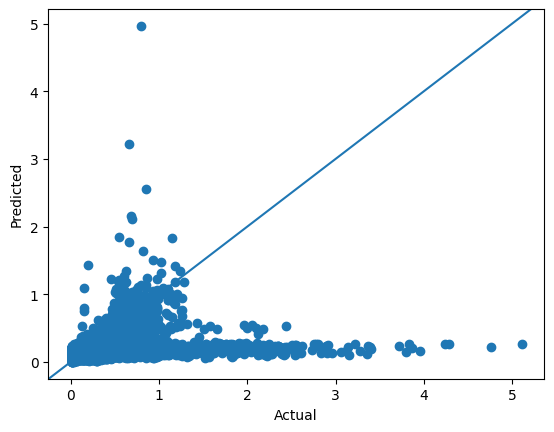

chl
Index(['EOF_1', 'EOF_3', 'EOF_5', 'EOF_6', 'EOF_8'], dtype='object')
train: 118031 , test: 39343
y_pred: 39343 , y_test: 39343
coefs_mn: [ 13.3078 -24.4132 -14.8884  18.7111  11.4994]
coefs_std: [0.1909212  0.34673293 0.19580456 0.2992037  0.09518982]
int: 0.0
mean r2: 0.43448760171710743
mean bias: 1.0002933893837604
mean mae: 1.6071448875241094


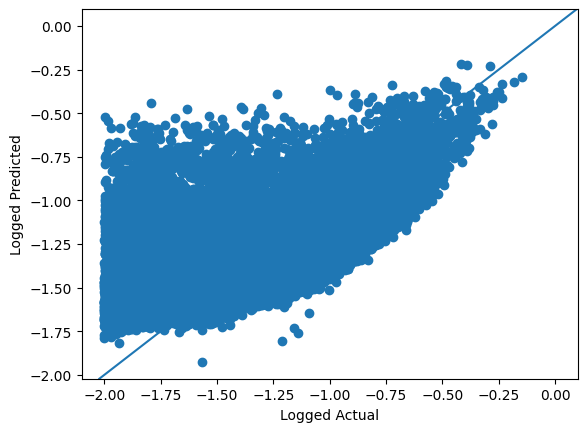

<Figure size 640x480 with 0 Axes>

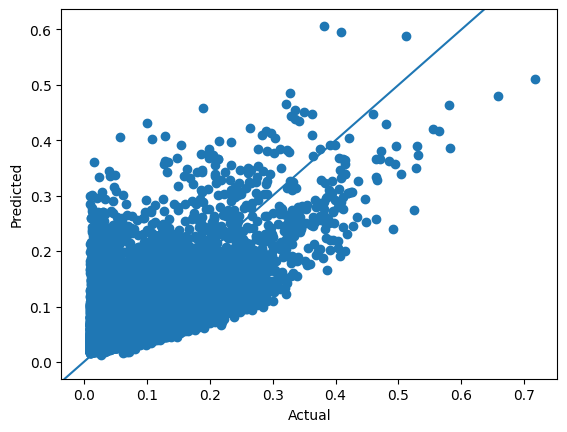

dia
Index(['EOF_1', 'EOF_2', 'EOF_5', 'EOF_6', 'EOF_8'], dtype='object')
train: 154198 , test: 51399
y_pred: 51399 , y_test: 51399
coefs_mn: [-23.3228  33.8708  12.3387 -22.1339   0.7167]
coefs_std: [0.61946147 0.80745842 0.37203467 0.46746591 0.15226431]
int: 0.0
mean r2: 0.35269607344334675
mean bias: 1.0006909960781303
mean mae: 2.1215190647769187


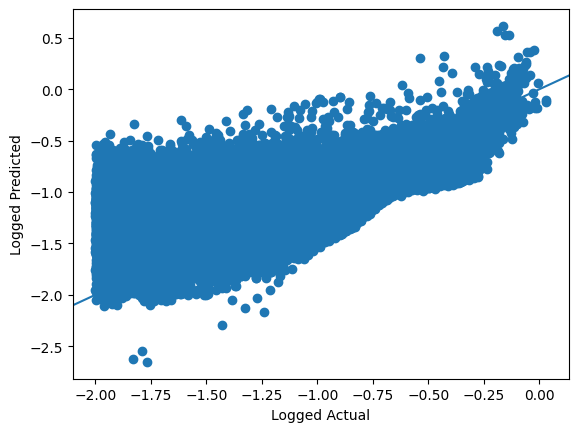

<Figure size 640x480 with 0 Axes>

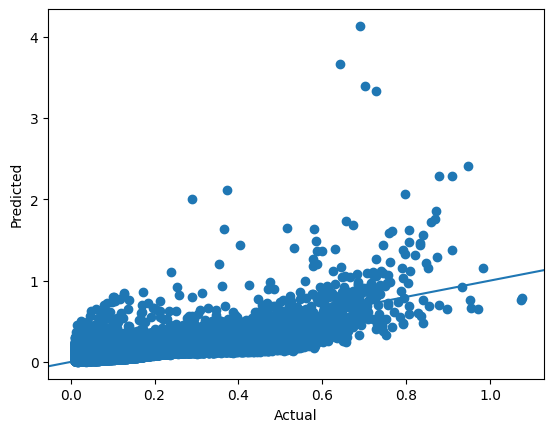

coc
Index(['EOF_1', 'EOF_4', 'EOF_5', 'EOF_6', 'EOF_8'], dtype='object')
train: 131991 , test: 43996
y_pred: 43996 , y_test: 43996
coefs_mn: [ 22.0998 -78.4548 -10.2025  53.0681  21.9195]
coefs_std: [0.18955835 0.62410748 0.08196577 0.44801954 0.11937063]
int: 0.0
mean r2: 0.3049556182915995
mean bias: 1.0001978418864212
mean mae: 2.0197848059543513


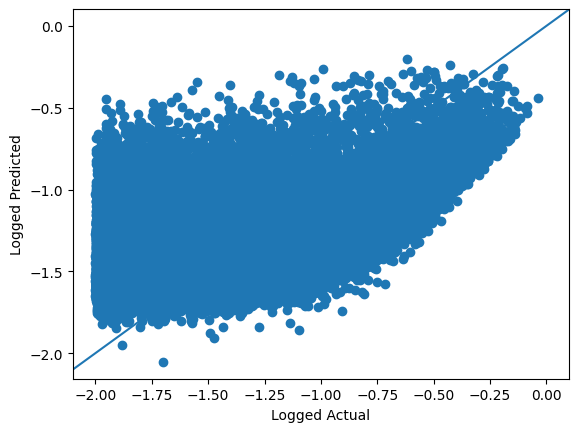

<Figure size 640x480 with 0 Axes>

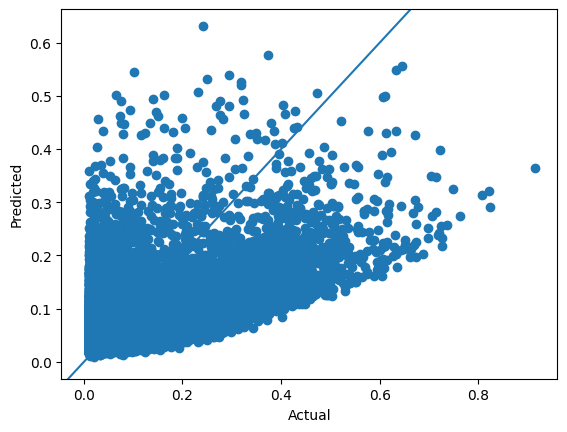

cya
Index(['EOF_1', 'EOF_2', 'EOF_4', 'EOF_5', 'EOF_6', 'EOF_8'], dtype='object')
train: 166497 , test: 55498
y_pred: 55498 , y_test: 55498
coefs_mn: [-33.969   62.9188 -36.386   21.2842  -8.2519  -6.4307]
coefs_std: [0.59437916 0.7615297  0.68781464 0.35986051 0.57442984 0.1471758 ]
int: 0.0
mean r2: 0.5978837805217688
mean bias: 0.9997389768406707
mean mae: 1.2374117160741367


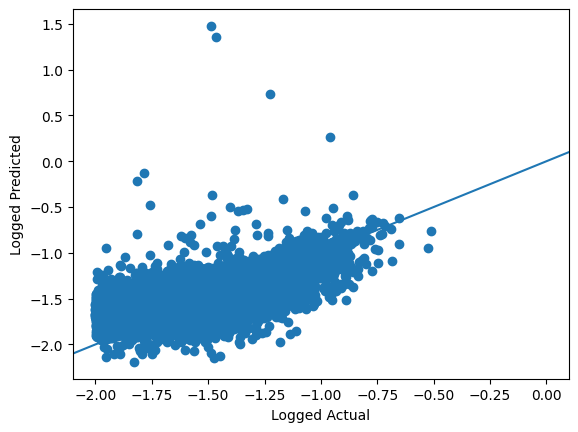

<Figure size 640x480 with 0 Axes>

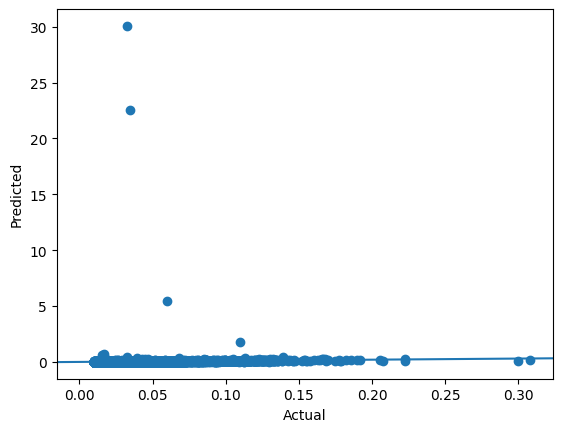

din
Index(['EOF_1', 'EOF_3', 'EOF_5', 'EOF_7', 'EOF_8'], dtype='object')
train: 3603 , test: 1201
y_pred: 1201 , y_test: 1201
coefs_mn: [-15.3905  24.1686  43.4745 -37.3669 -26.1749]
coefs_std: [0.79126184 1.19700083 2.41168339 2.13817323 1.09252067]
int: 0.0
mean r2: 0.16042975186958264
mean bias: 1.0001678008198642
mean mae: 2.0215426303652597


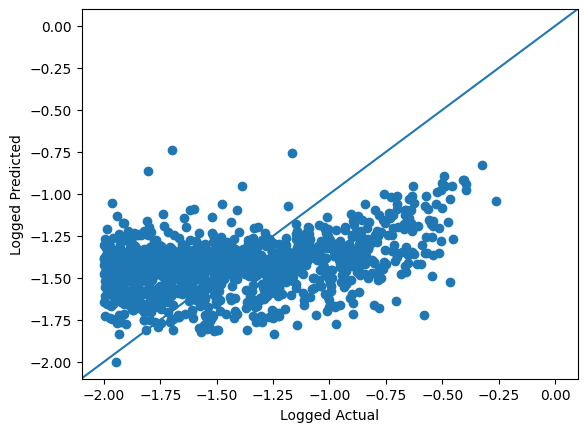

<Figure size 640x480 with 0 Axes>

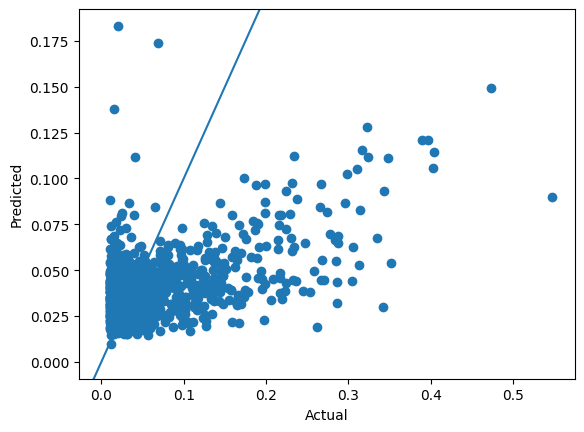

pha
Index(['EOF_1', 'EOF_4', 'EOF_5', 'EOF_7', 'EOF_8'], dtype='object')
train: 69424 , test: 23141
y_pred: 23141 , y_test: 23141
coefs_mn: [  8.685  -14.1947 -27.4991  28.3193   3.8484]
coefs_std: [0.11051995 0.22562845 0.32463384 0.3401817  0.15392241]
int: 0.0
mean r2: 0.3123391605633677
mean bias: 0.999691444111452
mean mae: 2.0689411459479268


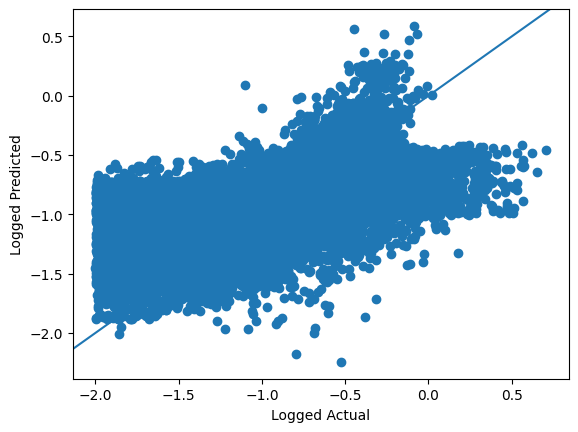

<Figure size 640x480 with 0 Axes>

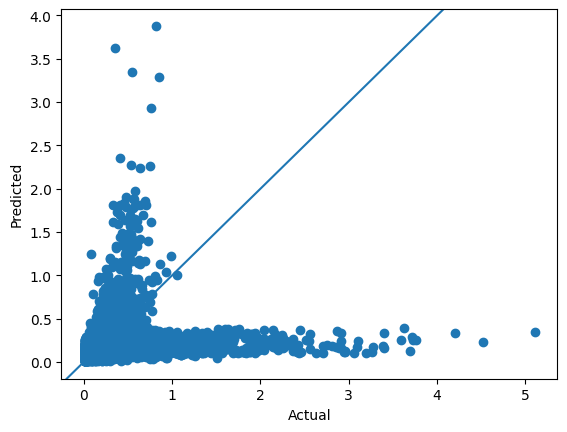

In [173]:
vars_to_run = ['EOF_1', 'EOF_2', 'EOF_3', 'EOF_4', 'EOF_5', 'EOF_6', 'EOF_7', 'EOF_8']

for i in range(len(phyto_dats)):
    MLR(phyto_dat=phyto_dats[i], vars=vars_to_run, output_name='no_envs') 


## Just env vars

tot
Index(['dtc', 's', 'par'], dtype='object')
train: 354395 , test: 118131
y_pred: 118131 , y_test: 118131
coefs_mn: [ 2.9569767  -0.34325957 -0.20655692]
coefs_std: [0.0068008  0.00115658 0.00104287]
int: -0.8358454
mean r2: 0.518862727521961
mean bias: 1.0000039253426545
mean mae: 1.4998649098447572


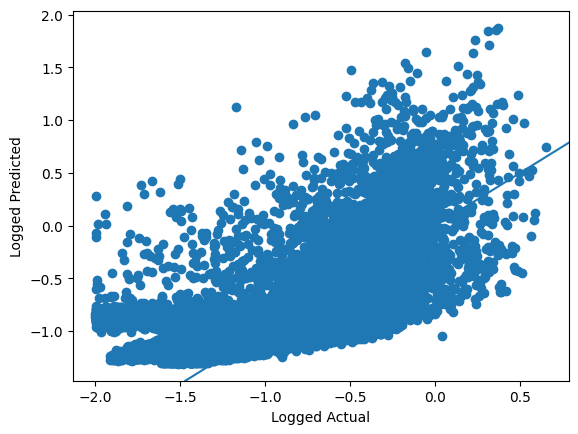

<Figure size 640x480 with 0 Axes>

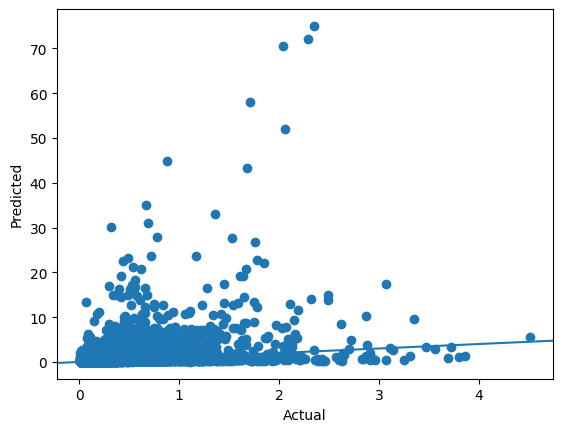

chl
Index(['rno', 'h', 'sil', 'dtc', 'cdc', 's'], dtype='object')
train: 118031 , test: 39343
y_pred: 39343 , y_test: 39343
coefs_mn: [-2.7524023  -0.47484222  1.5526893   3.5205188   2.2842617  -0.33161753]
coefs_std: [0.01423791 0.00460131 0.02036276 0.02033168 0.02018871 0.00250368]
int: -1.417154
mean r2: 0.4313807635256204
mean bias: 1.0000155276214184
mean mae: 1.6325394369671598


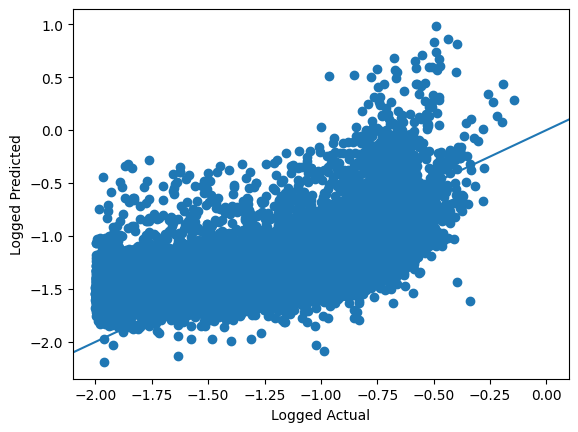

<Figure size 640x480 with 0 Axes>

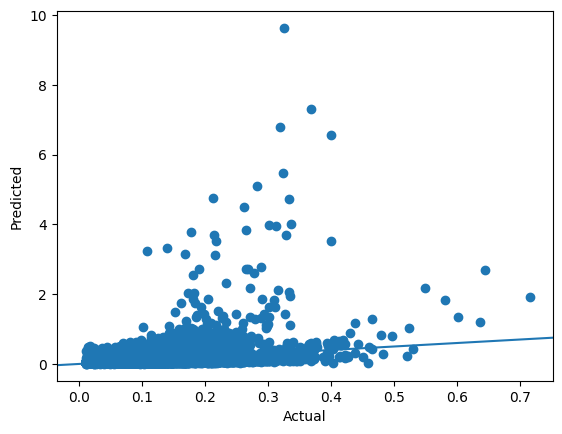

dia
Index(['irn', 'rno', 'sil', 'dtc'], dtype='object')
train: 154198 , test: 51399
y_pred: 51399 , y_test: 51399
coefs_mn: [-5.529509   3.3734505 -2.1821666  1.8683718]
coefs_std: [0.03590079 0.00789909 0.01141046 0.00868444]
int: -1.407737
mean r2: 0.4199638060692567
mean bias: 1.0000111682038753
mean mae: 1.971284579081492


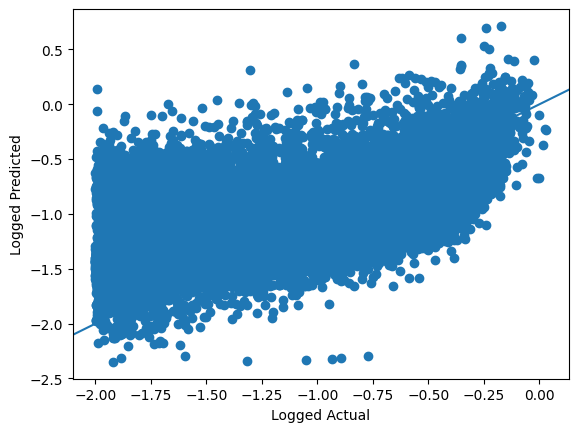

<Figure size 640x480 with 0 Axes>

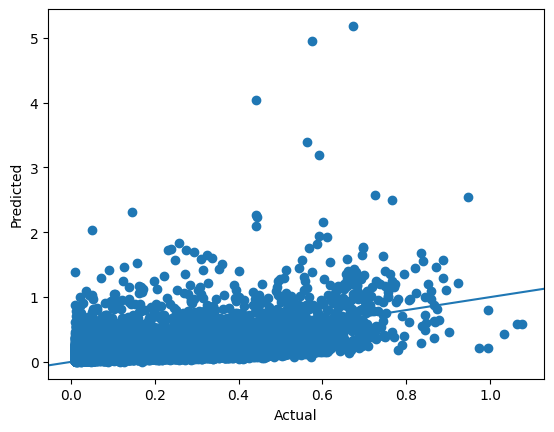

coc
Index(['rno', 'h', 'dtc', 'cdc', 't', 'par'], dtype='object')
train: 131991 , test: 43996
y_pred: 43996 , y_test: 43996
coefs_mn: [-3.73582    -0.4330487   2.9120972   2.5267048  -1.2430054  -0.47913834]
coefs_std: [0.01451085 0.00281935 0.01669055 0.02314014 0.00387536 0.00273815]
int: -0.47932374
mean r2: 0.45814979725699134
mean bias: 1.000008313621888
mean mae: 1.820531676693214


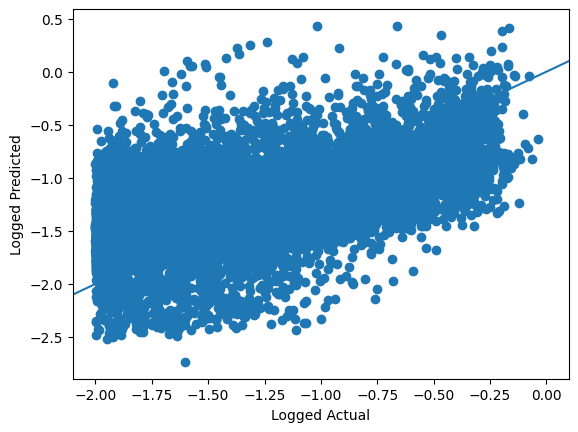

<Figure size 640x480 with 0 Axes>

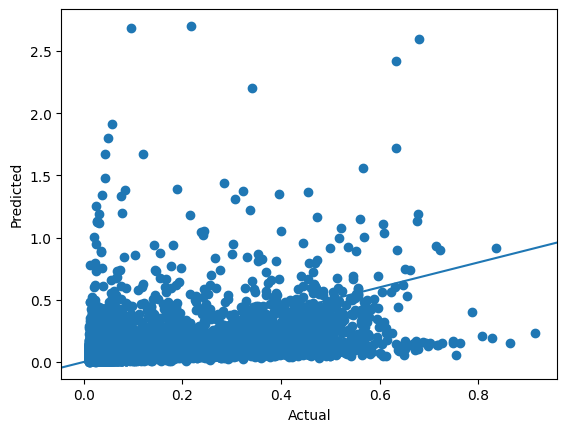

cya
Index(['rno', 'sil', 'cdc', 't', 'par'], dtype='object')
train: 166497 , test: 55498
y_pred: 55498 , y_test: 55498
coefs_mn: [-8.56916    -5.786958    1.5584155   0.34129715 -0.34625956]
coefs_std: [0.2635082  0.03276383 0.01370839 0.00240234 0.00224325]
int: -1.4645202
mean r2: 0.2545747954880311
mean bias: 0.9999955190582329
mean mae: 1.3620186816876418


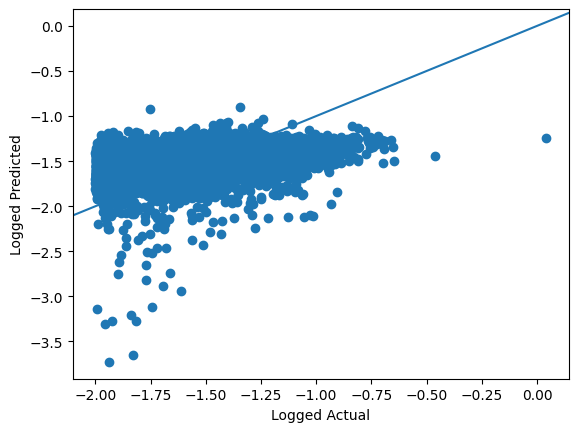

<Figure size 640x480 with 0 Axes>

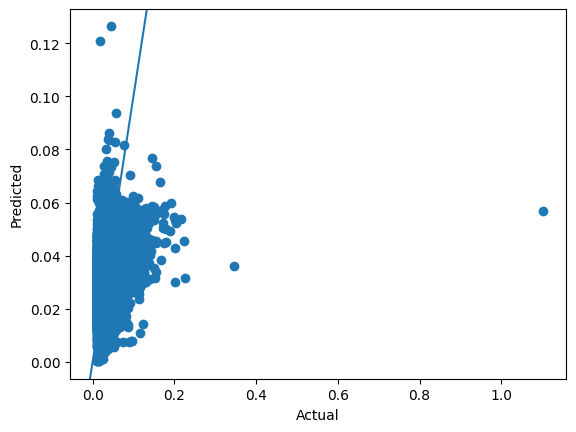

din
Index(['h', 'sil', 's'], dtype='object')
train: 3603 , test: 1201
y_pred: 1201 , y_test: 1201
coefs_mn: [-1.708792  -0.3412629 -0.3979785]
coefs_std: [0.0282513  0.0200006  0.01526772]
int: -1.0669789
mean r2: 0.20472097150041538
mean bias: 1.0003055803831058
mean mae: 1.9649305783601148


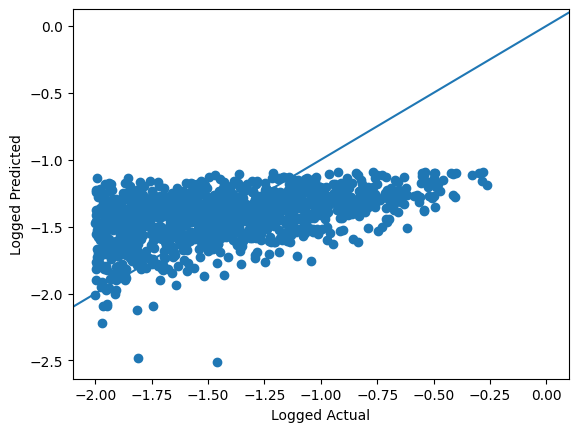

<Figure size 640x480 with 0 Axes>

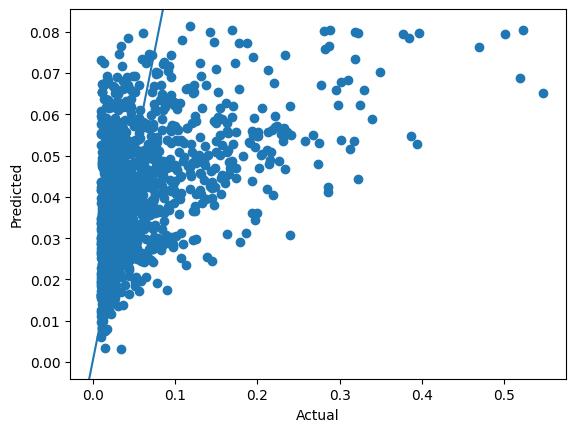

pha
Index(['pic', 'irn', 'rno', 'dtc', 't', 's'], dtype='object')
train: 69424 , test: 23141
y_pred: 23141 , y_test: 23141
coefs_mn: [  1.6367534 -19.9012      1.1971982   1.951584   -2.925901   -1.1249536]
coefs_std: [0.02001224 0.29521132 0.02072367 0.00764007 0.02432315 0.01914459]
int: -0.63084286
mean r2: 0.4448413240661651
mean bias: 1.0000309355244879
mean mae: 1.9245810788986302


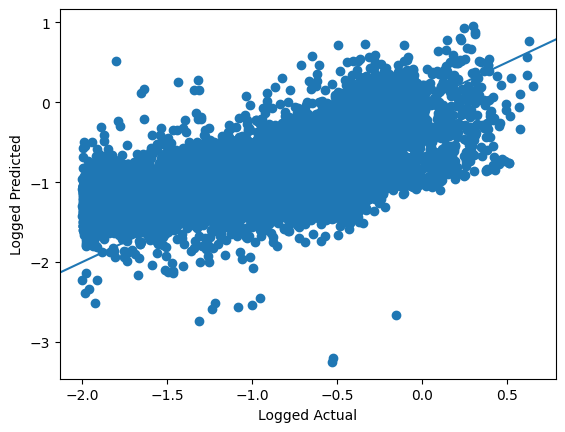

<Figure size 640x480 with 0 Axes>

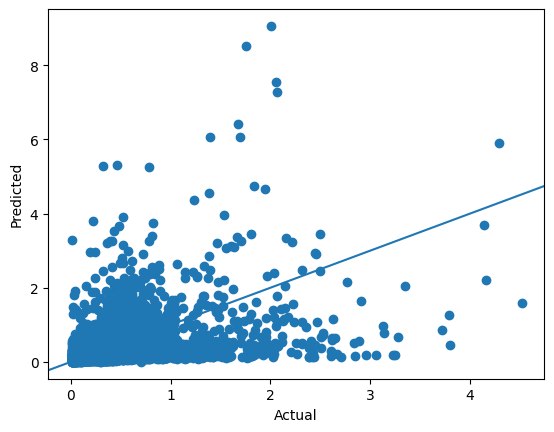

In [125]:
vars_to_run = ['pic', 'irn', 'rno', 'h', 'sil', 'dtc', 'cdc', 't', 's', 'par']

for i in range(len(phyto_dats)):
    MLR(phyto_dat=phyto_dats[i], vars=vars_to_run, output_name='just_env') 


## t + EOF vars

tot
Index(['t', 'EOF_1', 'EOF_2', 'EOF_5', 'EOF_6', 'EOF_7'], dtype='object')
train: 354395 , test: 118131
y_pred: 118131 , y_test: 118131
coefs_mn: [ -0.37230506  52.00986045 -81.49846046  13.90219839  84.11187446
 -67.99255394]
coefs_std: [0.00080042 0.28534013 0.4195681  0.03515179 0.3774359  0.25945828]
int: 19.723413735482946
mean r2: 0.6818790262934894
mean bias: 1.0000010533345354
mean mae: 1.3248310143136988


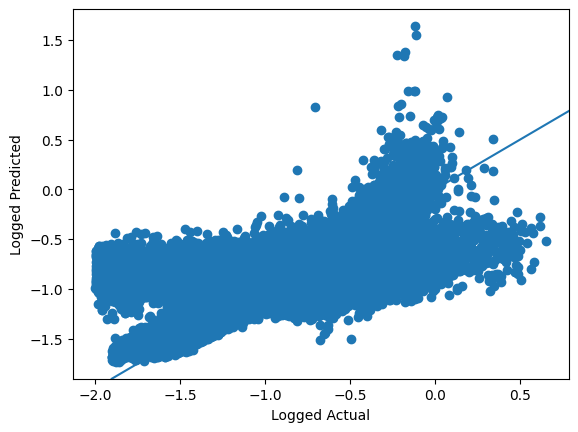

<Figure size 640x480 with 0 Axes>

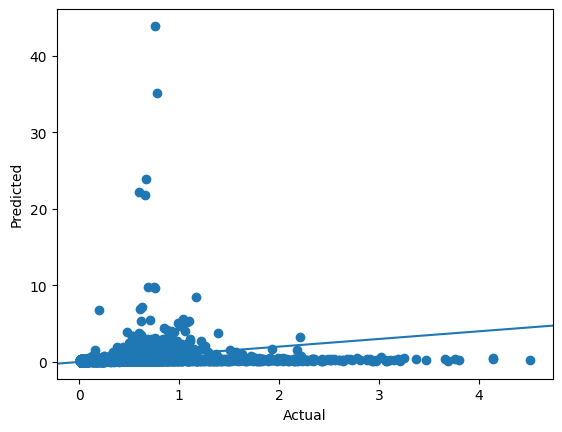

chl
Index(['t', 'EOF_1', 'EOF_3', 'EOF_4', 'EOF_5', 'EOF_6', 'EOF_8'], dtype='object')
train: 118031 , test: 39343
y_pred: 39343 , y_test: 39343
coefs_mn: [   1.55345835  114.07063383 -112.64923207 -138.63167226  -69.3177193
  177.70749149   54.81155538]
coefs_std: [0.00491077 0.55099866 1.0295203  1.23526989 0.45450654 0.80896586
 0.19510604]
int: -51.16418493230797
mean r2: 0.6082779482384719
mean bias: 1.0000051775143282
mean mae: 1.4747821414663418


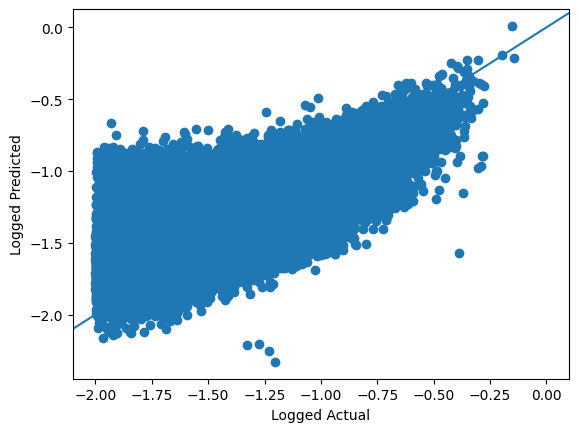

<Figure size 640x480 with 0 Axes>

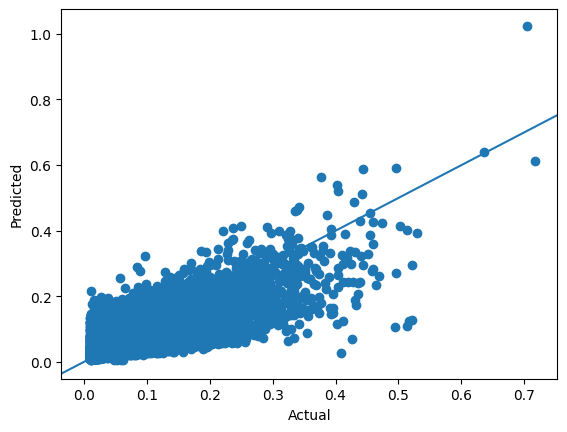

dia
Index(['t', 'EOF_1', 'EOF_2', 'EOF_5', 'EOF_8'], dtype='object')
train: 154198 , test: 51399
y_pred: 51399 , y_test: 51399
coefs_mn: [-1.01579235 11.25752564 -9.98718544 -5.37134954  9.08850249]
coefs_std: [0.00184125 0.07123274 0.05065908 0.00785441 0.02250783]
int: -7.4409896431860645
mean r2: 0.5885021246591762
mean bias: 1.000006439767007
mean mae: 1.7237670750839595


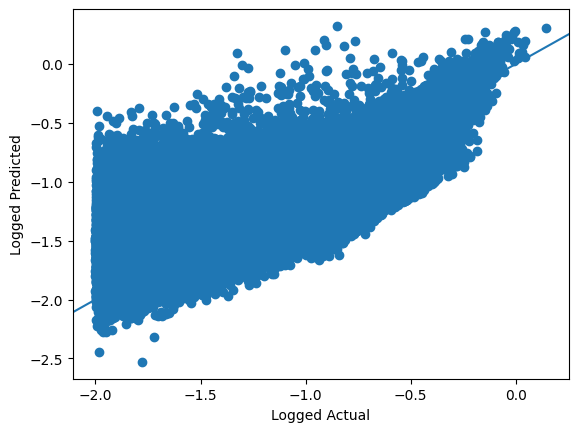

<Figure size 640x480 with 0 Axes>

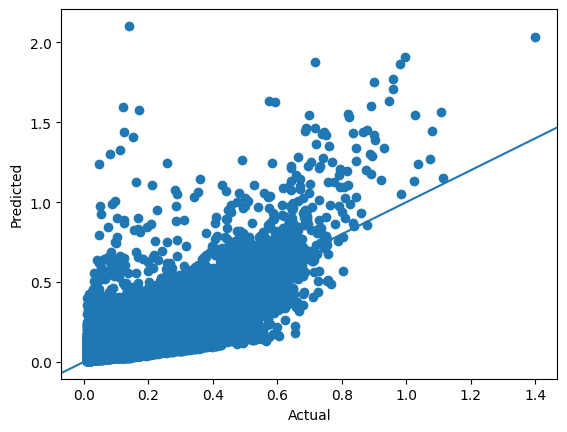

coc
Index(['EOF_3', 'EOF_4', 'EOF_7', 'EOF_8'], dtype='object')
train: 131991 , test: 43996
y_pred: 43996 , y_test: 43996
coefs_mn: [ 108.52110641 -168.60711674   45.88762582   23.89927354]
coefs_std: [0.92184552 1.39379846 0.39413256 0.14144043]
int: -9.57974437255032
mean r2: 0.30418305256838957
mean bias: 1.000012706298647
mean mae: 2.0166897946251656


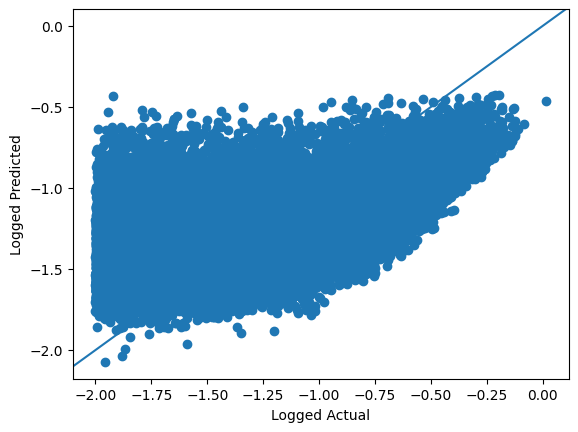

<Figure size 640x480 with 0 Axes>

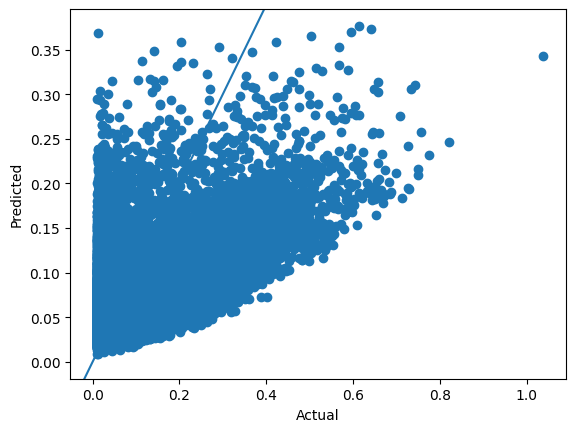

cya
Index(['EOF_1', 'EOF_2', 'EOF_4', 'EOF_5', 'EOF_6', 'EOF_8'], dtype='object')
train: 166497 , test: 55498
y_pred: 55498 , y_test: 55498
coefs_mn: [ -99.89776009   90.00115176   88.48894053   42.59551031 -104.75430004
  -29.26297474]
coefs_std: [5.07244081 3.54985605 6.23005691 1.9925295  5.96476838 1.4488394 ]
int: 30.219107440546264
mean r2: 0.6813378296957302
mean bias: 1.0000173888177277
mean mae: 1.2077465763265802


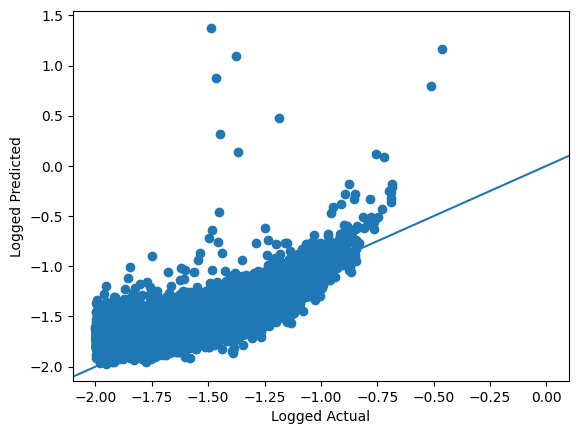

<Figure size 640x480 with 0 Axes>

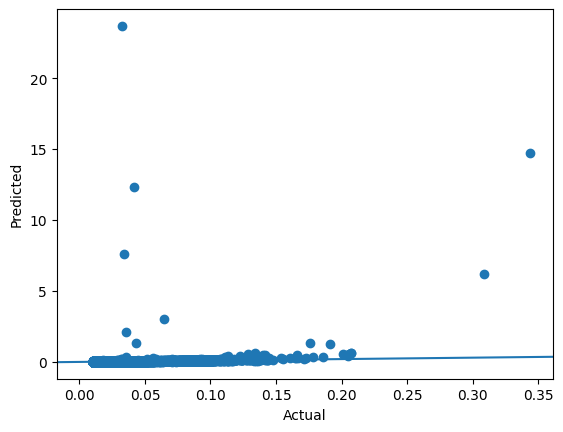

din
Index(['EOF_1', 'EOF_3', 'EOF_5', 'EOF_7', 'EOF_8'], dtype='object')
train: 3603 , test: 1201
y_pred: 1201 , y_test: 1201
coefs_mn: [-50.10501469  62.2835941   99.74543372 -86.41845918 -45.92709724]
coefs_std: [3.22900494 3.65483427 5.65319066 4.94597651 2.11301015]
int: 32.13992638359891
mean r2: 0.1676005034470558
mean bias: 1.0002520208183254
mean mae: 2.0146863268343265


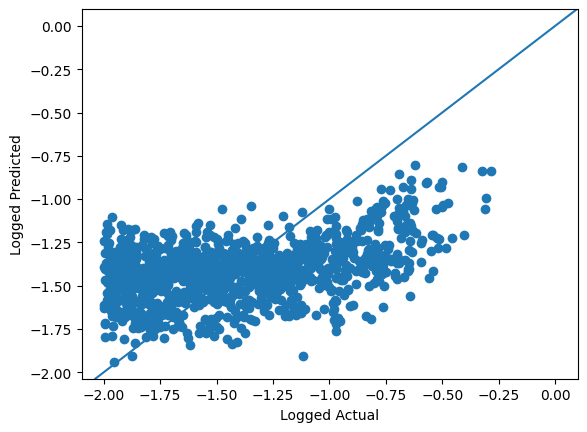

<Figure size 640x480 with 0 Axes>

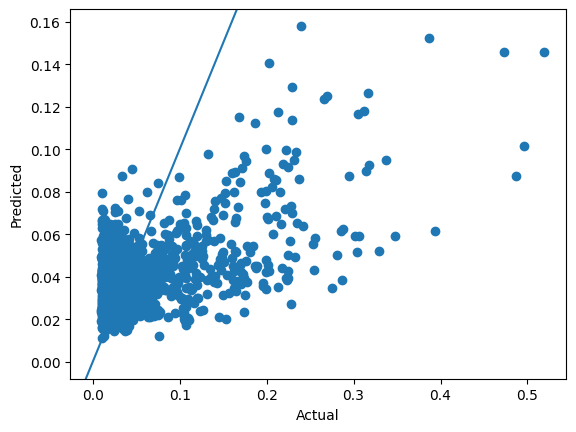

pha
Index(['EOF_1', 'EOF_4', 'EOF_5', 'EOF_7', 'EOF_8'], dtype='object')
train: 69424 , test: 23141
y_pred: 23141 , y_test: 23141
coefs_mn: [-105.26831006  172.23712841  149.06471758 -179.13941475  -74.21133891]
coefs_std: [0.83020293 1.36756231 1.30717899 1.5322679  0.5803574 ]
int: 122.12987215758092
mean r2: 0.38611474796893885
mean bias: 1.0000352219404882
mean mae: 1.9860389764863038


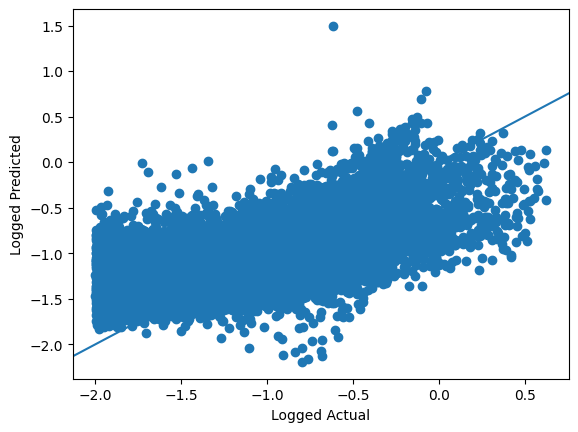

<Figure size 640x480 with 0 Axes>

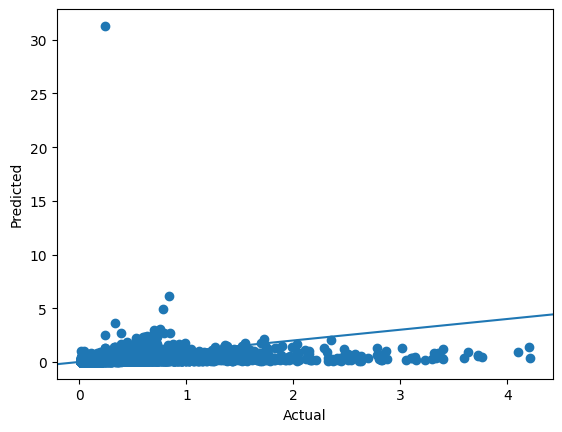

In [128]:
vars_to_run = ['t', 'EOF_1', 'EOF_2', 'EOF_3', 'EOF_4', 'EOF_5', 'EOF_6', 'EOF_7', 'EOF_8']

for i in range(len(phyto_dats)):
    MLR(phyto_dat=phyto_dats[i], vars=vars_to_run, output_name='t_EOFs') 


## s + EOFs

tot
Index(['s', 'EOF_1', 'EOF_2', 'EOF_6', 'EOF_7', 'EOF_8'], dtype='object')
train: 354395 , test: 118131
y_pred: 118131 , y_test: 118131
coefs_mn: [  -0.37944105   85.68914959 -123.71025608  109.45871486  -72.98990786
    4.15893487]
coefs_std: [0.0008147  0.25666848 0.37716949 0.33243638 0.21340645 0.01103595]
int: 13.532372207816401
mean r2: 0.6477029035017552
mean bias: 1.0000011840894256
mean mae: 1.3659057325237667


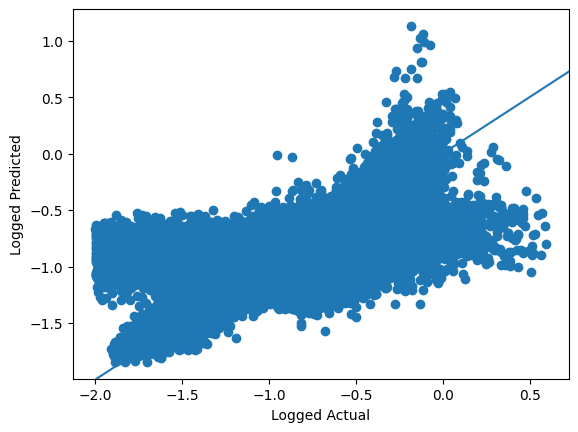

<Figure size 640x480 with 0 Axes>

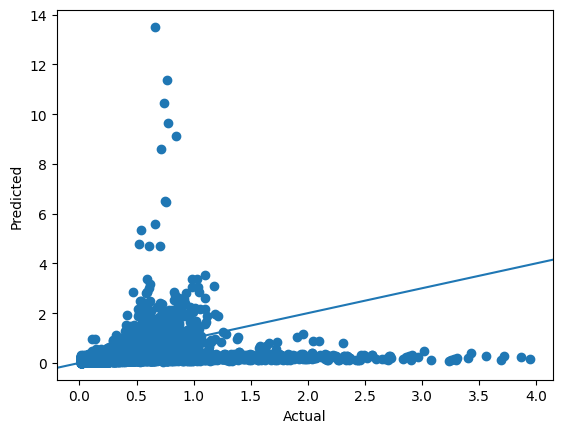

chl
Index(['EOF_1', 'EOF_3', 'EOF_5', 'EOF_6', 'EOF_8'], dtype='object')
train: 118031 , test: 39343
y_pred: 39343 , y_test: 39343
coefs_mn: [ 105.69175486 -176.93587312  -87.98977015  136.84488054   41.56887272]
coefs_std: [0.58462577 0.96517964 0.4672028  0.75228143 0.19503099]
int: -45.147247563854734
mean r2: 0.4794328355590509
mean bias: 1.0000121280459047
mean mae: 1.567549080156934


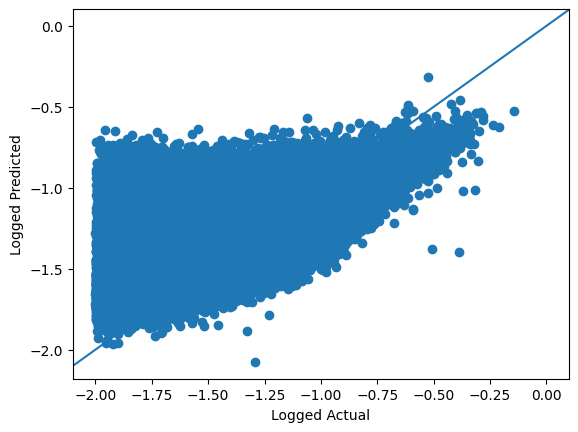

<Figure size 640x480 with 0 Axes>

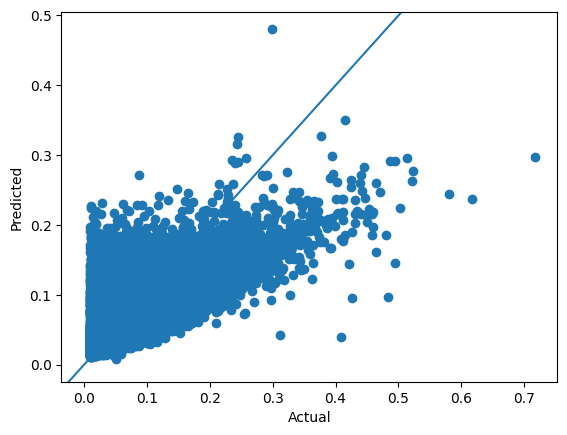

dia
Index(['s', 'EOF_1', 'EOF_2', 'EOF_5', 'EOF_8'], dtype='object')
train: 154198 , test: 51399
y_pred: 51399 , y_test: 51399
coefs_mn: [ -0.89918213  15.87256993 -12.12322057  -5.42455274   6.55581417]
coefs_std: [0.00325154 0.08688374 0.0626705  0.00879658 0.02344323]
int: -14.660406008281239
mean r2: 0.4667567669108349
mean bias: 1.000006746167196
mean mae: 1.9225425556959084


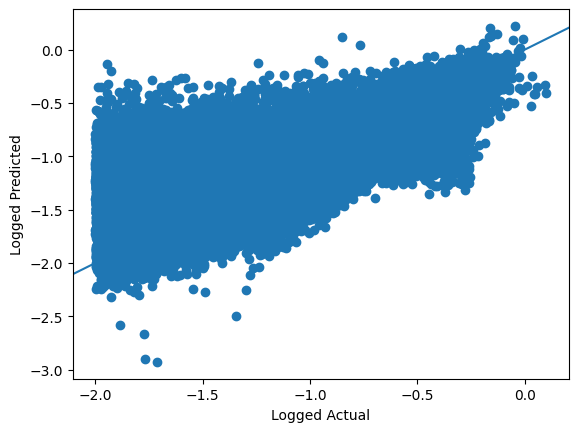

<Figure size 640x480 with 0 Axes>

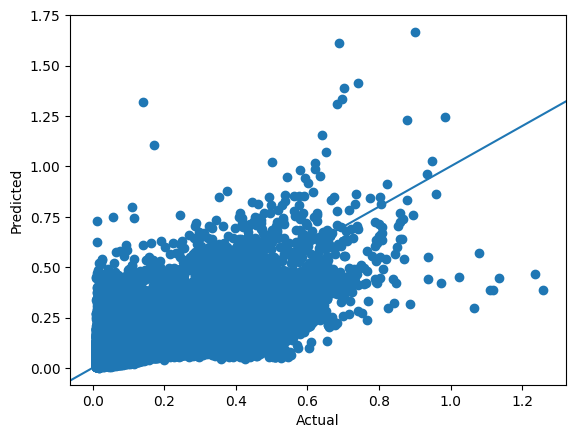

coc
Index(['EOF_1', 'EOF_4', 'EOF_5', 'EOF_6', 'EOF_8'], dtype='object')
train: 131991 , test: 43996
y_pred: 43996 , y_test: 43996
coefs_mn: [  45.89101613 -145.69269703  -15.06659933   96.86778393   31.67299163]
coefs_std: [0.38458795 1.12201494 0.10277316 0.75130316 0.17558592]
int: -15.130024126791874
mean r2: 0.3112294420548908
mean bias: 1.0000117744006027
mean mae: 2.0115849523019436


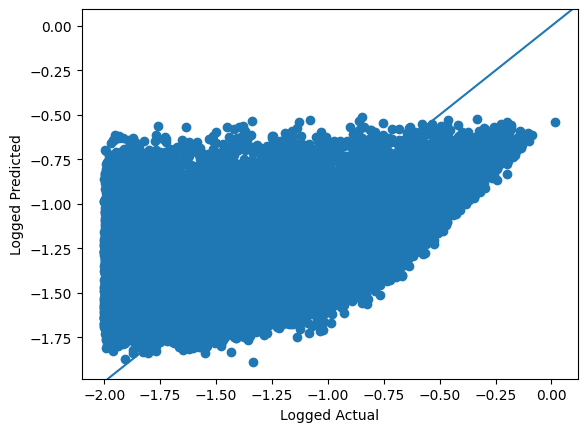

<Figure size 640x480 with 0 Axes>

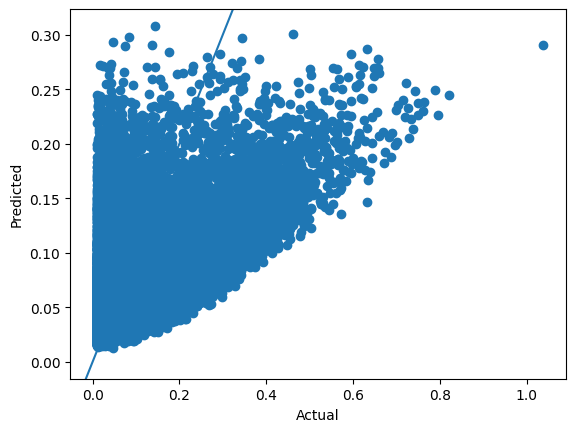

cya
Index(['EOF_1', 'EOF_2', 'EOF_4', 'EOF_5', 'EOF_6', 'EOF_8'], dtype='object')
train: 166497 , test: 55498
y_pred: 55498 , y_test: 55498
coefs_mn: [ -99.90281167   90.00551263   88.49297115   42.59756685 -104.75917113
  -29.26412597]
coefs_std: [5.11126185 3.59935022 6.22471368 2.01058079 5.98465607 1.45394595]
int: 30.221067405474404
mean r2: 0.6813084063587066
mean bias: 1.0000189696366157
mean mae: 1.2077468852131785


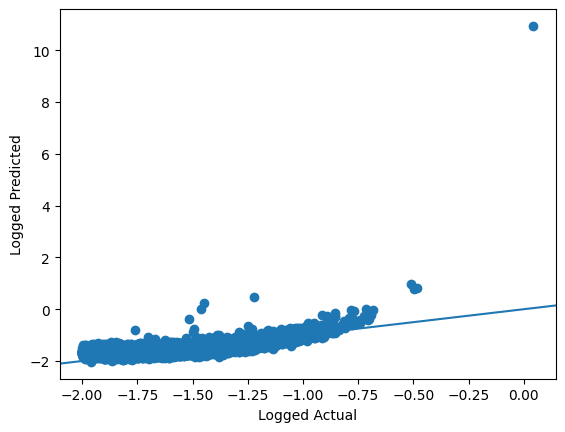

<Figure size 640x480 with 0 Axes>

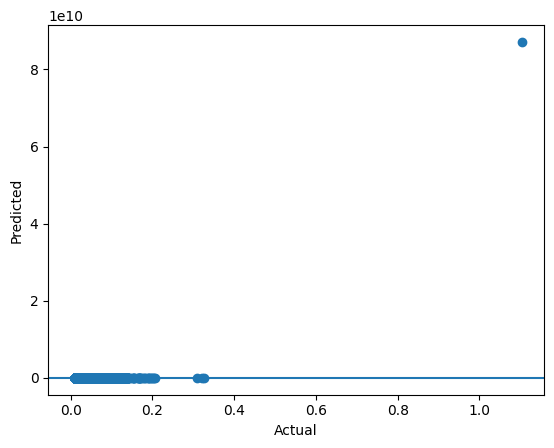

din
Index(['s', 'EOF_2', 'EOF_5', 'EOF_6', 'EOF_7', 'EOF_8'], dtype='object')
train: 3603 , test: 1201
y_pred: 1201 , y_test: 1201
coefs_mn: [  -0.39316046  -26.78684485   72.91874251   77.19267364 -106.67596239
  -30.89167061]
coefs_std: [0.01621105 2.13874035 5.03240595 5.55868108 7.55611324 1.6611426 ]
int: 29.197336381211716
mean r2: 0.19450316655706854
mean bias: 1.000294616883353
mean mae: 1.9899511321631085


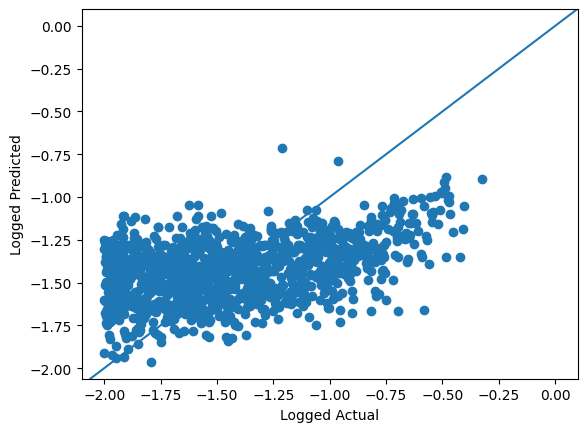

<Figure size 640x480 with 0 Axes>

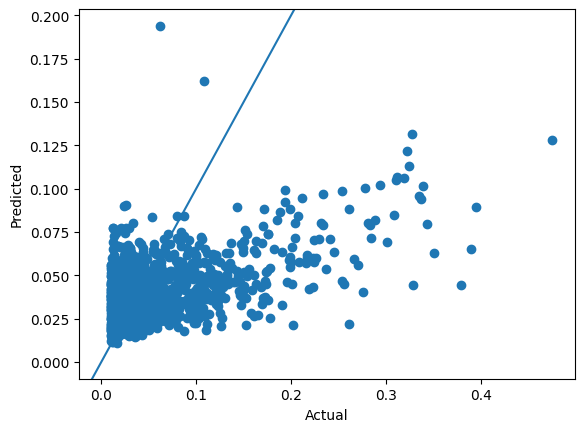

pha
Index(['EOF_1', 'EOF_4', 'EOF_5', 'EOF_7', 'EOF_8'], dtype='object')
train: 69424 , test: 23141
y_pred: 23141 , y_test: 23141
coefs_mn: [-105.26781662  172.2362746   149.06378716 -179.13836259  -74.21092269]
coefs_std: [0.79178814 1.29950986 1.22589722 1.44402617 0.54183544]
int: 122.12946651158435
mean r2: 0.38611728681663976
mean bias: 1.0000306152562122
mean mae: 1.986034337063794


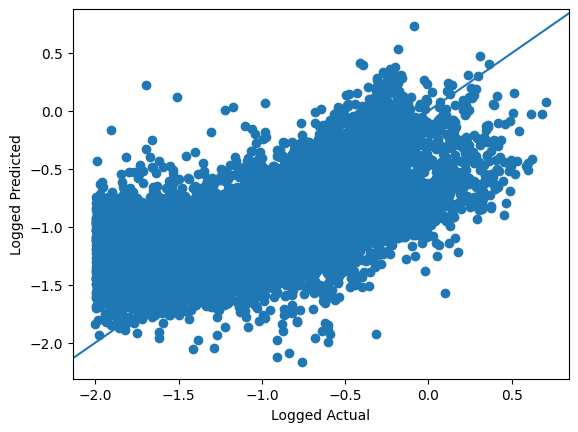

<Figure size 640x480 with 0 Axes>

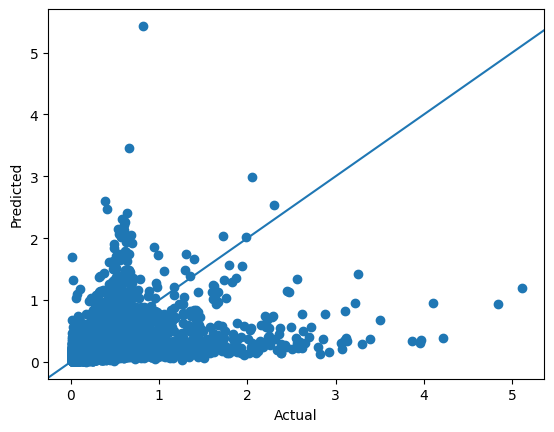

In [129]:
vars_to_run = ['s', 'EOF_1', 'EOF_2', 'EOF_3', 'EOF_4', 'EOF_5', 'EOF_6', 'EOF_7', 'EOF_8']

for i in range(len(phyto_dats)):
    MLR(phyto_dat=phyto_dats[i], vars=vars_to_run, output_name='s_EOFs') 


## PAR + EOFs

tot
Index(['par', 'EOF_1', 'EOF_2', 'EOF_6', 'EOF_7', 'EOF_8'], dtype='object')
train: 354395 , test: 118131
y_pred: 118131 , y_test: 118131
coefs_mn: [  -0.27068096   87.26025946 -126.96800638  113.62161058  -75.71984435
    4.21122434]
coefs_std: [0.00097321 0.27894771 0.40626906 0.35424605 0.22755506 0.01191386]
int: 16.536105320832238
mean r2: 0.6512269315342235
mean bias: 1.0000018576883989
mean mae: 1.345566860618132


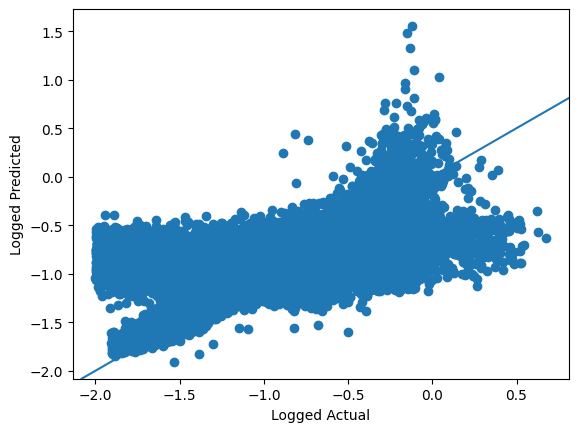

<Figure size 640x480 with 0 Axes>

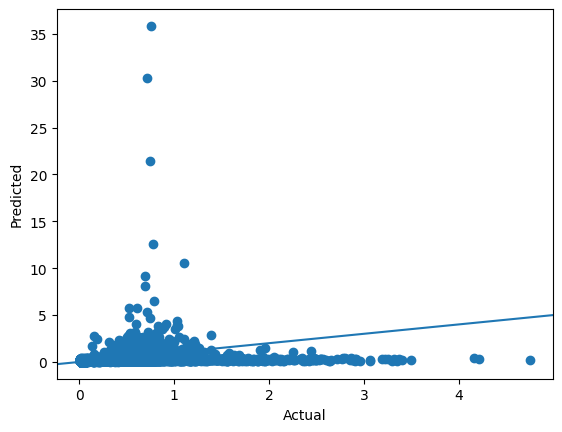

chl
Index(['EOF_1', 'EOF_3', 'EOF_5', 'EOF_6', 'EOF_8'], dtype='object')
train: 118031 , test: 39343
y_pred: 39343 , y_test: 39343
coefs_mn: [ 105.69153332 -176.93551125  -87.9896004   136.84460711   41.56879824]
coefs_std: [0.53607033 0.88362225 0.42716982 0.68656641 0.18100783]
int: -45.14712688268965
mean r2: 0.4794360286066558
mean bias: 1.0000096731651704
mean mae: 1.567548669777418


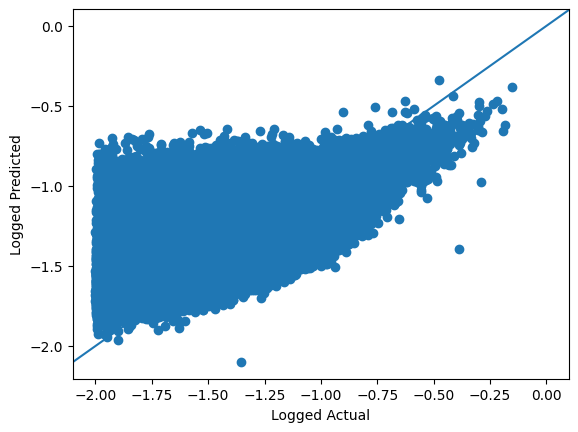

<Figure size 640x480 with 0 Axes>

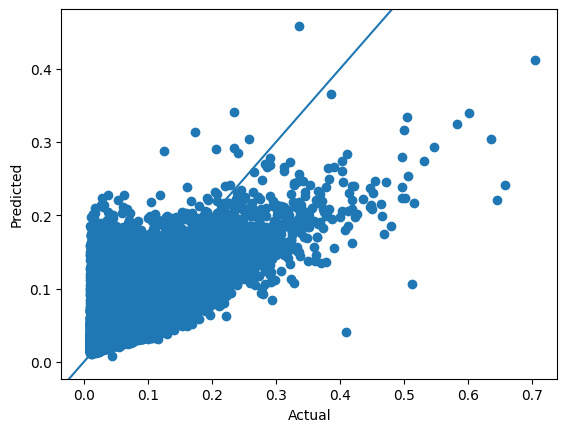

dia
Index(['par', 'EOF_1', 'EOF_2', 'EOF_5', 'EOF_6', 'EOF_8'], dtype='object')
train: 154198 , test: 51399
y_pred: 51399 , y_test: 51399
coefs_mn: [  -0.45097341  150.71584058 -178.34426026  -78.18961635   90.39998808
   31.85520023]
coefs_std: [0.00191349 1.11042331 1.37715665 0.59821701 0.74771258 0.22019628]
int: -37.01873110133826
mean r2: 0.44626367912016773
mean bias: 1.0000080969750464
mean mae: 1.9515863544239804


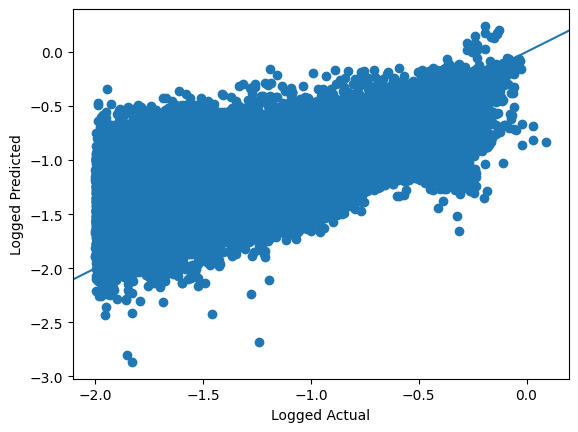

<Figure size 640x480 with 0 Axes>

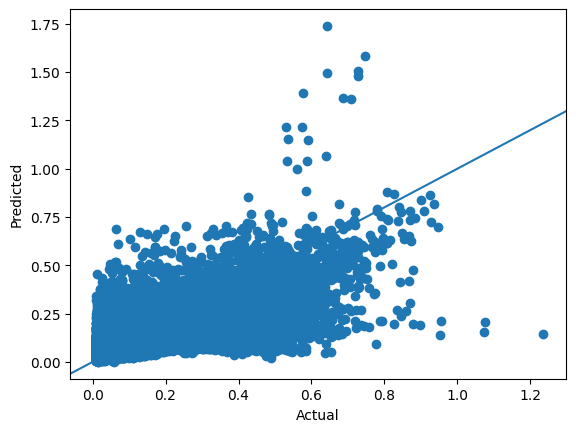

coc
Index(['EOF_1', 'EOF_4', 'EOF_5', 'EOF_6', 'EOF_8'], dtype='object')
train: 131991 , test: 43996
y_pred: 43996 , y_test: 43996
coefs_mn: [  45.89043746 -145.69104992  -15.06645995   96.86668978   31.67275283]
coefs_std: [0.4030119  1.17287379 0.10685512 0.78400117 0.1854093 ]
int: -15.129708545935616
mean r2: 0.31123084447356214
mean bias: 1.0000131541383814
mean mae: 2.0115852453224634


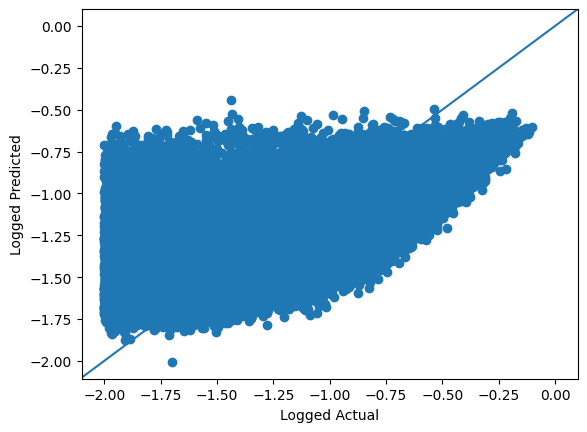

<Figure size 640x480 with 0 Axes>

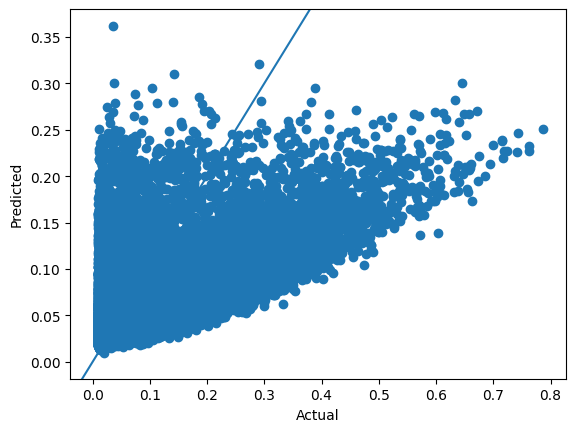

cya
Index(['EOF_1', 'EOF_2', 'EOF_4', 'EOF_5', 'EOF_6', 'EOF_8'], dtype='object')
train: 166497 , test: 55498
y_pred: 55498 , y_test: 55498
coefs_mn: [ -99.90156457   90.00385727   88.49316633   42.59681477 -104.75834256
  -29.26390471]
coefs_std: [5.12604122 3.61527812 6.23112164 2.02284601 6.00173913 1.4606582 ]
int: 30.221038727720526
mean r2: 0.6813168861495863
mean bias: 1.000019441243106
mean mae: 1.2077465078929857


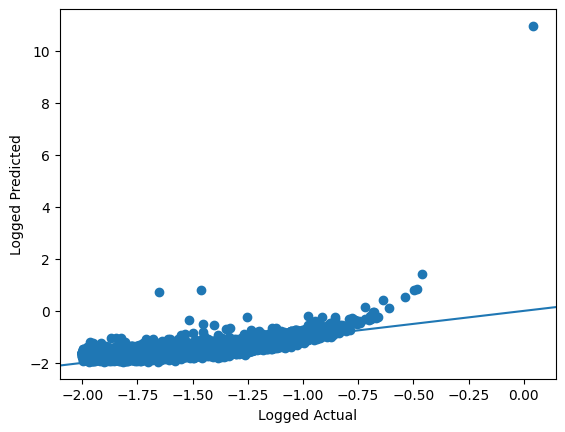

<Figure size 640x480 with 0 Axes>

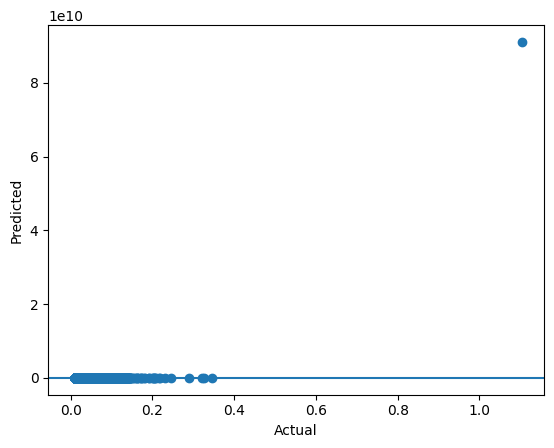

din
Index(['EOF_1', 'EOF_3', 'EOF_5', 'EOF_7', 'EOF_8'], dtype='object')
train: 3603 , test: 1201
y_pred: 1201 , y_test: 1201
coefs_mn: [-50.11214723  62.29179034  99.75745554 -86.42874192 -45.93213062]
coefs_std: [3.31842087 3.76055033 5.80850298 5.08058542 2.17259053]
int: 32.14611377044992
mean r2: 0.16752546951987426
mean bias: 1.0002954362747167
mean mae: 2.014777217673411


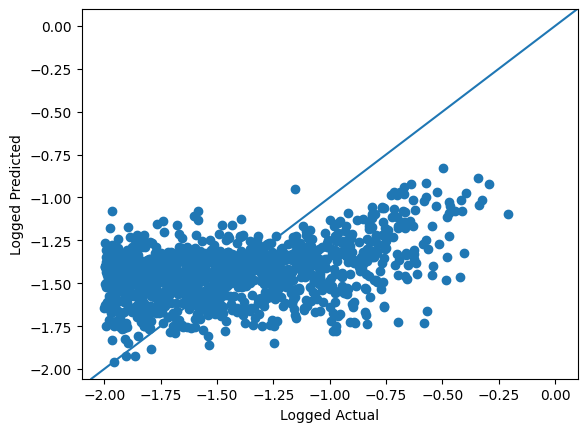

<Figure size 640x480 with 0 Axes>

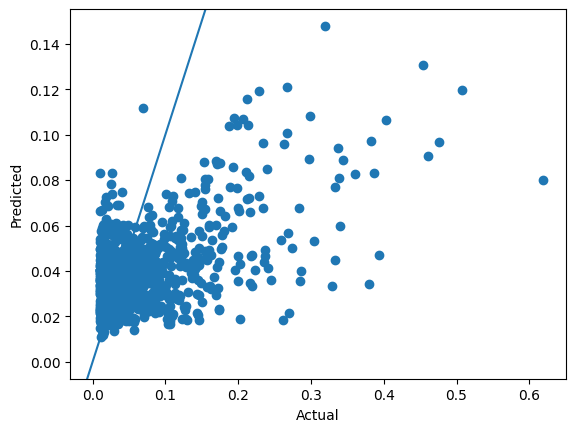

pha
Index(['par', 'EOF_1', 'EOF_4', 'EOF_5', 'EOF_7', 'EOF_8'], dtype='object')
train: 69424 , test: 23141
y_pred: 23141 , y_test: 23141
coefs_mn: [   0.63530234  -94.34104803  152.45553328  132.70775173 -158.27459888
  -66.13317412]
coefs_std: [0.00532634 0.7611554  1.25126412 1.18241216 1.39271852 0.52264245]
int: 107.816555170362
mean r2: 0.420799247030901
mean bias: 1.0000259416670443
mean mae: 1.9564948124518136


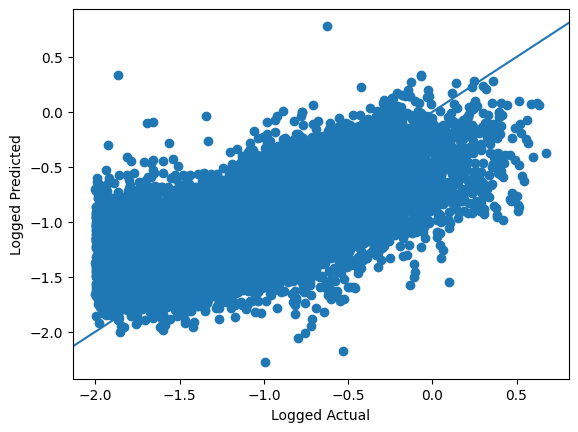

<Figure size 640x480 with 0 Axes>

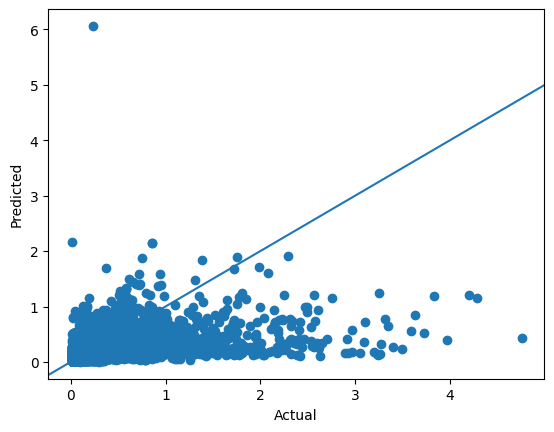

In [134]:
vars_to_run = ['par', 'EOF_1', 'EOF_2', 'EOF_3', 'EOF_4', 'EOF_5', 'EOF_6', 'EOF_7', 'EOF_8']

for i in range(len(phyto_dats)):
    MLR(phyto_dat=phyto_dats[i], vars=vars_to_run, output_name='just_par_EOFs') 


## t, s, PAR and EOF variables

tot
Index(['t', 'EOF_1', 'EOF_2', 'EOF_5', 'EOF_6', 'EOF_7'], dtype='object')
train: 354395 , test: 118131
y_pred: 118131 , y_test: 118131
coefs_mn: [ -0.37230512  52.01003445 -81.49871925  13.90221119  84.11211357
 -67.99271909]
coefs_std: [0.00077457 0.28106409 0.41470797 0.035525   0.37524278 0.26005189]
int: 19.723447692457523
mean r2: 0.6818801196309104
mean bias: 1.000001515946254
mean mae: 1.3248309003619922


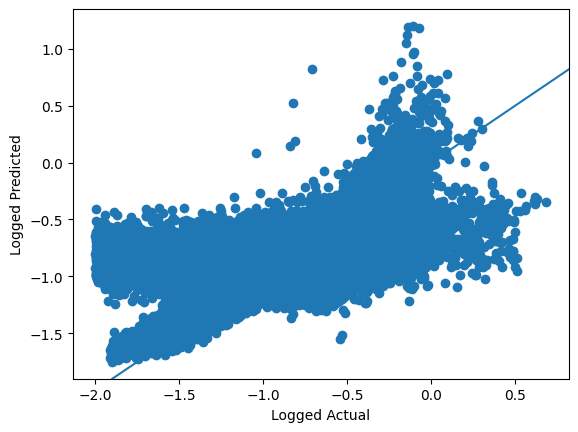

<Figure size 640x480 with 0 Axes>

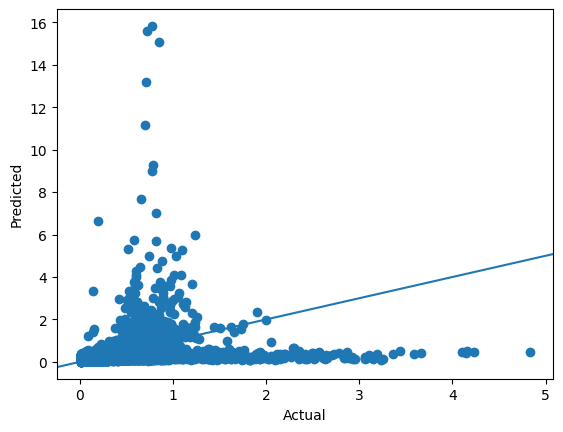

chl
Index(['t', 'EOF_1', 'EOF_2', 'EOF_4', 'EOF_5', 'EOF_6', 'EOF_8'], dtype='object')
train: 118031 , test: 39343
y_pred: 39343 , y_test: 39343
coefs_mn: [   1.56557707  138.13573106 -109.0410356  -145.52057748  -62.68489467
  153.28523385   49.07719322]
coefs_std: [0.00496427 0.70733418 0.99567868 1.18409162 0.3923494  0.69257191
 0.16513936]
int: -38.20603982221255
mean r2: 0.6079580804069643
mean bias: 1.0000049169055436
mean mae: 1.4749763186638638


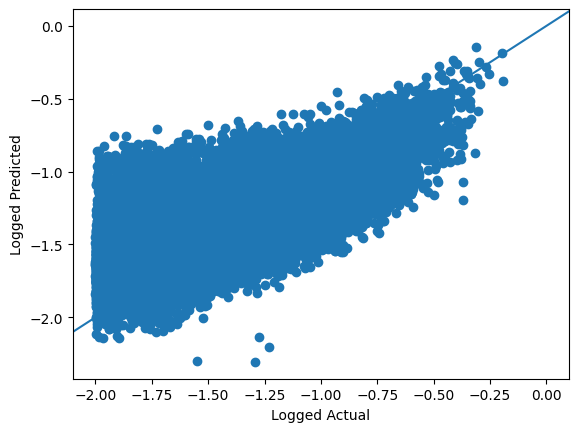

<Figure size 640x480 with 0 Axes>

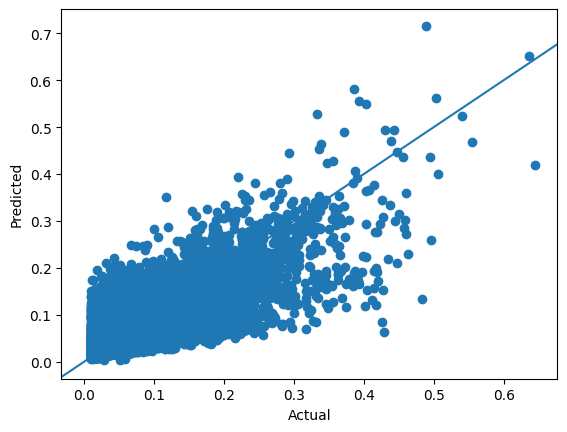

dia
Index(['t', 'par', 'EOF_1', 'EOF_2', 'EOF_5', 'EOF_8'], dtype='object')
train: 154198 , test: 51399
y_pred: 51399 , y_test: 51399
coefs_mn: [ -1.2790653    0.40671337  12.486009   -11.59975691  -5.34280587
  10.1337114 ]
coefs_std: [0.00248177 0.00274261 0.07473985 0.05645211 0.00684418 0.0237351 ]
int: -9.310860811167952
mean r2: 0.6060394510615166
mean bias: 1.000005352364477
mean mae: 1.7012977253995307


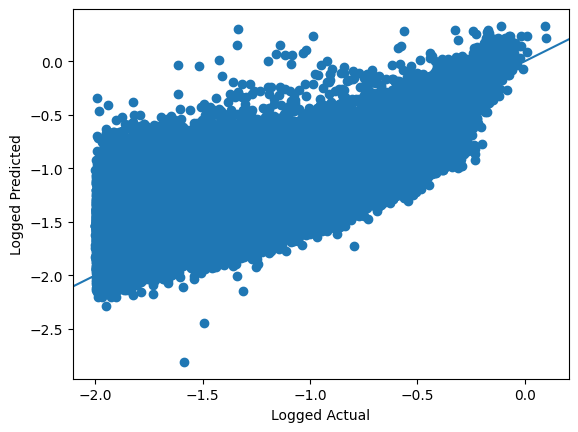

<Figure size 640x480 with 0 Axes>

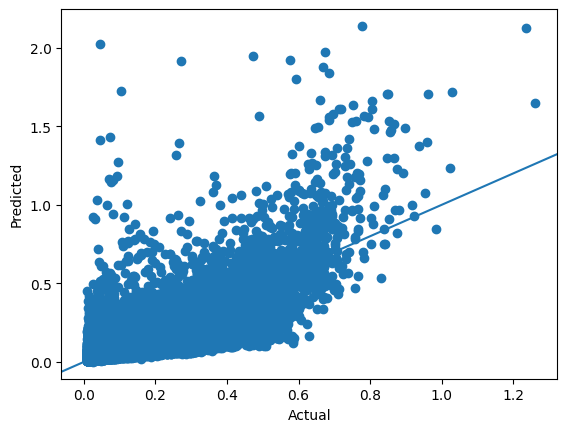

coc
Index(['EOF_3', 'EOF_4', 'EOF_7', 'EOF_8'], dtype='object')
train: 131991 , test: 43996
y_pred: 43996 , y_test: 43996
coefs_mn: [ 108.52127087 -168.60738401   45.88770572   23.89931293]
coefs_std: [0.89240862 1.34877508 0.38080707 0.13735967]
int: -9.579770715751478
mean r2: 0.3041861515895395
mean bias: 1.0000118595995504
mean mae: 2.016686541459956


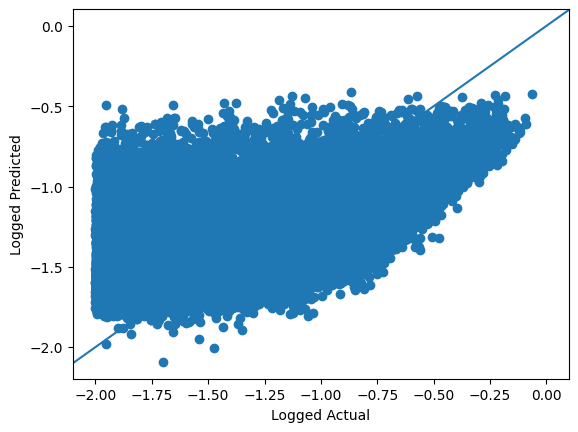

<Figure size 640x480 with 0 Axes>

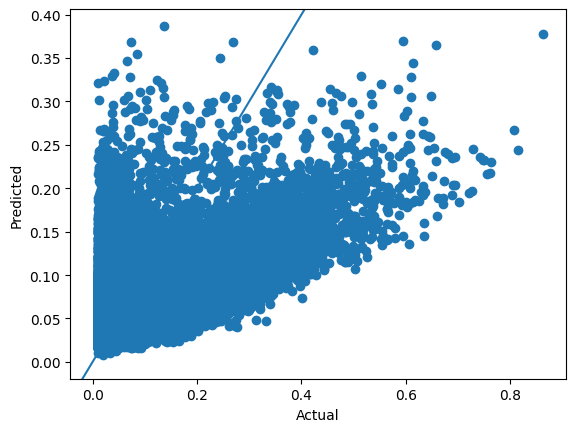

cya
Index(['EOF_1', 'EOF_2', 'EOF_4', 'EOF_5', 'EOF_6', 'EOF_8'], dtype='object')
train: 166497 , test: 55498
y_pred: 55498 , y_test: 55498
coefs_mn: [ -99.90082567   90.0034394    88.49222106   42.59673011 -104.75765949
  -29.26376672]
coefs_std: [5.11707061 3.61771416 6.19960953 2.0184576  5.97981662 1.45421732]
int: 30.22027163040426
mean r2: 0.6813075162974708
mean bias: 1.000018817805786
mean mae: 1.2077469237944063


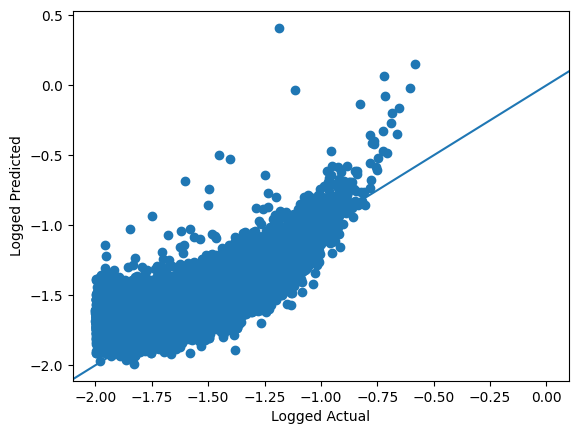

<Figure size 640x480 with 0 Axes>

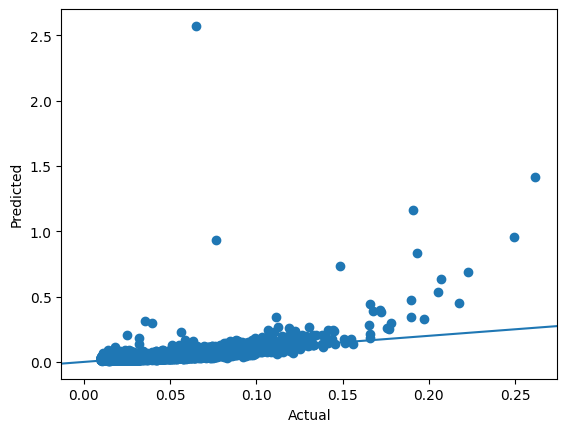

din
Index(['s', 'EOF_2', 'EOF_5', 'EOF_6', 'EOF_7', 'EOF_8'], dtype='object')
train: 3603 , test: 1201
y_pred: 1201 , y_test: 1201
coefs_mn: [  -0.39318542  -26.78125515   72.90258885   77.17674621 -106.65257325
  -30.88636368]
coefs_std: [0.01688479 2.12383163 5.11133699 5.57124684 7.62696817 1.70718008]
int: 29.19135797514626
mean r2: 0.19441002339043392
mean bias: 1.0002808667262066
mean mae: 1.9899463031629852


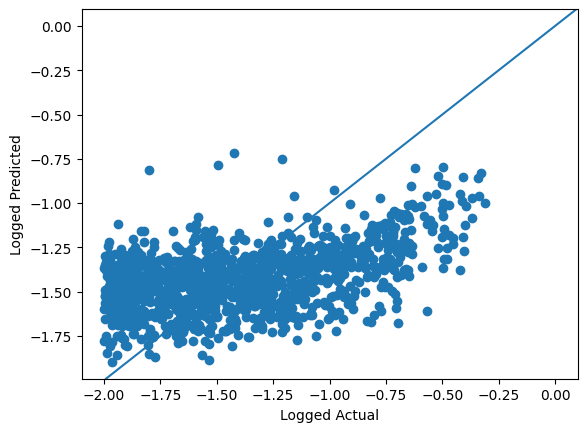

<Figure size 640x480 with 0 Axes>

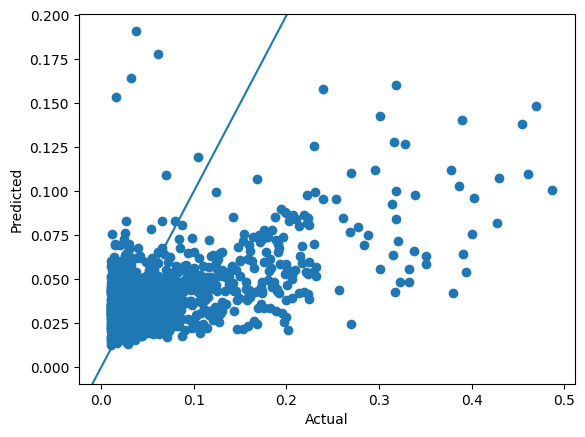

pha
Index(['t', 's', 'par', 'EOF_1', 'EOF_4', 'EOF_5', 'EOF_7', 'EOF_8'], dtype='object')
train: 69424 , test: 23141
y_pred: 23141 , y_test: 23141
coefs_mn: [  -1.92681122   -1.14605501    0.70414207  -90.71981388  146.62147592
  126.71062646 -152.05666201  -61.74725411]
coefs_std: [0.0235031  0.01560748 0.00500854 0.70019441 1.15415532 1.09855464
 1.28993851 0.48981625]
int: 106.002657686227
mean r2: 0.44863587099355556
mean bias: 1.0000252538018575
mean mae: 1.9138080262412995


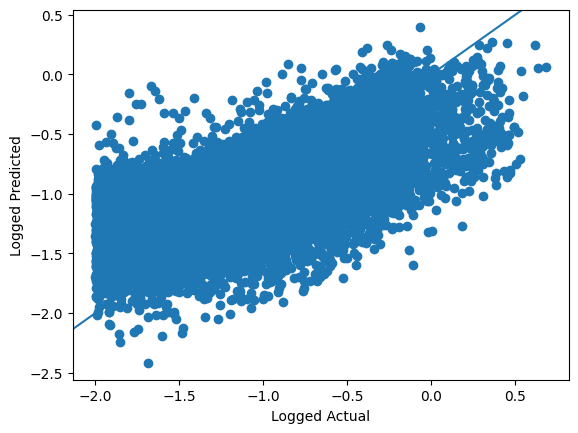

<Figure size 640x480 with 0 Axes>

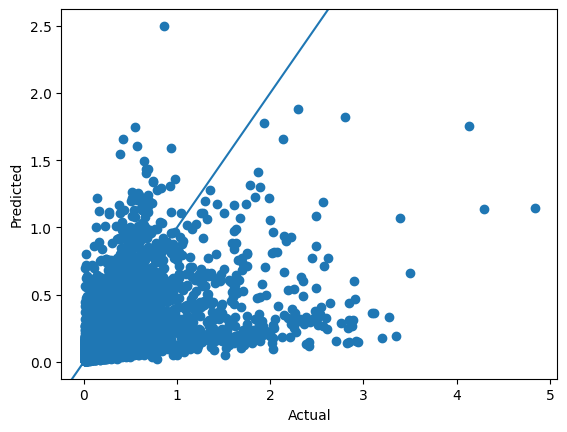

In [131]:
vars_to_run = ['t', 's', 'par', 'EOF_1', 'EOF_2', 'EOF_3', 'EOF_4', 'EOF_5', 'EOF_6', 'EOF_7', 'EOF_8']

for i in range(len(phyto_dats)):
    MLR(phyto_dat=phyto_dats[i], vars=vars_to_run, output_name='t_s_par_EOFs') 


## just t, s, PAR

tot
Index(['t', 's'], dtype='object')
train: 354395 , test: 118131
y_pred: 118131 , y_test: 118131
coefs_mn: [-0.39860913 -0.3777523 ]
coefs_std: [0.00113569 0.00172208]
int: -0.48835182
mean r2: 0.2111229433636175
mean bias: 1.000003042586278
mean mae: 1.7239327138144178


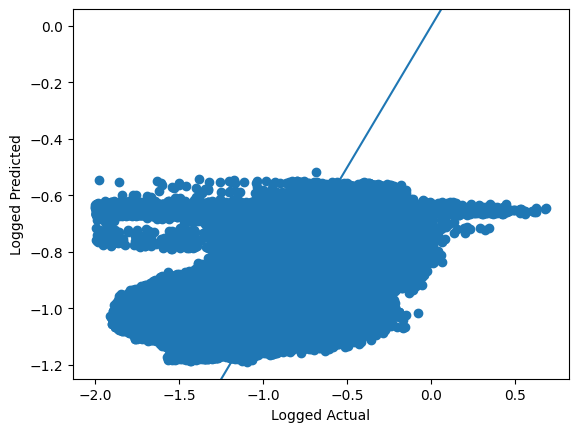

<Figure size 640x480 with 0 Axes>

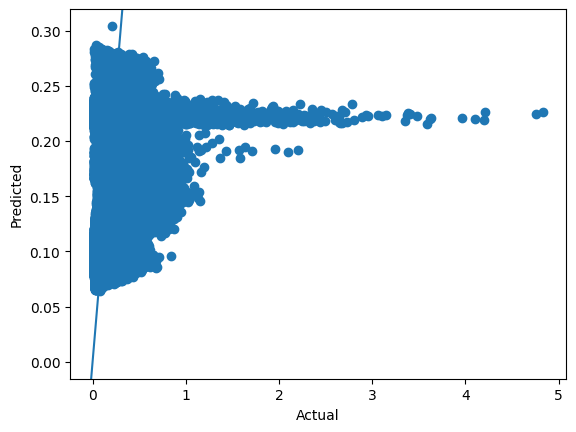

chl
Index(['s'], dtype='object')
train: 118031 , test: 39343
y_pred: 39343 , y_test: 39343
coefs_mn: [-0.30654657]
coefs_std: [0.00342862]
int: -1.1400118
mean r2: 0.016892947617990556
mean bias: 1.0000107323233087
mean mae: 1.9427891370079073


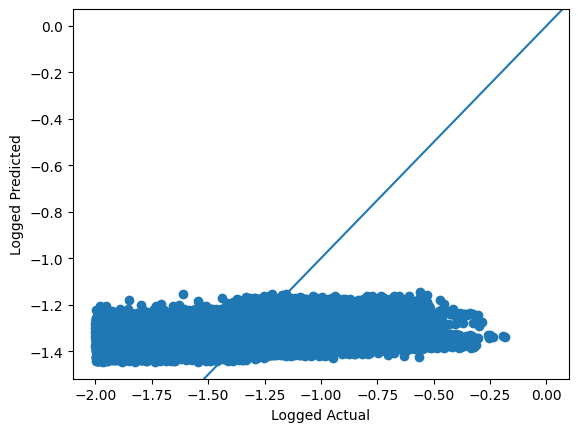

<Figure size 640x480 with 0 Axes>

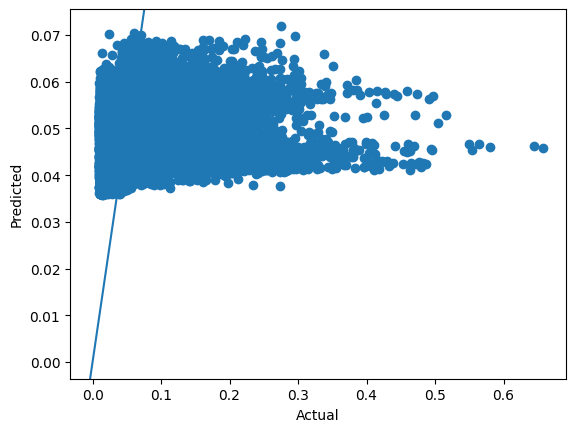

dia
Index(['t', 's'], dtype='object')
train: 154198 , test: 51399
y_pred: 51399 , y_test: 51399
coefs_mn: [-0.6647647  -0.49147657]
coefs_std: [0.00317468 0.00412476]
int: -0.5524408
mean r2: 0.1876341177334596
mean bias: 1.0000165039166564
mean mae: 2.286516887631712


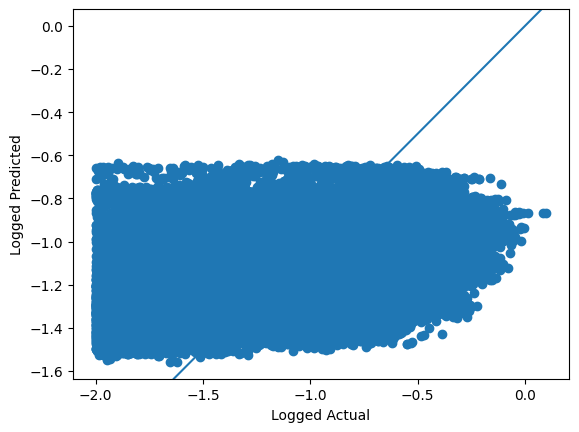

<Figure size 640x480 with 0 Axes>

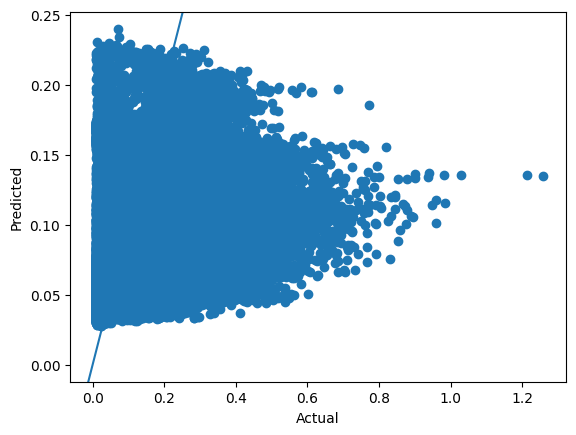

coc
Index(['t'], dtype='object')
train: 131991 , test: 43996
y_pred: 43996 , y_test: 43996
coefs_mn: [-0.8542804]
coefs_std: [0.00304834]
int: -0.8332222
mean r2: 0.13610940039655253
mean bias: 1.00001499029486
mean mae: 2.18759932949836


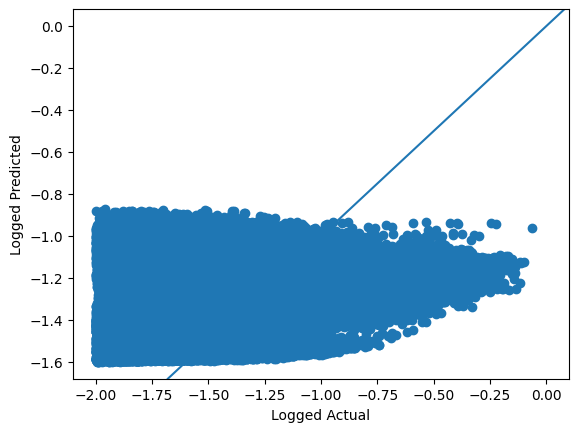

<Figure size 640x480 with 0 Axes>

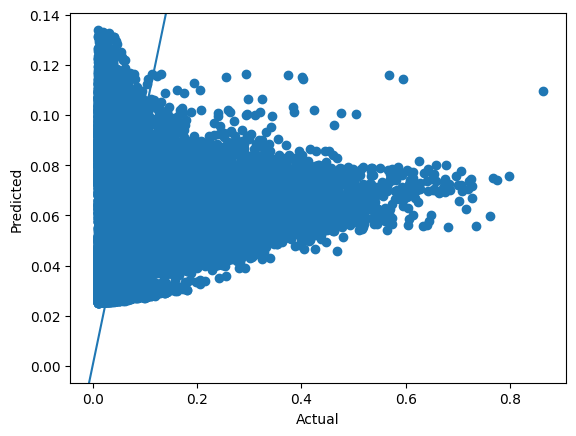

cya
Index(['t'], dtype='object')
train: 166497 , test: 55498
y_pred: 55498 , y_test: 55498
coefs_mn: [0.22395018]
coefs_std: [0.00218416]
int: -1.6523052
mean r2: 0.015028828592786505
mean bias: 1.0000028445988784
mean mae: 1.4377514975508894


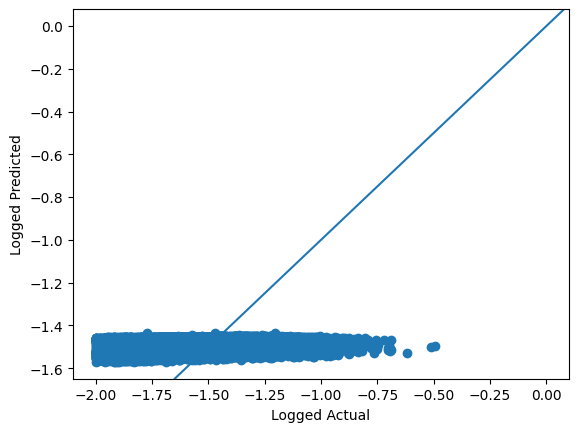

<Figure size 640x480 with 0 Axes>

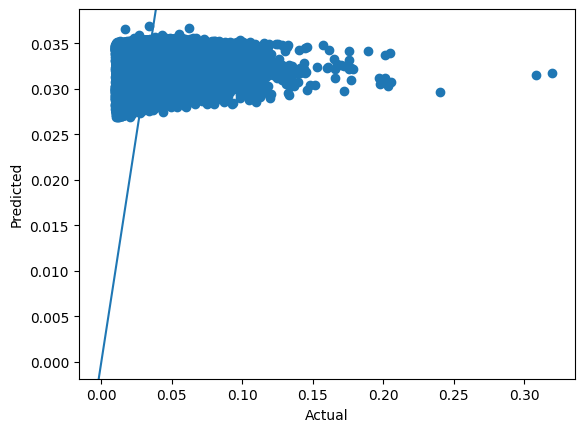

din
Index(['t', 's'], dtype='object')
train: 3603 , test: 1201
y_pred: 1201 , y_test: 1201
coefs_mn: [ 0.72181976 -0.66478366]
coefs_std: [0.03249101 0.02267386]
int: -1.5345824
mean r2: 0.057437989146365
mean bias: 1.0004505463181268
mean mae: 2.1014919623092583


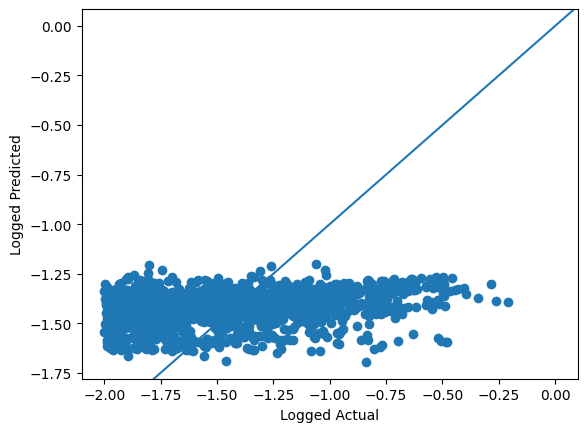

<Figure size 640x480 with 0 Axes>

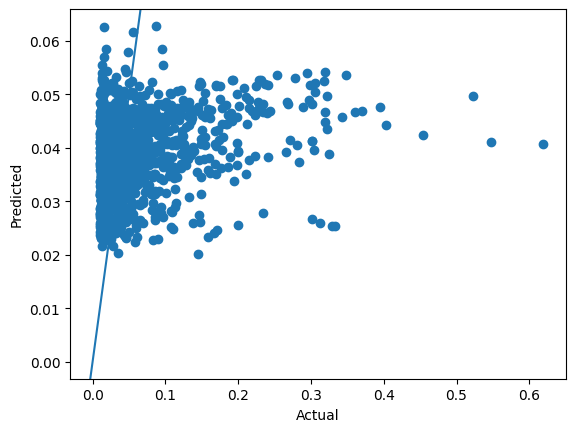

pha
Index(['t', 'par'], dtype='object')
train: 69424 , test: 23141
y_pred: 23141 , y_test: 23141
coefs_mn: [-3.9241247  1.1218827]
coefs_std: [0.01935185 0.00434502]
int: -0.8620586
mean r2: 0.2912316953589946
mean bias: 1.0000213103281559
mean mae: 2.1300264161516362


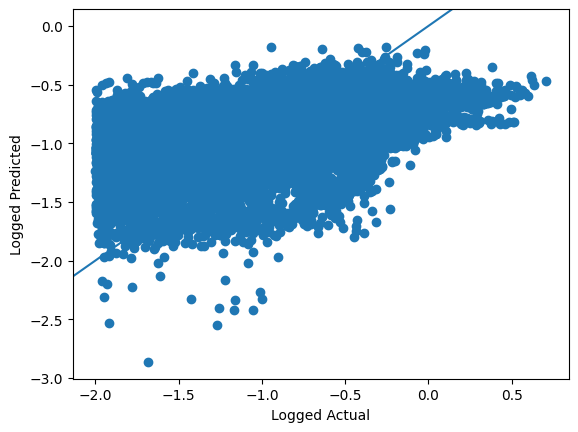

<Figure size 640x480 with 0 Axes>

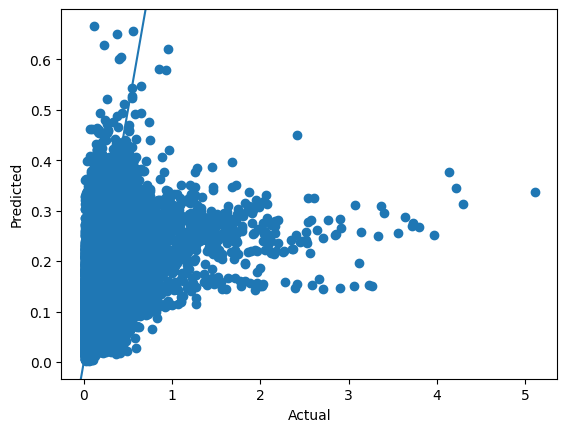

In [135]:
vars_to_run = ['t', 's', 'par']

for i in range(len(phyto_dats)):
    MLR(phyto_dat=phyto_dats[i], vars=vars_to_run, output_name='just_t_s_par') 


## just nutrients + EOFs

tot
Index(['irn', 'rno', 'EOF_1', 'EOF_2', 'EOF_6', 'EOF_7', 'EOF_8'], dtype='object')
train: 354395 , test: 118131
y_pred: 118131 , y_test: 118131
coefs_mn: [  -2.05787703    0.61423252   71.61687053 -102.91501007   91.40086889
  -61.63930364    4.27064845]
coefs_std: [0.01593675 0.00205214 0.26114071 0.3834268  0.33675613 0.21624003
 0.01119066]
int: 11.78482278732742
mean r2: 0.6689066911458914
mean bias: 1.0000009289231087
mean mae: 1.3348085834224281


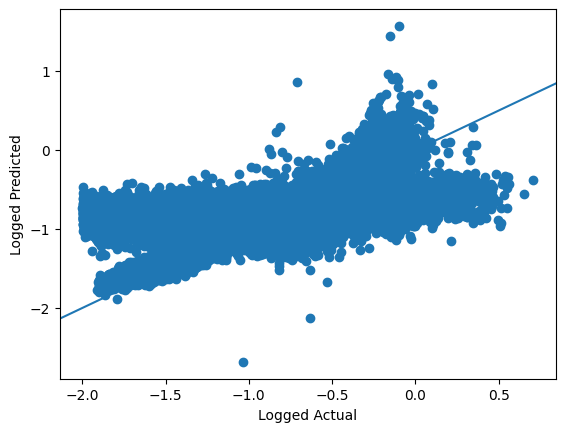

<Figure size 640x480 with 0 Axes>

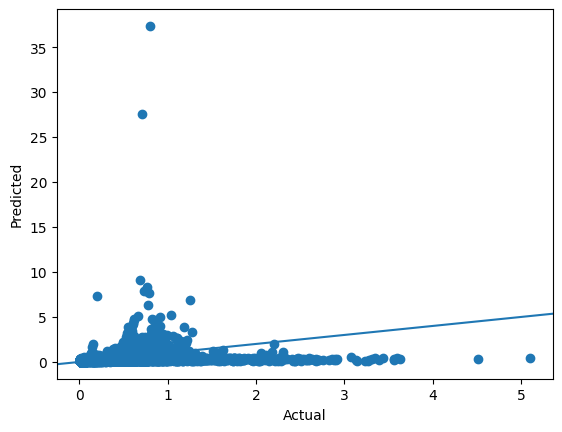

chl
Index(['rno', 'sil', 'EOF_1', 'EOF_2', 'EOF_4', 'EOF_5', 'EOF_6', 'EOF_8'], dtype='object')
train: 118031 , test: 39343
y_pred: 39343 , y_test: 39343
coefs_mn: [  -3.10434632    1.51625078  127.39989745 -104.14715847 -127.72822072
  -59.21722323  139.74753399   44.45140721]
coefs_std: [0.01296039 0.01959181 0.64304349 0.97865445 1.2006531  0.37180074
 0.63048908 0.15676213]
int: -31.45968363365624
mean r2: 0.6090605612482871
mean bias: 1.0000058386284625
mean mae: 1.4681597454613735


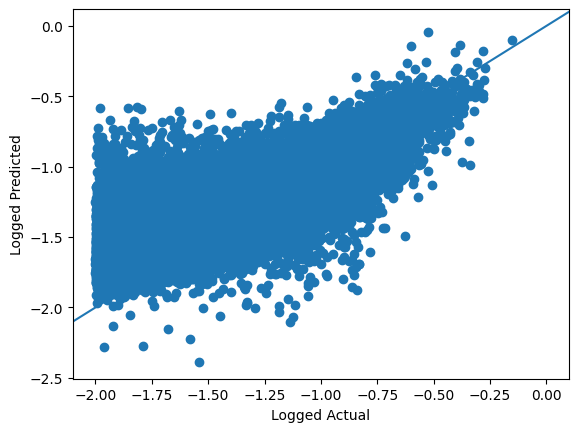

<Figure size 640x480 with 0 Axes>

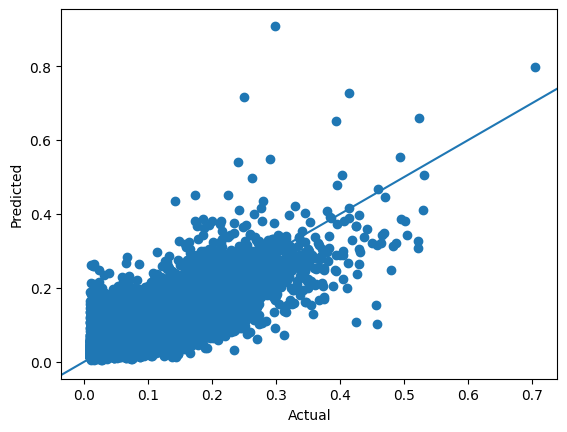

dia
Index(['irn', 'rno', 'sil', 'EOF_1', 'EOF_2', 'EOF_5', 'EOF_8'], dtype='object')
train: 154198 , test: 51399
y_pred: 51399 , y_test: 51399
coefs_mn: [-7.65695397  3.2442704  -2.04418718 10.52301671 -9.13410948 -4.77261621
  8.12630919]
coefs_std: [0.04129007 0.00705246 0.00997916 0.06371406 0.0476043  0.00802885
 0.01968445]
int: -7.988882851866842
mean r2: 0.6577746835995988
mean bias: 1.0000056549122884
mean mae: 1.66879799487277


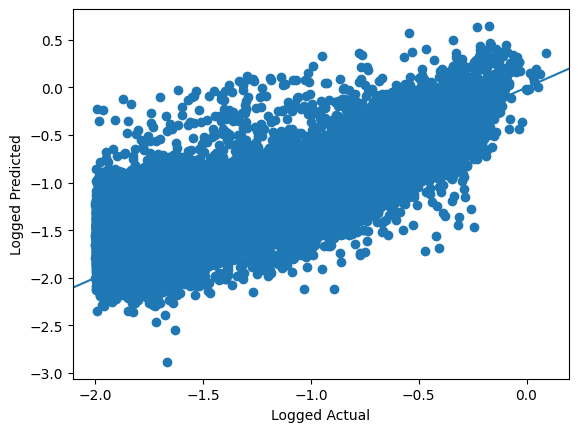

<Figure size 640x480 with 0 Axes>

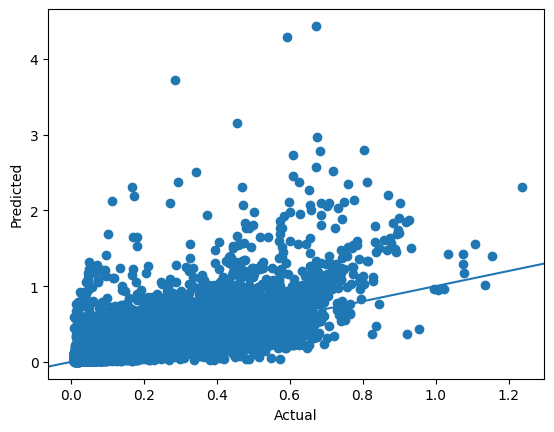

coc
Index(['rno', 'EOF_1', 'EOF_2', 'EOF_5', 'EOF_6', 'EOF_8'], dtype='object')
train: 131991 , test: 43996
y_pred: 43996 , y_test: 43996
coefs_mn: [  -2.83359943  157.73954555 -197.10786323  -89.26205536  105.4027913
   41.22117607]
coefs_std: [0.01012428 0.73771966 0.89688524 0.39136271 0.48464848 0.13653337]
int: -18.589508105670628
mean r2: 0.43551715328630647
mean bias: 1.0000084123699349
mean mae: 1.85768817848218


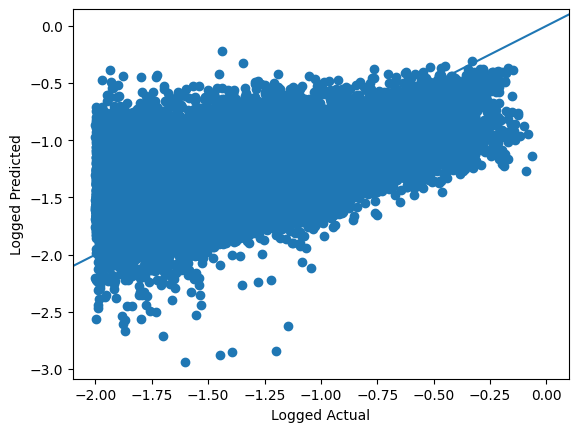

<Figure size 640x480 with 0 Axes>

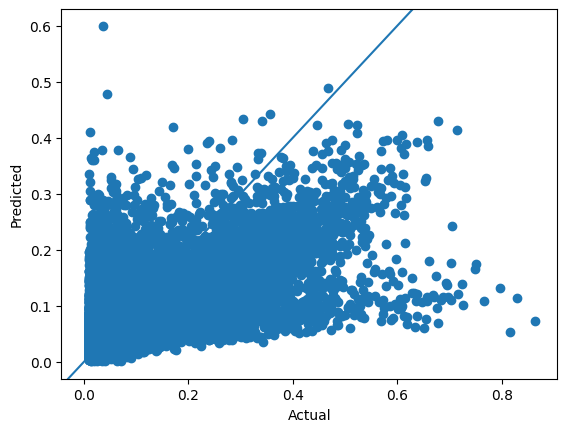

cya
Index(['rno', 'sil', 'EOF_1', 'EOF_2', 'EOF_4', 'EOF_5', 'EOF_6', 'EOF_8'], dtype='object')
train: 166497 , test: 55498
y_pred: 55498 , y_test: 55498
coefs_mn: [ -9.13841696  -2.44886032 -79.82225753  72.11072223  70.97948854
  33.04602237 -83.89891631 -21.8487267 ]
coefs_std: [0.23306091 0.06675058 4.71783608 3.37279572 5.64862684 1.8709503
 5.48176913 1.35998186]
int: 25.856838547897006
mean r2: 0.7342370294924612
mean bias: 1.0000127287538754
mean mae: 1.1819170117380255


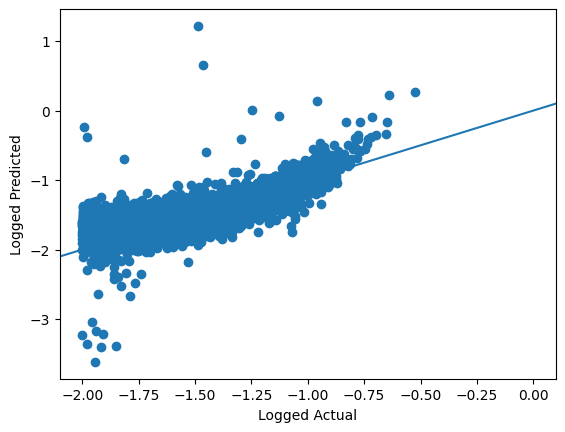

<Figure size 640x480 with 0 Axes>

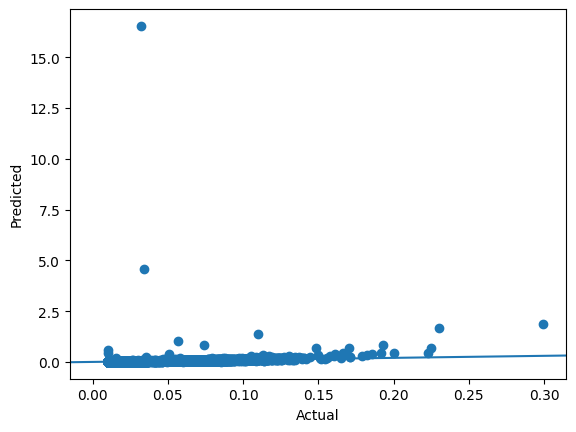

din
Index(['EOF_2', 'EOF_4', 'EOF_5', 'EOF_7', 'EOF_8'], dtype='object')
train: 3603 , test: 1201
y_pred: 1201 , y_test: 1201
coefs_mn: [-60.78948017 114.14561265  45.51923834 -77.0938936  -39.49239975]
coefs_std: [4.52534739 7.85512272 2.60894131 4.85440894 1.90766446]
int: 22.442296708715006
mean r2: 0.16531297977643603
mean bias: 1.0002326208692556
mean mae: 2.0149259842041394


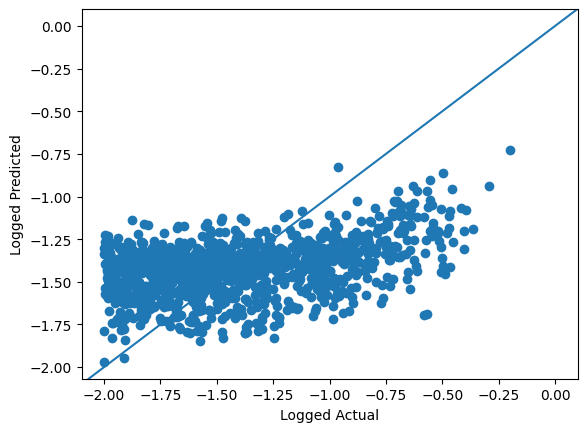

<Figure size 640x480 with 0 Axes>

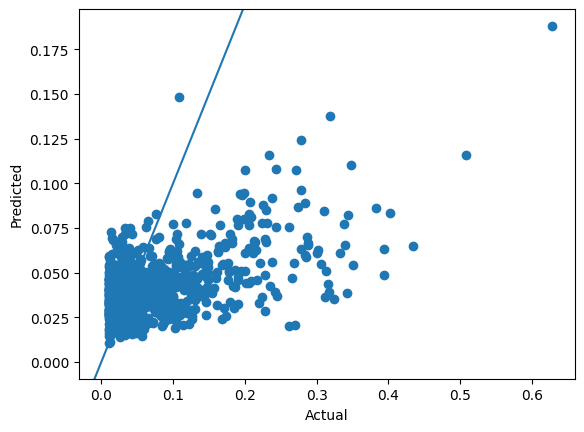

pha
Index(['irn', 'rno', 'EOF_1', 'EOF_4', 'EOF_5', 'EOF_7', 'EOF_8'], dtype='object')
train: 69424 , test: 23141
y_pred: 23141 , y_test: 23141
coefs_mn: [ -15.99835888    1.13899097  -96.42102724  158.15918202  136.7800301
 -164.73029943  -67.68382099]
coefs_std: [0.26697661 0.01825555 0.74938072 1.23221676 1.17684098 1.37738622
 0.5274198 ]
int: 112.16891653160963
mean r2: 0.401710713496694
mean bias: 1.0000255072050366
mean mae: 1.972822931829238


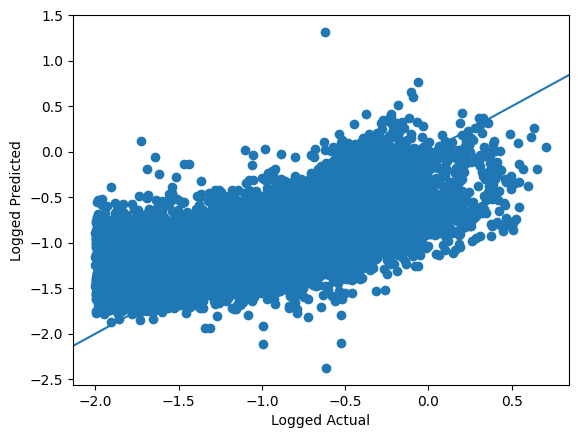

<Figure size 640x480 with 0 Axes>

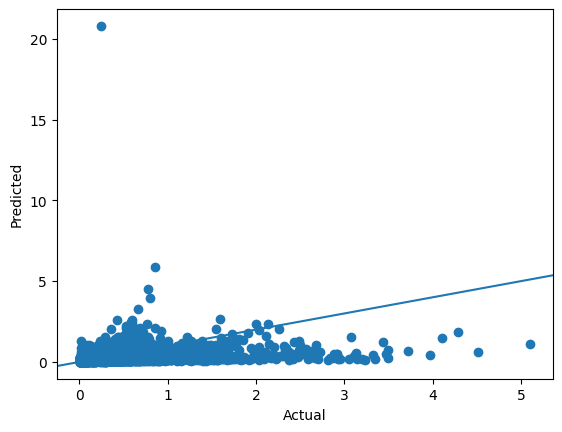

In [140]:
vars_to_run = ['irn', 'rno', 'sil', 'EOF_1', 'EOF_2', 'EOF_3', 'EOF_4', 'EOF_5', 'EOF_6', 'EOF_7', 'EOF_8']

for i in range(len(phyto_dats)):
    MLR(phyto_dat=phyto_dats[i], vars=vars_to_run, output_name='nutrients_EOFs') 


## just IOPs + EOFs

tot
Index(['aph440_aph676', 'aph440_ap440', 'EOF_1', 'EOF_4', 'EOF_5', 'EOF_6'], dtype='object')
train: 354395 , test: 118131
y_pred: 118131 , y_test: 118131
coefs_mn: [ -0.16577142   2.55657796  11.53835075 -30.97252142  -1.77716299
  19.65200541]
coefs_std: [0.00012925 0.0020163  0.02941736 0.07063414 0.00657758 0.03889101]
int: -11.49766341957008
mean r2: 0.9230597880328372
mean bias: 1.0000003724259097
mean mae: 1.1631586309683561


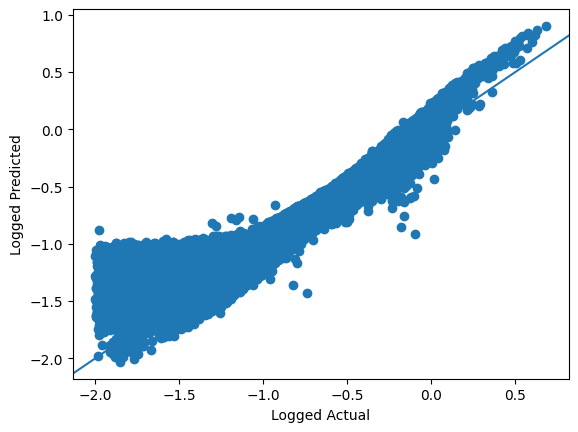

<Figure size 640x480 with 0 Axes>

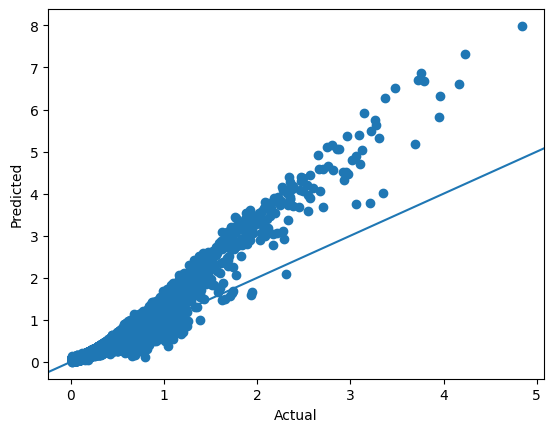

chl
Index(['bbp_s_440_555', 'a_bb_555', 'bbp_bp_555', 'EOF_1', 'EOF_5'], dtype='object')
train: 118031 , test: 39343
y_pred: 39343 , y_test: 39343
coefs_mn: [-3.45210469 -0.00997214 -2.63733926  3.88225468 -2.77111566]
coefs_std: [5.25516475e-03 3.17579409e-05 4.72338581e-03 1.48366906e-02
 8.30288377e-03]
int: 3.8577092609328134
mean r2: 0.7982656868935533
mean bias: 1.0000041351249807
mean mae: 1.3076976128882933


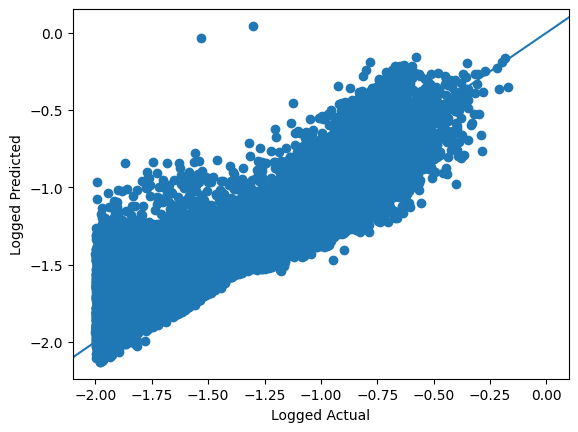

<Figure size 640x480 with 0 Axes>

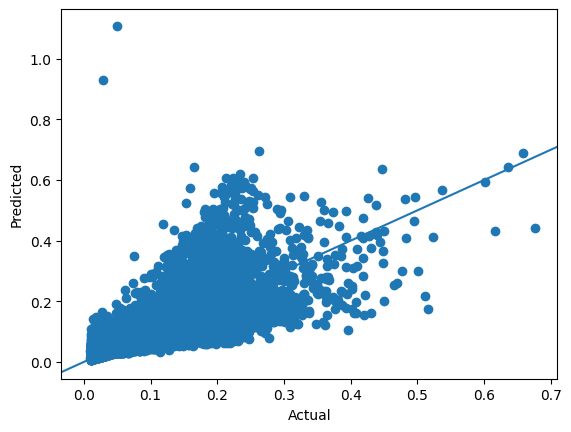

dia
Index(['aph440_aph676', 'aph440_ap440', 'bbp_s_440_555', 'EOF_1', 'EOF_2',
       'EOF_5', 'EOF_8'],
      dtype='object')
train: 154198 , test: 51399
y_pred: 51399 , y_test: 51399
coefs_mn: [ -0.44190621   1.70712143   1.60915306   9.9853392  -12.33080524
  -3.71076948   9.30878192]
coefs_std: [0.00088244 0.00760387 0.00333118 0.04911569 0.04264649 0.0145126
 0.04144626]
int: -11.159564484540729
mean r2: 0.820617879269533
mean bias: 1.0000038799595412
mean mae: 1.4263284041973643


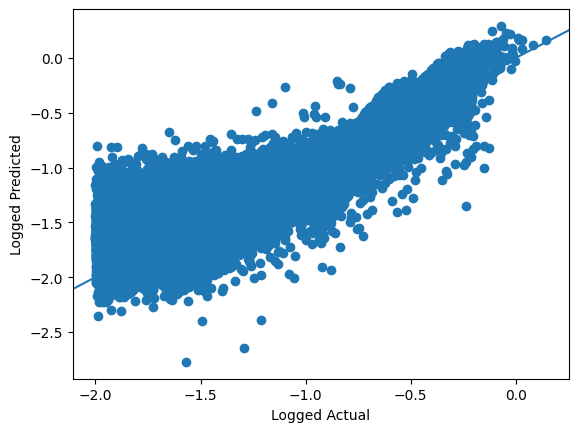

<Figure size 640x480 with 0 Axes>

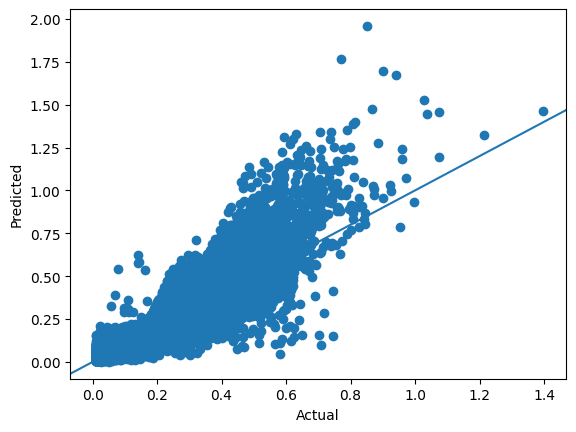

coc
Index(['aph440_aph676', 'aph440_ap440', 'bbp_s_440_555', 'a_bb_555',
       'bbp_bp_555', 'EOF_7'],
      dtype='object')
train: 131991 , test: 43996
y_pred: 43996 , y_test: 43996
coefs_mn: [ 0.2193839   1.1139852   2.85782518 -0.02550849  2.08564327 -0.89110973]
coefs_std: [4.01732371e-04 1.39429903e-03 4.64763439e-03 4.18963918e-05
 3.47027135e-03 1.03373391e-03]
int: -6.339371702952999
mean r2: 0.9667699447963588
mean bias: 1.0000005077873724
mean mae: 1.1401229633336345


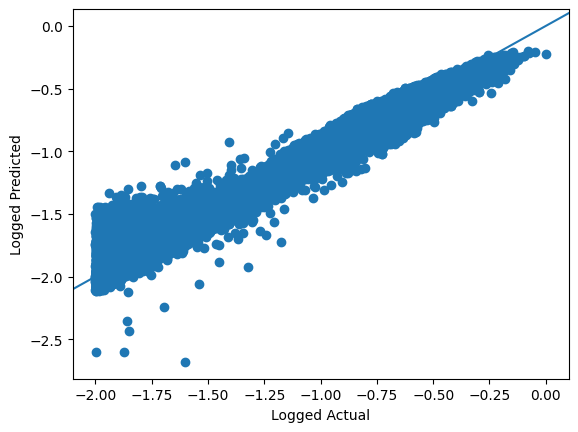

<Figure size 640x480 with 0 Axes>

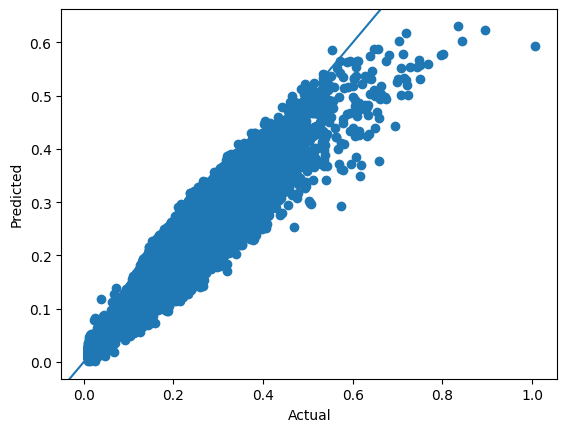

cya
Index(['aph440_aph676', 'aph440_ap440', 'a_cdoc_443', 'bbp_s_440_555',
       'a_bb_555', 'bbp_bp_555', 'EOF_2', 'EOF_8'],
      dtype='object')
train: 166497 , test: 55498
y_pred: 55498 , y_test: 55498
coefs_mn: [-2.86352180e-01  5.10081918e-01  2.46013394e+01  1.06699445e+00
  3.98345878e-03  1.35310991e+00  4.52886779e+00 -5.71868990e+00]
coefs_std: [2.79900494e-03 1.13581962e-02 5.16054652e-01 1.21146860e-02
 2.28971343e-05 5.61759616e-03 4.30243400e-02 2.09134866e-02]
int: -3.953276602175564
mean r2: 0.858719645486957
mean bias: 1.0000071509192818
mean mae: 1.1247214383037583


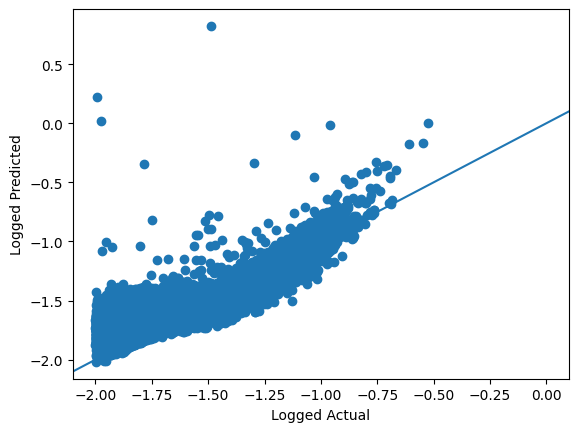

<Figure size 640x480 with 0 Axes>

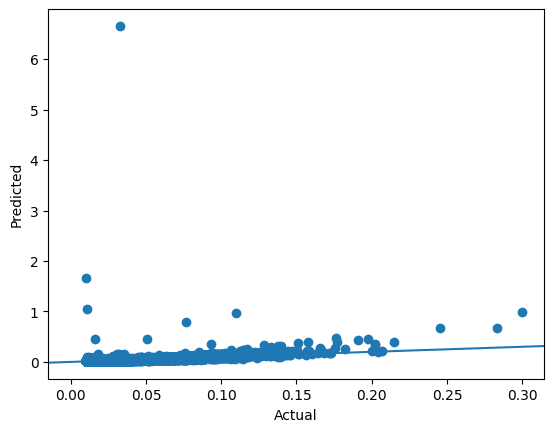

din
Index(['aph440_aph676', 'aph440_ap440', 'bbp_s_440_555', 'bbp_bp_555', 'EOF_2',
       'EOF_6', 'EOF_8'],
      dtype='object')
train: 3603 , test: 1201
y_pred: 1201 , y_test: 1201
coefs_mn: [ -0.35270714   5.64833107  -2.23025275  -1.84584437  -7.78325057
  11.45491036 -17.72383859]
coefs_std: [0.01298407 0.07754671 0.04649592 0.05706663 0.15720708 0.22635959
 0.43266453]
int: 4.162536687896829
mean r2: 0.6032261011173609
mean bias: 1.0003633113769113
mean mae: 1.601810141953944


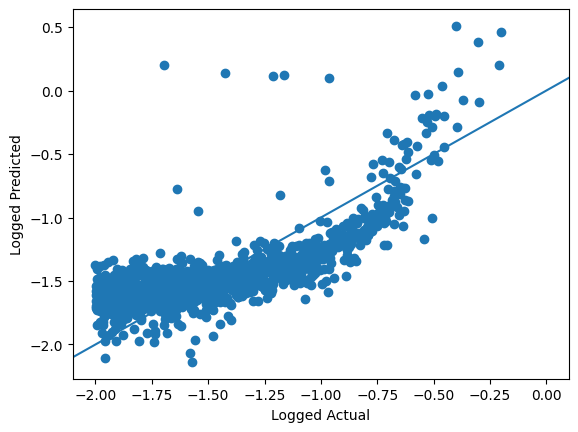

<Figure size 640x480 with 0 Axes>

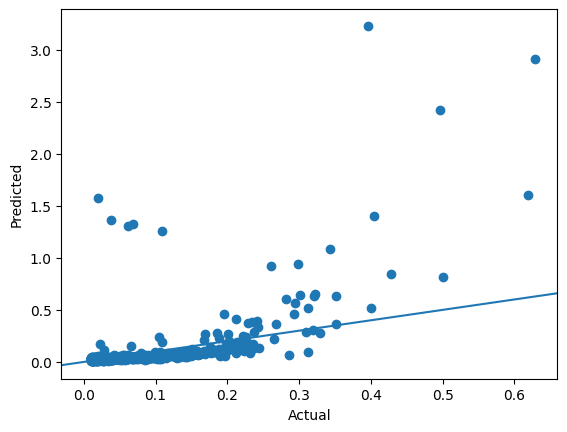

pha
Index(['aph440_aph676', 'aph440_ap440', 'bbp_s_440_555', 'a_bb_555',
       'bbp_bp_555', 'EOF_8'],
      dtype='object')
train: 69424 , test: 23141
y_pred: 23141 , y_test: 23141
coefs_mn: [-2.20316785  2.35987052  1.11301949 -0.07000182  0.89970301 -2.76733289]
coefs_std: [0.02359542 0.00310311 0.00825882 0.00016438 0.00728099 0.00735049]
int: 0.31289505726444633
mean r2: 0.8595145782648791
mean bias: 0.9999980248851849
mean mae: 1.3344072374731053


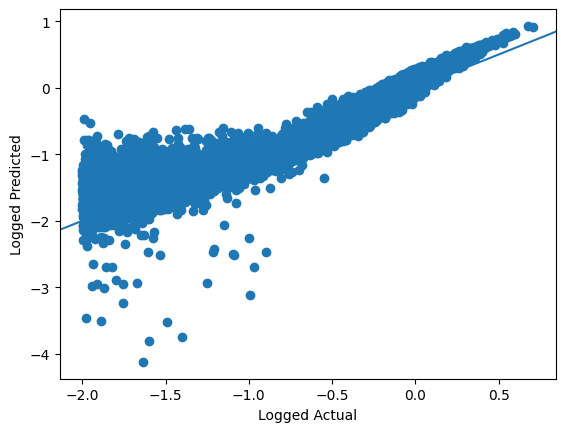

<Figure size 640x480 with 0 Axes>

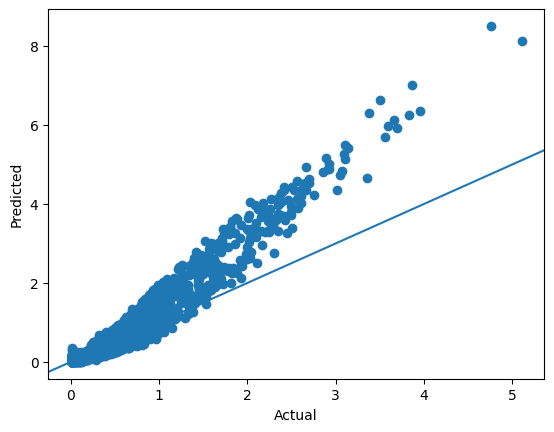

In [141]:
vars_to_run = ['aph440_aph676','aph440_ap440', 'a_cdoc_443', 
               'bbp_s_440_555', 'a_bb_555', 'bbp_bp_555',
               'EOF_1', 'EOF_2', 'EOF_3', 'EOF_4', 'EOF_5', 'EOF_6', 'EOF_7', 'EOF_8']

for i in range(len(phyto_dats)):
    MLR(phyto_dat=phyto_dats[i], vars=vars_to_run, output_name='iops_EOFs') 


## just IOPs

tot
Index(['aph440_aph676', 'aph440_ap440', 'a_cdoc_443', 'a_bb_555'], dtype='object')
train: 354395 , test: 118131
y_pred: 118131 , y_test: 118131
coefs_mn: [-2.5507727e-01  2.0181022e+00  3.3622021e+01 -1.0866232e-02]
coefs_std: [2.9978112e-04 1.7630956e-03 8.1865124e-02 2.2067594e-05]
int: -1.327275
mean r2: 0.7785432539122388
mean bias: 1.000002285254901
mean mae: 1.3231960950680308


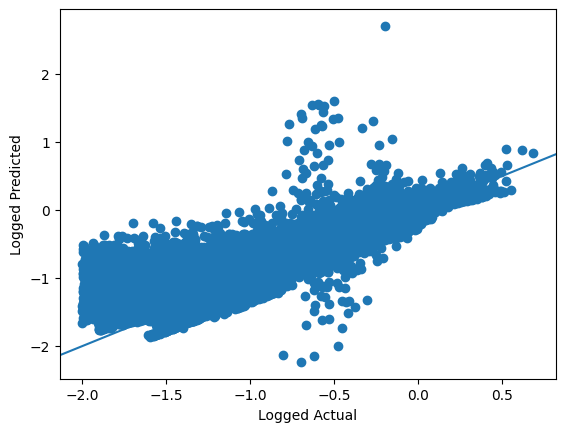

<Figure size 640x480 with 0 Axes>

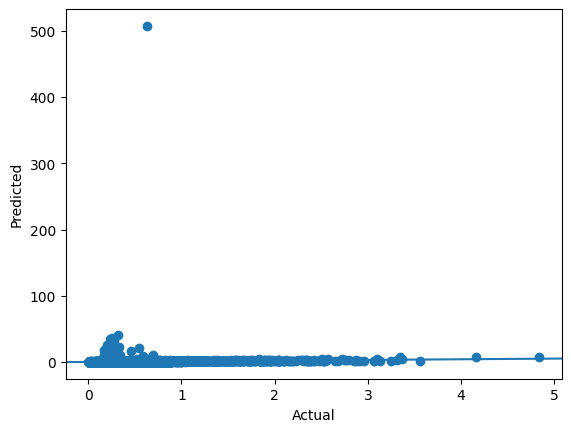

chl
Index(['aph440_ap440', 'a_cdoc_443', 'bbp_s_440_555', 'a_bb_555',
       'bbp_bp_555'],
      dtype='object')
train: 118031 , test: 39343
y_pred: 39343 , y_test: 39343
coefs_mn: [ 6.9027084e-01  1.5632115e+01 -3.4028244e+00 -7.7226306e-03
 -2.6056588e+00]
coefs_std: [6.0924911e-03 1.6537699e-01 4.9801543e-03 3.6687692e-05 4.9539618e-03]
int: 4.166002
mean r2: 0.6933155157400493
mean bias: 1.0000101888917232
mean mae: 1.4251923253236871


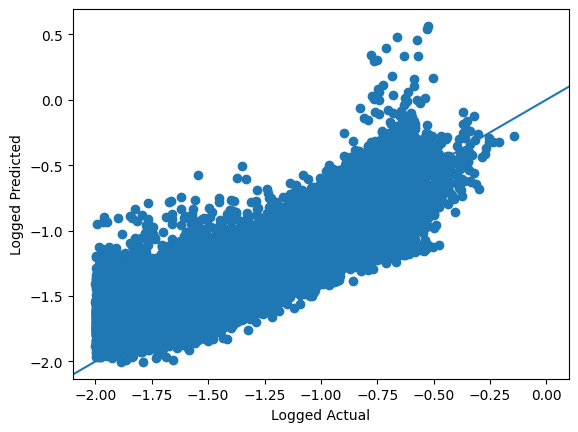

<Figure size 640x480 with 0 Axes>

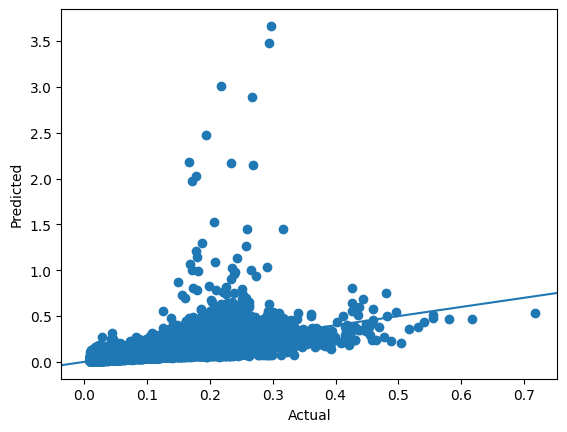

dia
Index(['aph440_aph676', 'aph440_ap440', 'a_cdoc_443', 'bbp_s_440_555',
       'bbp_bp_555'],
      dtype='object')
train: 154198 , test: 51399
y_pred: 51399 , y_test: 51399
coefs_mn: [-0.6892436  2.2620347 39.575893   1.8557558  1.3458561]
coefs_std: [0.00078023 0.00496837 0.25085405 0.00799182 0.00748587]
int: -4.2203126
mean r2: 0.6493711283372133
mean bias: 1.000013644388084
mean mae: 1.6433095042354253


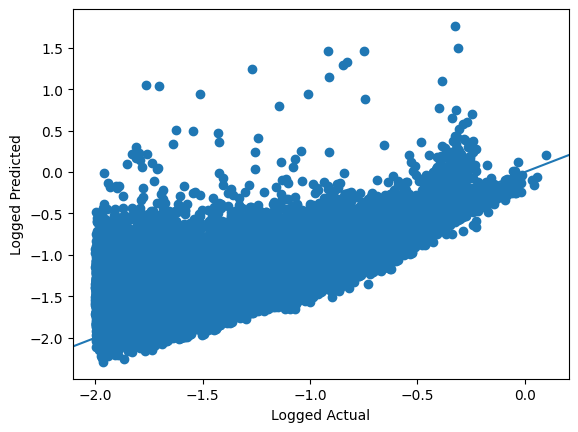

<Figure size 640x480 with 0 Axes>

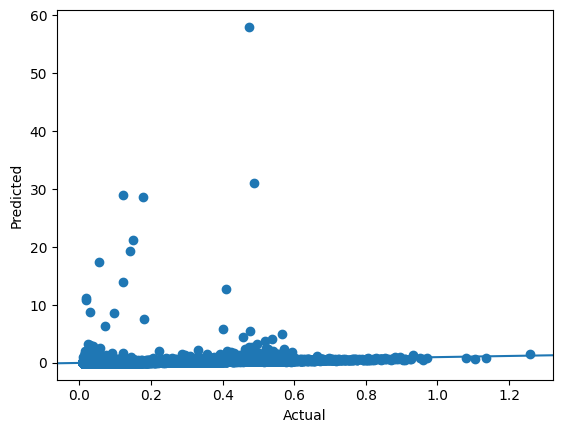

coc
Index(['aph440_ap440', 'a_cdoc_443', 'bbp_s_440_555', 'a_bb_555',
       'bbp_bp_555'],
      dtype='object')
train: 131991 , test: 43996
y_pred: 43996 , y_test: 43996
coefs_mn: [ 1.241829   34.03492     3.638069   -0.03942416  2.8083684 ]
coefs_std: [2.1198224e-03 1.0606708e-01 4.8027267e-03 4.0720941e-05 3.4308287e-03]
int: -8.277661
mean r2: 0.9369491463258555
mean bias: 1.00000183038345
mean mae: 1.2067129185970171


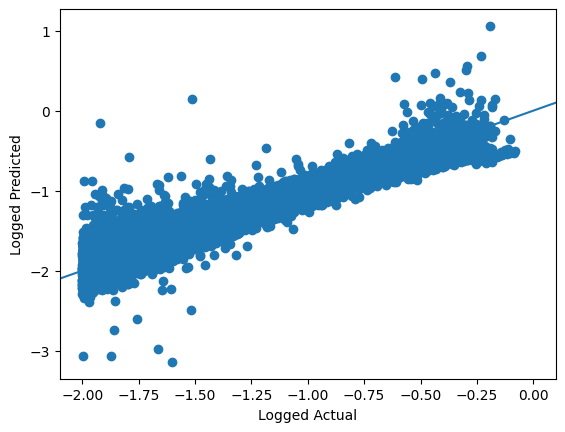

<Figure size 640x480 with 0 Axes>

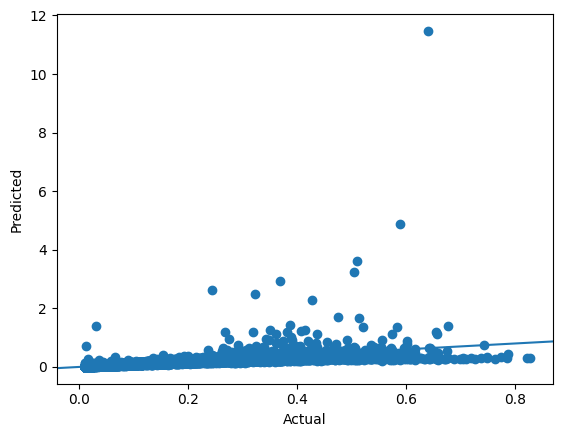

cya
Index(['aph440_aph676', 'aph440_ap440', 'a_cdoc_443', 'bbp_s_440_555',
       'bbp_bp_555'],
      dtype='object')
train: 166497 , test: 55498
y_pred: 55498 , y_test: 55498
coefs_mn: [-0.54311705  0.8998765  31.706865    2.3120315   2.0245645 ]
coefs_std: [0.00071743 0.00452291 0.17828204 0.00381627 0.0030008 ]
int: -4.9853306
mean r2: 0.6674205952685057
mean bias: 1.0000032196114685
mean mae: 1.2142590866290126


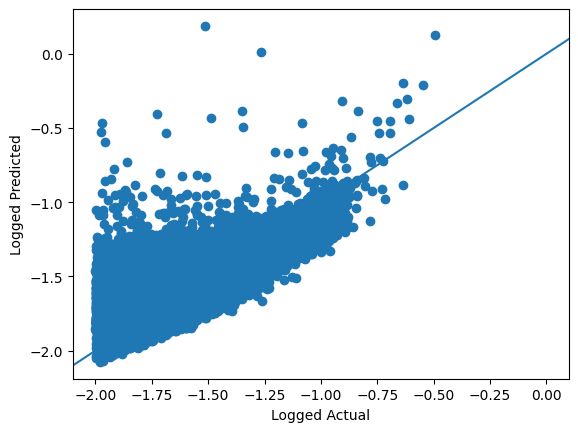

<Figure size 640x480 with 0 Axes>

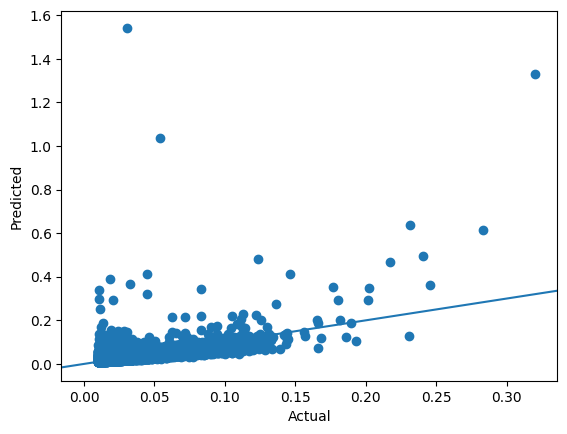

din
Index(['aph440_ap440', 'a_cdoc_443', 'bbp_s_440_555', 'a_bb_555',
       'bbp_bp_555'],
      dtype='object')
train: 3603 , test: 1201
y_pred: 1201 , y_test: 1201
coefs_mn: [ 1.2245997e+00  1.8453461e+01 -1.4643424e+00  7.9376511e-03
 -1.3796436e+00]
coefs_std: [4.4446077e-02 8.8095939e-01 6.3162111e-02 2.0815890e-04 5.4572411e-02]
int: 0.18564266
mean r2: 0.24002180209423316
mean bias: 1.0005715634343544
mean mae: 1.937797237648867


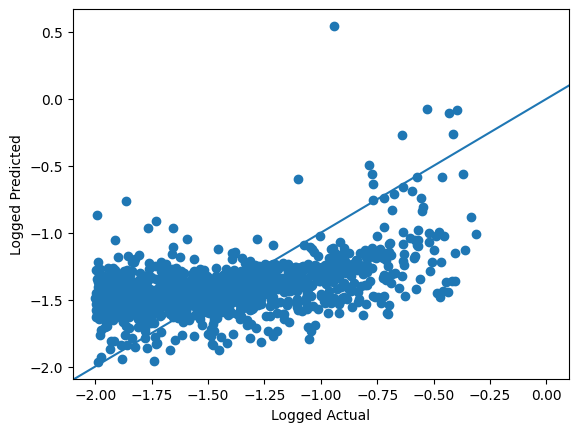

<Figure size 640x480 with 0 Axes>

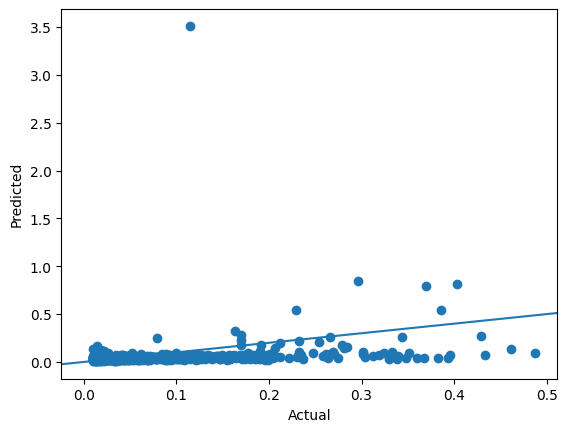

pha
Index(['aph440_aph676', 'aph440_ap440', 'a_cdoc_443', 'a_bb_555'], dtype='object')
train: 69424 , test: 23141
y_pred: 23141 , y_test: 23141
coefs_mn: [-2.2224658   2.5089483  21.173532   -0.07769339]
coefs_std: [0.02417177 0.00321285 0.05147754 0.00016909]
int: 2.7741358
mean r2: 0.816345444566631
mean bias: 1.0000001619768437
mean mae: 1.417946307735381


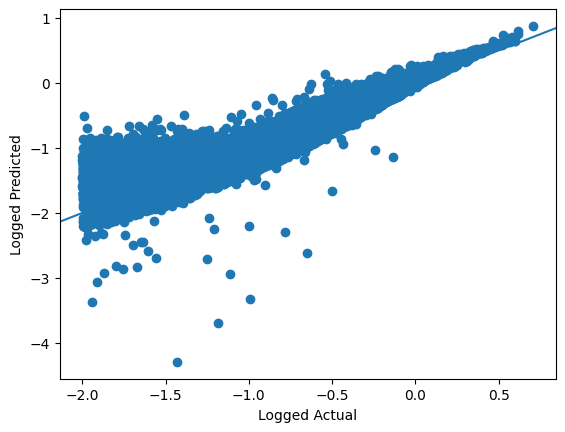

<Figure size 640x480 with 0 Axes>

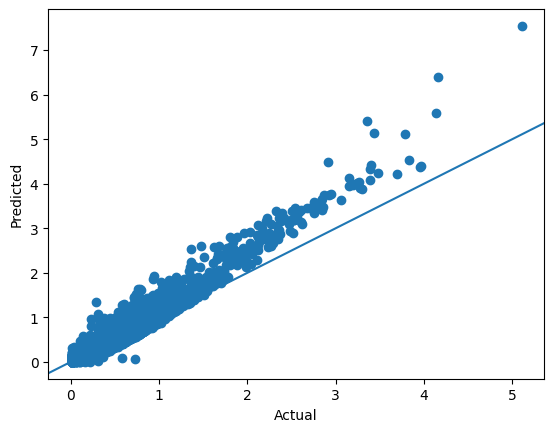

In [142]:
vars_to_run = ['aph440_aph676','aph440_ap440', 'a_cdoc_443', 
               'bbp_s_440_555', 'a_bb_555', 'bbp_bp_555']

for i in range(len(phyto_dats)):
    MLR(phyto_dat=phyto_dats[i], vars=vars_to_run, output_name='just_iops') 


## PACE IOPs, t, EOFs

tot
Index(['t', 'bbp_s_440_555', 'EOF_1', 'EOF_2', 'EOF_6', 'EOF_7', 'EOF_8'], dtype='object')
train: 354395 , test: 118131
y_pred: 118131 , y_test: 118131
coefs_mn: [ -0.47653773  -0.69091254  57.54726204 -84.4239036   78.9709053
 -53.19300675   2.88545116]
coefs_std: [0.00086528 0.00204769 0.29692708 0.43114035 0.37316112 0.23946575
 0.01144385]
int: 17.797810580405947
mean r2: 0.7307933319181987
mean bias: 1.000002408333843
mean mae: 1.2943953285113678


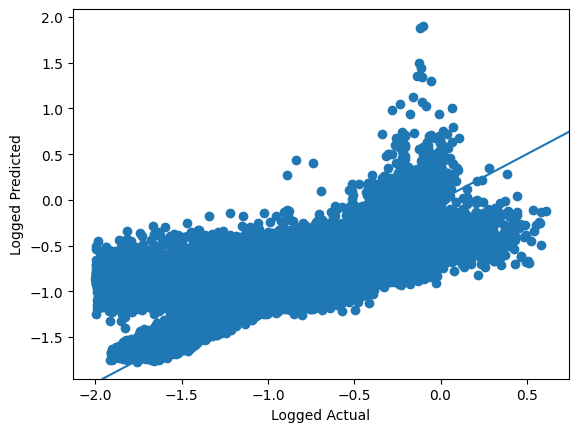

<Figure size 640x480 with 0 Axes>

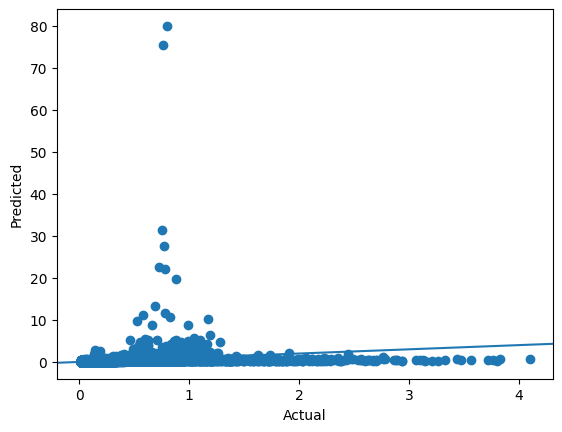

chl
Index(['t', 'aph440_aph676', 'bbp_s_440_555', 'a_bb_555', 'EOF_1', 'EOF_4',
       'EOF_5', 'EOF_6', 'EOF_8'],
      dtype='object')
train: 118031 , test: 39343
y_pred: 39343 , y_test: 39343
coefs_mn: [ 1.19289421e+00 -3.67456156e-01 -9.58281513e-01 -1.35192565e-02
  5.98259885e+01 -1.74266771e+02 -1.99540184e+01  1.19425816e+02
  2.88504611e+01]
coefs_std: [4.79845301e-03 1.85540845e-03 6.34283368e-03 6.74116491e-05
 3.82549371e-01 1.12971514e+00 1.32048804e-01 7.94989557e-01
 1.61657197e-01]
int: -19.285304842518734
mean r2: 0.7096807467226458
mean bias: 1.0000088515879388
mean mae: 1.3893188350140286


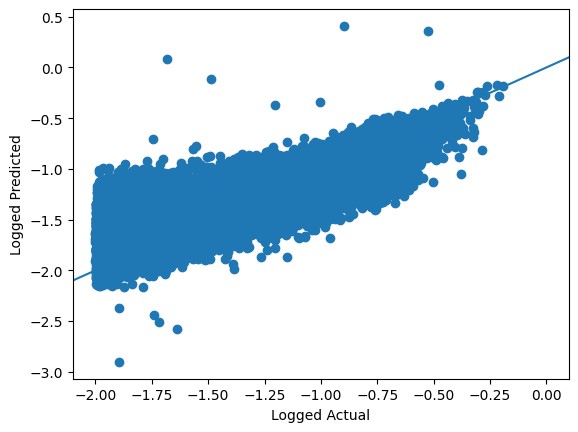

<Figure size 640x480 with 0 Axes>

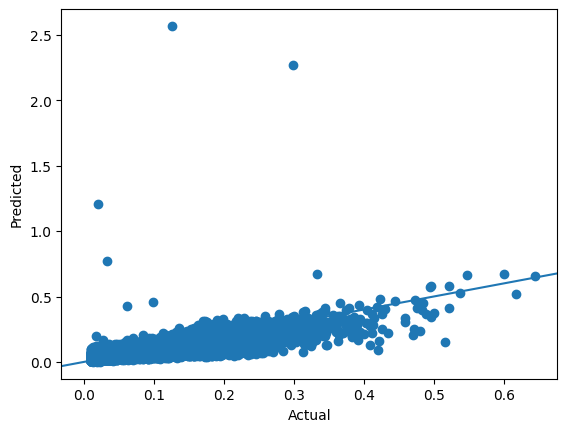

dia
Index(['t', 'aph440_aph676', 'bbp_s_440_555', 'EOF_1', 'EOF_2', 'EOF_5',
       'EOF_8'],
      dtype='object')
train: 154198 , test: 51399
y_pred: 51399 , y_test: 51399
coefs_mn: [ -0.51942814  -0.32214908   1.09585154   9.17684282 -10.89346816
  -5.99367094  14.50742145]
coefs_std: [0.00185038 0.00066013 0.00444707 0.05350804 0.04504742 0.00559764
 0.02577392]
int: -3.5379207887045125
mean r2: 0.8145136107144372
mean bias: 1.0000058698193035
mean mae: 1.43629357438848


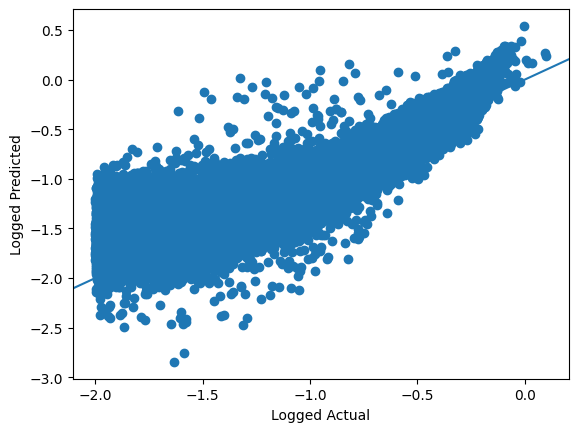

<Figure size 640x480 with 0 Axes>

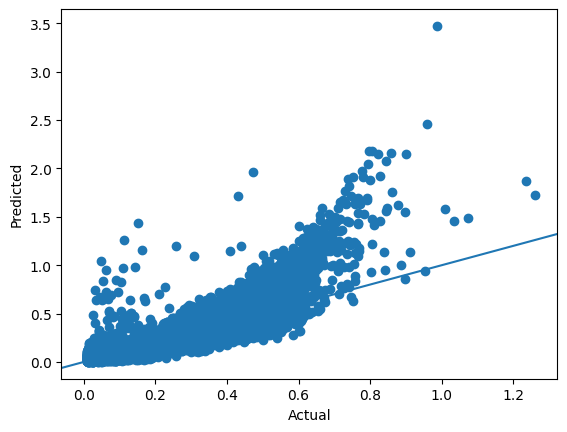

coc
Index(['aph440_aph676', 'a_bb_555', 'EOF_4', 'EOF_6'], dtype='object')
train: 131991 , test: 43996
y_pred: 43996 , y_test: 43996
coefs_mn: [  0.4079378   -0.02485938  13.21975562 -11.80203328]
coefs_std: [4.77796696e-04 4.99441410e-05 1.72147627e-02 1.43558059e-02]
int: -6.182049317715284
mean r2: 0.9157105439207802
mean bias: 1.0000006000434705
mean mae: 1.246889006297352


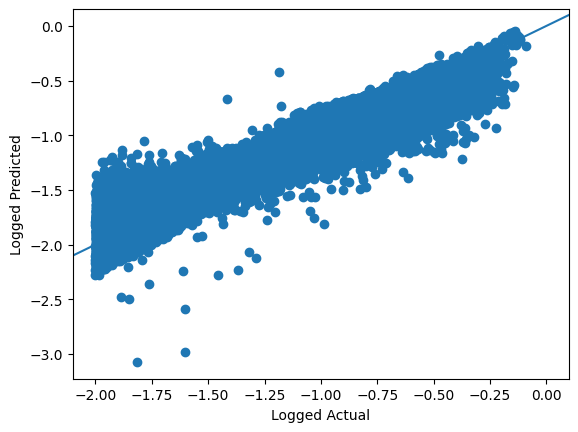

<Figure size 640x480 with 0 Axes>

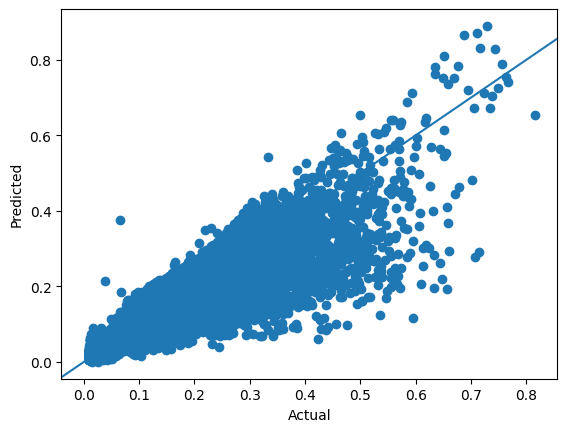

cya
Index(['bbp_s_440_555', 'a_bb_555', 'EOF_1', 'EOF_2', 'EOF_5', 'EOF_6',
       'EOF_8'],
      dtype='object')
train: 166497 , test: 55498
y_pred: 55498 , y_test: 55498
coefs_mn: [-5.06863103e-01  5.87784324e-03 -7.76930348e+01  9.98857724e+01
  3.93322140e+01 -5.05488799e+01 -1.82574860e+01]
coefs_std: [8.36438218e-03 6.59126855e-05 4.11768850e+00 4.98284960e+00
 2.11057527e+00 2.63204259e+00 7.11478588e-01]
int: 17.033233265540744
mean r2: 0.7428028984743479
mean bias: 1.000012671446542
mean mae: 1.1840231613784546


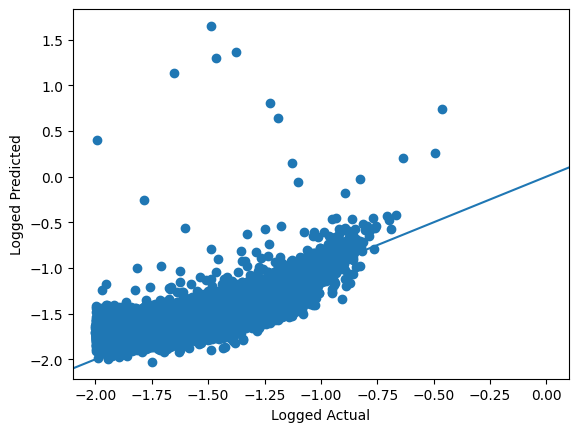

<Figure size 640x480 with 0 Axes>

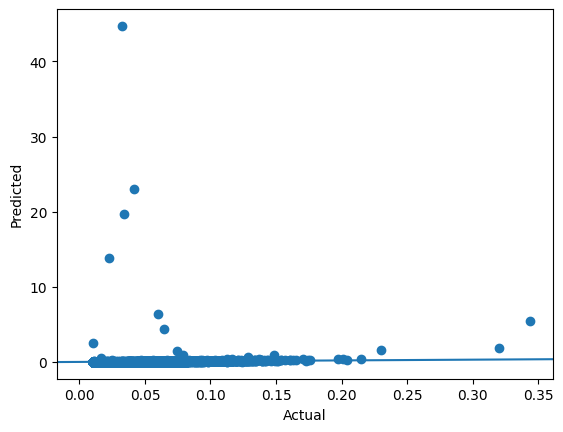

din
Index(['bbp_s_440_555', 'a_bb_555', 'EOF_2', 'EOF_8'], dtype='object')
train: 3603 , test: 1201
y_pred: 1201 , y_test: 1201
coefs_mn: [-0.713407    0.01118161  4.63373932 -8.56137427]
coefs_std: [0.0309126  0.00024255 0.12298949 0.20015515]
int: -1.77371114934638
mean r2: 0.27791803296200085
mean bias: 1.00049392866141
mean mae: 1.9154409919359565


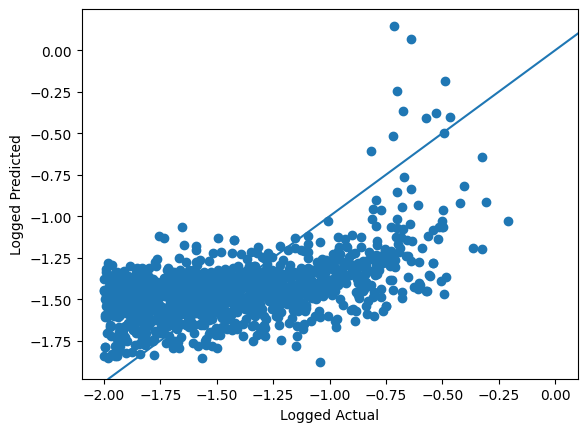

<Figure size 640x480 with 0 Axes>

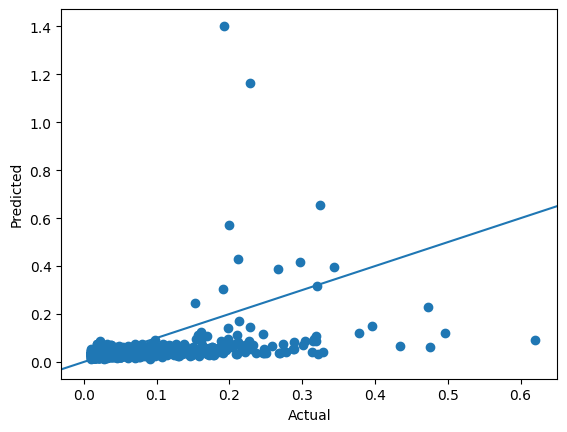

pha
Index(['aph440_aph676', 'bbp_s_440_555', 'a_bb_555', 'EOF_1', 'EOF_4',
       'EOF_7'],
      dtype='object')
train: 69424 , test: 23141
y_pred: 23141 , y_test: 23141
coefs_mn: [-2.04238258 -1.10683109 -0.06992293 -6.15690247 12.93011052 -6.52737466]
coefs_std: [0.02813604 0.00732512 0.00027451 0.10160579 0.12401799 0.04938212]
int: 24.946406427573855
mean r2: 0.48045337073240385
mean bias: 1.0000198585958848
mean mae: 1.8224833459363907


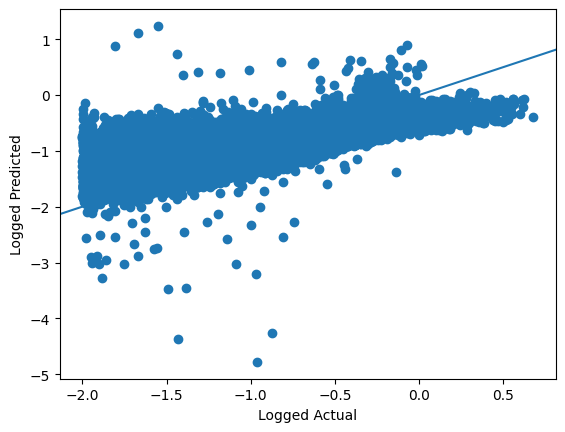

<Figure size 640x480 with 0 Axes>

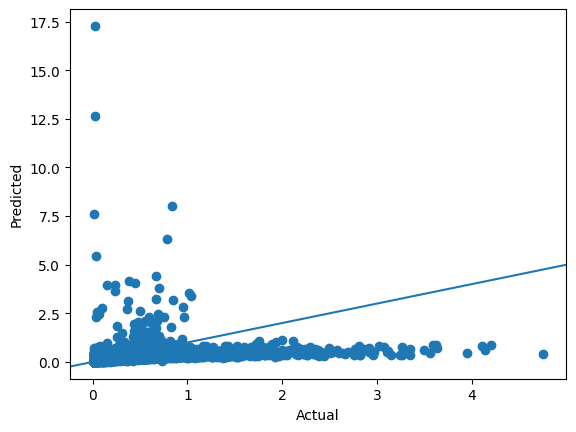

In [144]:
vars_to_run = ['t', 'aph440_aph676', 'bbp_s_440_555', 'a_bb_555',
              'EOF_1', 'EOF_2', 'EOF_3', 'EOF_4', 'EOF_5', 'EOF_6', 'EOF_7', 'EOF_8']

for i in range(len(phyto_dats)):
    MLR(phyto_dat=phyto_dats[i], vars=vars_to_run, output_name='PACE_iops_t_EOFs') 


## PACE IOPs, EOFs

tot
Index(['aph440_aph676', 'a_bb_555', 'EOF_1', 'EOF_2', 'EOF_6', 'EOF_7',
       'EOF_8'],
      dtype='object')
train: 354395 , test: 118131
y_pred: 118131 , y_test: 118131
coefs_mn: [-1.17328432e-01 -1.01914945e-02  5.68648024e+01 -8.29453741e+01
  7.59421653e+01 -5.16181957e+01  4.17795412e+00]
coefs_std: [4.42623708e-04 2.94187838e-05 3.03244317e-01 4.40664701e-01
 3.79563688e-01 2.43138010e-01 1.01702440e-02]
int: 14.729521317622254
mean r2: 0.683644493532726
mean bias: 1.0000009600640374
mean mae: 1.335859118084937


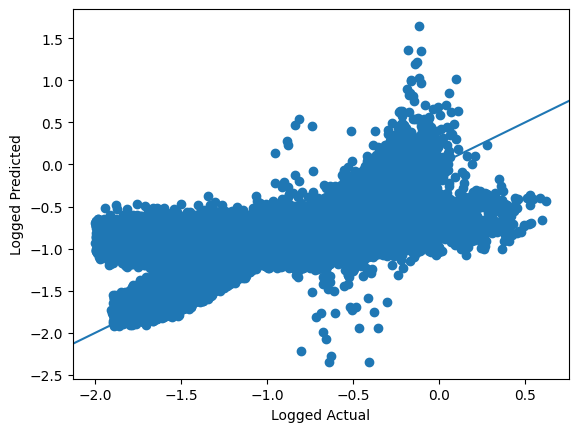

<Figure size 640x480 with 0 Axes>

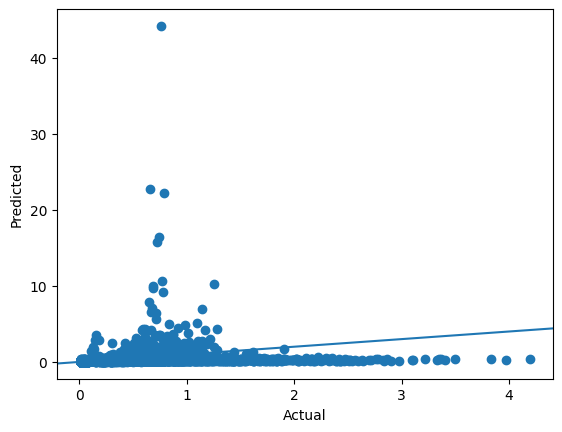

chl
Index(['aph440_aph676', 'bbp_s_440_555', 'a_bb_555', 'EOF_1', 'EOF_4', 'EOF_5',
       'EOF_6', 'EOF_8'],
      dtype='object')
train: 118031 , test: 39343
y_pred: 39343 , y_test: 39343
coefs_mn: [-4.31983886e-01 -1.27371404e+00 -1.34058651e-02  5.79855183e+01
 -1.68267123e+02 -1.95450516e+01  1.17827036e+02  2.28858319e+01]
coefs_std: [2.09976715e-03 7.17975194e-03 7.12661723e-05 4.77750106e-01
 1.40905258e+00 1.69468531e-01 9.94982529e-01 2.03452829e-01]
int: -16.118570224994258
mean r2: 0.6459152147061152
mean bias: 1.0000120159174057
mean mae: 1.4350239821580493


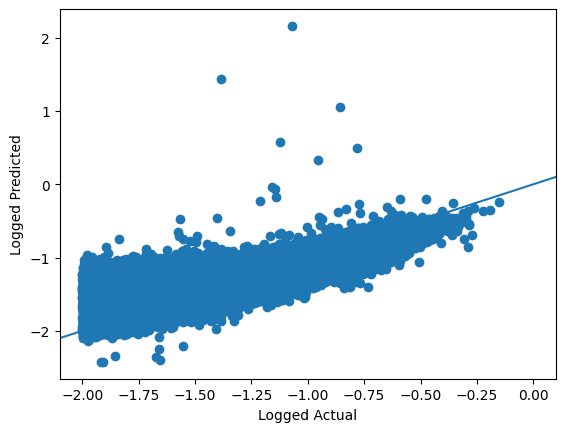

<Figure size 640x480 with 0 Axes>

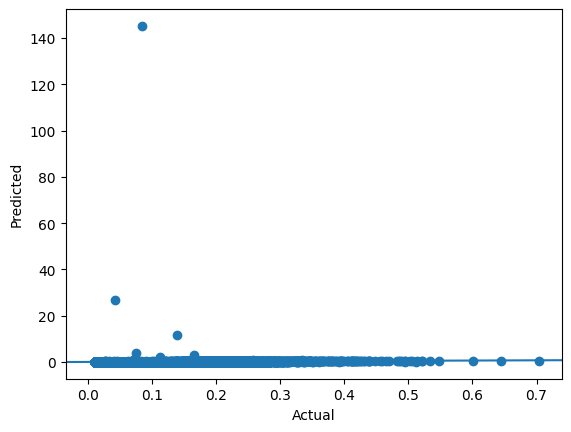

dia
Index(['aph440_aph676', 'bbp_s_440_555', 'a_bb_555', 'EOF_1', 'EOF_2', 'EOF_5',
       'EOF_8'],
      dtype='object')
train: 154198 , test: 51399
y_pred: 51399 , y_test: 51399
coefs_mn: [-4.50151633e-01  1.83315882e+00 -1.44051140e-02  1.33700401e+01
 -1.49980619e+01 -6.72033856e+00  1.63880995e+01]
coefs_std: [0.0012074  0.00373983 0.00010593 0.05740976 0.04727855 0.00641755
 0.02914595]
int: -9.202028069004731
mean r2: 0.7955128589933522
mean bias: 1.0000018104378825
mean mae: 1.445781939501296


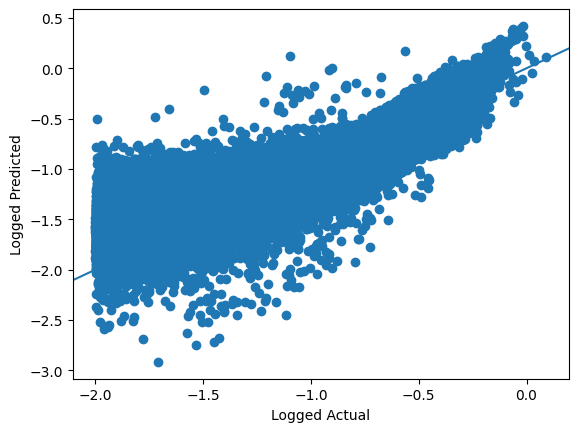

<Figure size 640x480 with 0 Axes>

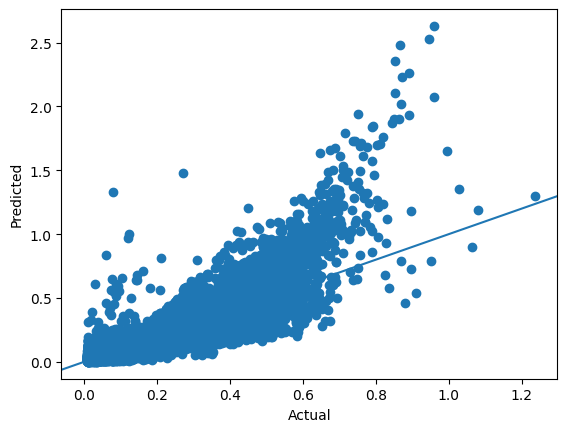

coc
Index(['aph440_aph676', 'a_bb_555', 'EOF_4', 'EOF_6'], dtype='object')
train: 131991 , test: 43996
y_pred: 43996 , y_test: 43996
coefs_mn: [  0.40793785  -0.02485937  13.2197562  -11.80203367]
coefs_std: [4.69218686e-04 4.69183953e-05 1.84664982e-02 1.54494419e-02]
int: -6.182049602625889
mean r2: 0.9157108862499013
mean bias: 1.0000003533479123
mean mae: 1.2468882347790171


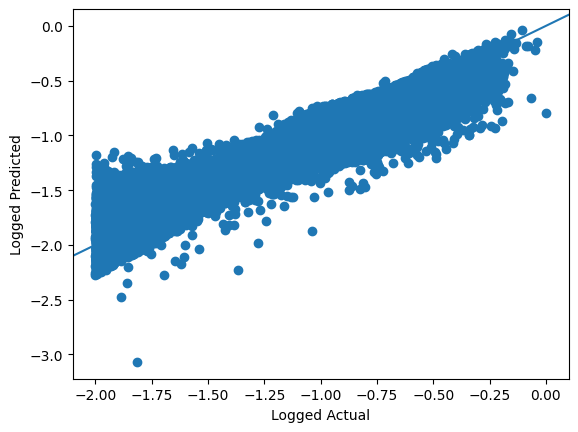

<Figure size 640x480 with 0 Axes>

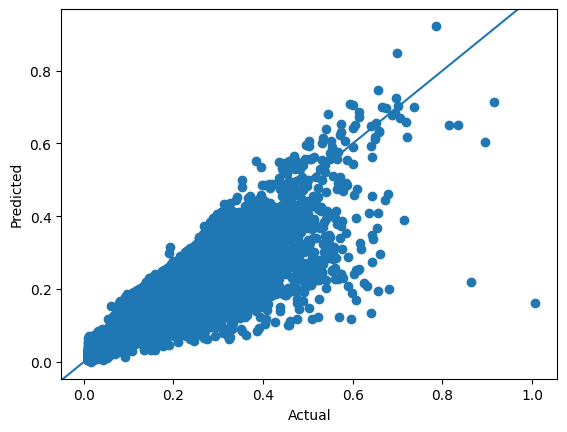

cya
Index(['bbp_s_440_555', 'a_bb_555', 'EOF_1', 'EOF_2', 'EOF_5', 'EOF_6',
       'EOF_8'],
      dtype='object')
train: 166497 , test: 55498
y_pred: 55498 , y_test: 55498
coefs_mn: [-5.06869395e-01  5.87783940e-03 -7.76954339e+01  9.98886468e+01
  3.93333800e+01 -5.05503307e+01 -1.82579064e+01]
coefs_std: [8.05809187e-03 6.62031483e-05 4.11274125e+00 4.97584690e+00
 2.10403193e+00 2.62347150e+00 7.11909919e-01]
int: 17.033957152827647
mean r2: 0.7427979594910391
mean bias: 1.0000134253782007
mean mae: 1.184026245166062


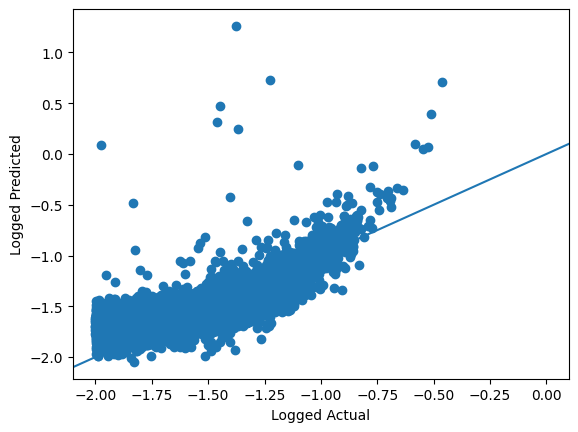

<Figure size 640x480 with 0 Axes>

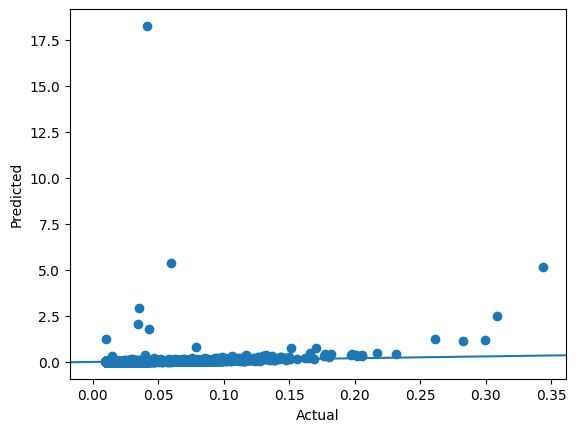

din
Index(['bbp_s_440_555', 'a_bb_555', 'EOF_2', 'EOF_8'], dtype='object')
train: 3603 , test: 1201
y_pred: 1201 , y_test: 1201
coefs_mn: [-0.71343116  0.01118209  4.63386476 -8.56159525]
coefs_std: [0.03092724 0.0002595  0.12190162 0.19620857]
int: -1.7737090969779898
mean r2: 0.2777774998582662
mean bias: 1.0005550438719237
mean mae: 1.9155012505341509


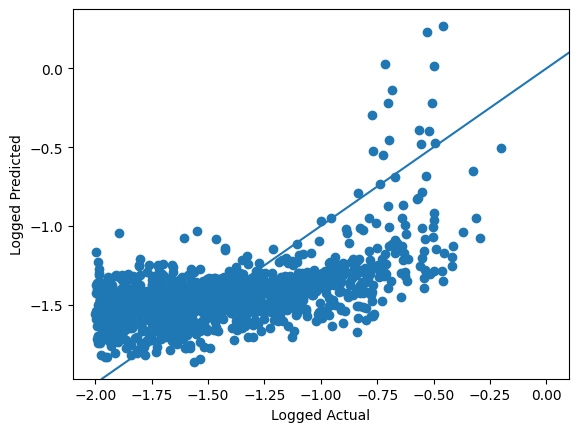

<Figure size 640x480 with 0 Axes>

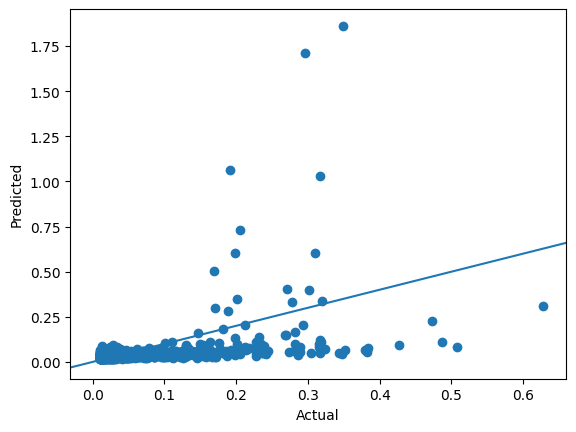

pha
Index(['aph440_aph676', 'bbp_s_440_555', 'a_bb_555', 'EOF_1', 'EOF_4',
       'EOF_7'],
      dtype='object')
train: 69424 , test: 23141
y_pred: 23141 , y_test: 23141
coefs_mn: [-2.04224116 -1.10682613 -0.06992237 -6.15702975 12.93020775 -6.5273786 ]
coefs_std: [0.02426038 0.00704509 0.00025935 0.0975208  0.12136066 0.04851595]
int: 24.94635513273612
mean r2: 0.4804844782792028
mean bias: 1.0000185135499324
mean mae: 1.8224730356579095


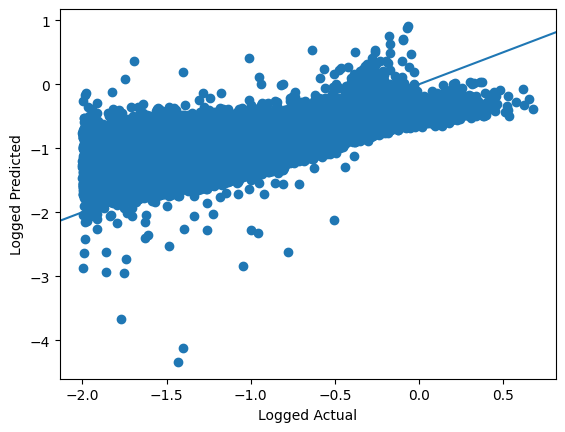

<Figure size 640x480 with 0 Axes>

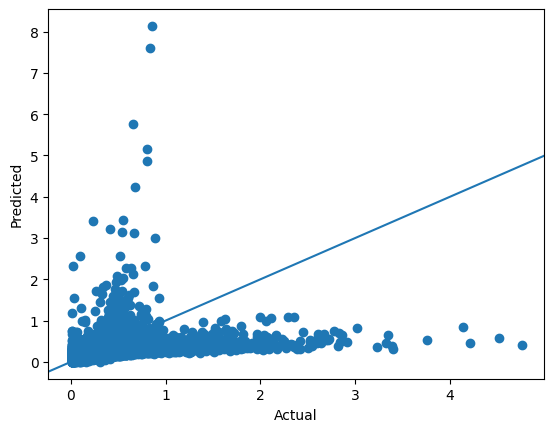

In [145]:
vars_to_run = ['aph440_aph676', 'bbp_s_440_555', 'a_bb_555',
              'EOF_1', 'EOF_2', 'EOF_3', 'EOF_4', 'EOF_5', 'EOF_6', 'EOF_7', 'EOF_8']

for i in range(len(phyto_dats)):
    MLR(phyto_dat=phyto_dats[i], vars=vars_to_run, output_name='PACE_iops_EOFs') 


In [138]:
import itertools

def get_combinations(lst): # creating a user-defined method
   combination = [] # empty list 
   for r in range(1, len(lst) + 1):
      # to generate combination
      combination.extend(itertools.combinations(lst, r))
   return combination
    
objects = ['pic', 'irn', 'rno', 'h', 'sil', 'dtc', 'cdc', 't', 's', 'par', 'aph440_aph676',
       'aph440_ap440', 'a_cdoc_443', 'bbp_s_440_555', 'a_bb_555', 'bbp_bp_555',
       'EOF_1', 'EOF_2', 'EOF_3', 'EOF_4', 'EOF_5', 'EOF_6', 'EOF_7', 'EOF_8']

# creating a list named objects
all_combinations = get_combinations(objects) # method call
print(len(all_combinations))

16777215
